In [38]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt 
import pymysql
import numpy as np
from time import perf_counter
import time
import helper_functions as hf
from openpyxl.chart import BarChart, Reference
import openpyxl
from openpyxl.drawing.image import Image 
import os

In [2]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/ethan.tait/Library/CloudStorage/OneDrive-PropelHoldingsInc


# 1. Data 

In [ ]:
folder_path = '/Users/ethan.tait/Library/CloudStorage/OneDrive-PropelHoldingsInc/Sentilink Data'
file_parts = [
    '2024-04-15_sentilink_propelholdings_facets_part_1.csv',
    '2024-04-15_sentilink_propelholdings_facets_part_2.csv',
    '2024-04-15_sentilink_propelholdings_facets_part_3.csv',
    '2024-04-15_sentilink_propelholdings_facets_part_4.csv',
    '2024-04-15_sentilink_propelholdings_facets_part_5.csv',
    '2024-04-15_sentilink_propelholdings_facets_part_6.csv'
]

combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in file_parts])
combined_df.head()

In [ ]:
combined_df.shape

In [ ]:
combined_df

In [ ]:
## dont run
def identify_date_columns(df):
    date_columns = []
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower() or 'year' in col.lower():
            date_columns.append(col)
        else:
            try:
                if pd.to_datetime(df[col], errors='coerce').notna().any():
                    date_columns.append(col)
            except Exception:
                continue
    return date_columns

date_columns = identify_date_columns(combined_df)
print(date_columns)

^^^ not needed since we have propelholdings_application_id == lead_sequence_id

In [ ]:
def find_max_min_application_id(df, column_name):
    if column_name in df.columns:
        max_value = df[column_name].max()
        min_value = df[column_name].min()
        return max_value, min_value
    else:
        return None, None
    
max_id, min_id = find_max_min_application_id(combined_df, 'propelholdings_application_id')
print(f"Max lsid: {max_id}")
print(f"Min lsid: {min_id}")

In [ ]:
combined_df.rename(columns={'propelholdings_application_id': 'lead_sequence_id'}, inplace=True)

In [ ]:
## dont run
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True ,
                              auth_plugin='mysql_native_password')
limit = 2612698770 ##2617618360 ## max
difference = 100000
lower = 2575865769 ##2562747526 ## min
upper = lower+difference
i=0
timestart = time.time()
while lower <= limit:
    time0=time.time()
    temp = pd.read_sql("""
    SELECT a.lead_sequence_id, a.decision, if(la.origination_loan_id is not null, 1, 0) as isorigination
    FROM datawork.mk_application a
    left join dwh.rpt_leads_accepted la on a.lead_sequence_id = la.lead_sequence_id
    WHERE a.lead_sequence_id > """ + str(lower) + """
    AND a.lead_sequence_id <= """ + str(upper) + """ 
    ;""", con=conn)
    lower = lower + difference
    upper = upper + difference
    if i==0:
        leads_a = temp.copy()
    else:
        leads_a = pd.concat([leads_a, temp], ignore_index=True)
    i+=1    
    print(time.time()-time0)
    print(temp.shape)
    print("lower:",lower)
conn.close()
print('total time: ', time.time()-timestart)

## 1.1 Internal/Propel Data 

In [ ]:
iters=300
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection', use_pure=True,
                              auth_plugin='mysql_native_password')
for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT a.lead_sequence_id, a.organization_id, a.decision, if(la.origination_loan_id is not null, 1, 0) as isorigination
    FROM datawork.mk_application a
    left join dwh.rpt_leads_accepted la on a.lead_sequence_id = la.lead_sequence_id
    WHERE a.lead_sequence_id in """ + str(tuple(combined_df.lead_sequence_id[(i*np.floor(len(combined_df)/iters)).astype(int):((i+1)*np.floor(len(combined_df)/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        internal_df = temp.copy()
    else:
        internal_df = pd.concat([internal_df, temp], ignore_index=True)

#### Merge internal and sentilink 

In [ ]:
merged_df = pd.merge(combined_df, internal_df, on='lead_sequence_id')
merged_df.shape

#### Get fpd data from the merged_df (Use isFPD as the main metric for analysis) 

In [ ]:
fpd_df = hf.get_more_fpd(merged_df)

In [ ]:
fpd_df = fpd_df[fpd_df['isFPD'] != 2]
fpd_df.shape

## 1.2 Get Ever_30dpd_in_90 data 

In [ ]:
pd.options.mode.use_inf_as_na = True
days_since_origination = 90
dpd_days = 30

In [ ]:
# NC MK loans originated in 2023 Q3 to 2024 Q2 (Start +1 month for both) 
##Change origination_time range to alter date range & org_id***
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection',use_pure=True ,
                              auth_plugin='mysql_native_password')
data_90 = pd.read_sql("""select
                            lbl.base_loan_id,
                            a.lead_provider_name,
                            llh.lead_sequence_id,
                            la.origination_time,
                            llh.entity_name,
                            lpsi.payment_schedule_item_id,
                            lpsi.item_date,
                            lpsi.item_type,
                            lpsi.status as payment_status,
                            lpsi.total_amount,
                            lps.payment_schedule_id,
                            #TIMESTAMPDIFF(DAY, la.origination_time, CURDATE()) AS days_since_origination,
                            TIMESTAMPDIFF(DAY, la.origination_time, lpsi.item_date) AS payment_days_since_origination,
                            lbl.loan_amount, 
                            a.UW_STREAM_ID,
                            la.pay_frequency,
                            (select if(lpsi2.status in ('Return', 'MISSED'), 1, 0) from jaglms.lms_payment_schedule_items lpsi2
                            where lpsi2.payment_schedule_id = lps.payment_schedule_id and lps.is_collections!=1 and (lpsi2.item_type != 'C' OR lpsi2.item_type is null) order by item_date limit 1) as isFPD
                            from jaglms.lms_loan_header llh
                            INNER JOIN datawork.mk_application_more mkam on llh.lead_sequence_id = mkam.lead_sequence_id
                            inner join jaglms.lms_base_loans lbl on llh.loan_header_id = lbl.loan_header_id
                            inner join jaglms.lms_payment_schedules lps on lps.base_loan_id = lbl.base_loan_id
                            inner join jaglms.lms_payment_schedule_items lpsi on (lps.payment_schedule_id = lpsi.payment_schedule_id) #and lps.is_collections = 0)
                            inner join dwh.rpt_leads_accepted la on la.lead_sequence_id = llh.lead_sequence_id
                            inner join datawork.mk_application a on llh.lead_sequence_id = a.lead_sequence_id
                            inner join datawork.mk_critical_info mkc on llh.lead_sequence_id = mkc.lead_sequence_id
                            where
                            llh.loan_header_id is not null 
                            and (lpsi.payment_mode != 'CONCESSION' or lpsi.payment_mode is null)
                            and lbl.loan_status !='Pending' 
                            and llh.status not in ('void', 'withdraw', 'Credit Return', 'Closed','closed') 
                            and lpsi.status not in ('scheduled','cancelled','SENT','bypass','Correction','Pending')
                            and la.IsApplicationTest = 0
                            and llh.is_returning = 0
                            and llh.last_name not in ('Schwartzenegger', 'Goler')
                            and la.application_status = 'Originated'
                            and la.origination_time >= '2023-08-01' and la.origination_time <= '2024-04-02'
                            AND la.organization_id != 5
                            and TIMESTAMPDIFF(DAY, la.origination_time, lpsi.item_date) <= """+str(days_since_origination)+"""
                            and (lpsi.item_type != 'C' OR lpsi.item_type is null)
                            ;""", con = conn)
conn.close()

print(data_90.shape)

In [ ]:
data_90['payment_status'] = data_90['payment_status'].str.lower().copy()

In [ ]:
print(data_90.shape)
data_90 = data_90[data_90['payment_status'].isin(['return', 'missed', 'cleared'])]
print(data_90.shape)

In [ ]:
data_90.sort_values(['base_loan_id','item_date'],inplace=True)

In [ ]:
data_90['item_date'] = pd.to_datetime(data_90['item_date'])

In [ ]:
# exclude missed payments after day60 (not enough time to see if they are recovered)
print(data_90.shape)
data_90 = data_90[~ ((data_90.payment_days_since_origination >(days_since_origination-dpd_days)) &
                     (data_90.payment_status.isin(['return','missed'])))]
print(data_90.shape)

In [ ]:
#set 30+dpd as 0 for all payments
data_90['Ever_30DPD_in_90']=0

In [ ]:
# if the missed payment is +30 dpd
# look for missed payments, if to payment amount is not paid in the next 30 days
for i in data_90[data_90.payment_status.isin(['return','missed'])].base_loan_id.unique():
    for j in data_90[(data_90.base_loan_id==i) & (data_90.payment_status.isin(['return','missed']))].payment_schedule_item_id.unique():
        data_90.loc[((data_90.base_loan_id==i) & (data_90.payment_status.isin(['return','missed'])) & (data_90.payment_schedule_item_id==j)),'Ever_30DPD_in_90']= 1         
        if ((data_90[(data_90.base_loan_id==i) & (data_90.payment_status.isin(['cleared'])) & (data_90.item_date> (data_90[data_90.payment_schedule_item_id==j].item_date.values[0])) & ((data_90.item_date - (data_90[data_90.payment_schedule_item_id==j].item_date.values[0])).dt.days<= dpd_days)].total_amount.sum()) >= data_90[(data_90.base_loan_id==i) & (data_90.payment_status.isin(['return','missed'])) & (data_90.payment_schedule_item_id==j)].total_amount).bool():
            data_90.loc[((data_90.base_loan_id==i) & (data_90.payment_status.isin(['return','missed'])) & (data_90.payment_schedule_item_id==j)),'Ever_30DPD_in_90']= 0
data_90_label = data_90.groupby(['lead_sequence_id'])['Ever_30DPD_in_90'].max().to_frame()

In [ ]:
data_90_label = data_90.groupby(['lead_sequence_id'])['Ever_30DPD_in_90'].max().to_frame()
data_90_label

In [ ]:
data_90_label['Ever_30DPD_in_90'].value_counts()

In [ ]:
data_90_label['Ever_30DPD_in_90'].value_counts(dropna=False,normalize=True)

## 1.3 Final df (5310065, 269)
#### - includes: fpd, propel, sentilink, Ever_30dpd_in_90

In [ ]:
df = pd.merge(left=merged_df, right=fpd_df, on='lead_sequence_id', how='left')
df.head()

In [ ]:
final_df = pd.merge(left=df, right=data_90_label, on='lead_sequence_id', how='left')

In [ ]:
columns_drop = ['sentilink_application_sid', 'payment_schedule_id', 'item_date', 'status', 'payment_mode', 
             'total_amount', 'payment_sequence', 'customer_id']
final_df = final_df.drop(columns=columns_drop)

In [ ]:
final_df['decision'] = final_df['decision'].map({'ACCEPT':1,'REJECT':0})

In [5]:
final_df.isFPD.value_counts()

isFPD
0.0    67770
1.0     6217
Name: count, dtype: int64

In [6]:
final_df.isorigination.value_counts()

isorigination
0    5234950
1      75116
Name: count, dtype: int64

In [ ]:
final_df

In [ ]:
sample_perc = 0.05
finals_df = final_df.sample(frac=sample_perc, random_state=42)
finals_df

final_df.to_pickle('Sentilink_df.pkl')

In [ ]:
finals_df['Ever_30DPD_in_90'].value_counts()

In [ ]:
finals_df['decision'].value_counts()

In [3]:
final_df = pd.read_pickle('Sentilink_df.pkl')

# 2. Distribution visualization 

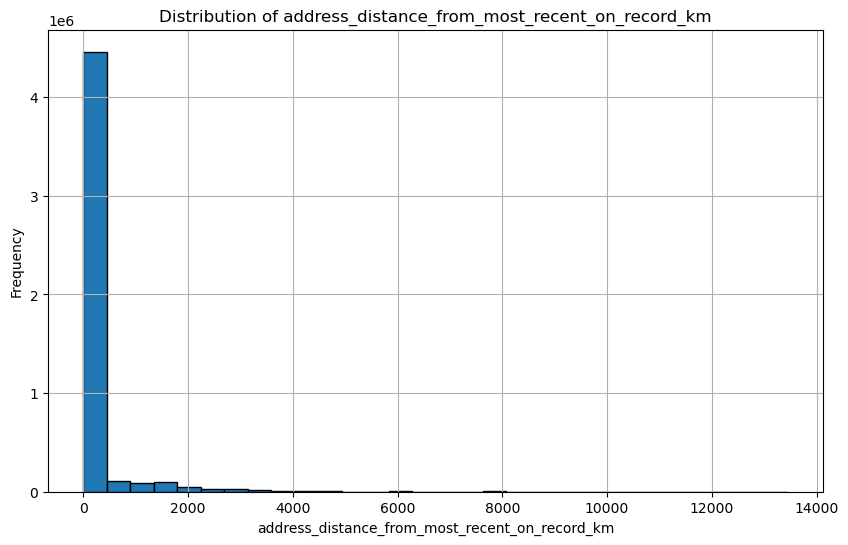

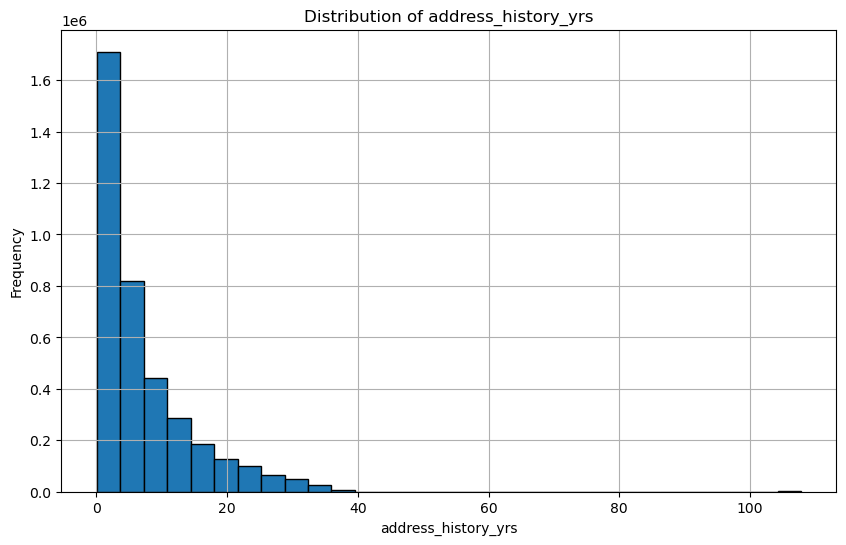

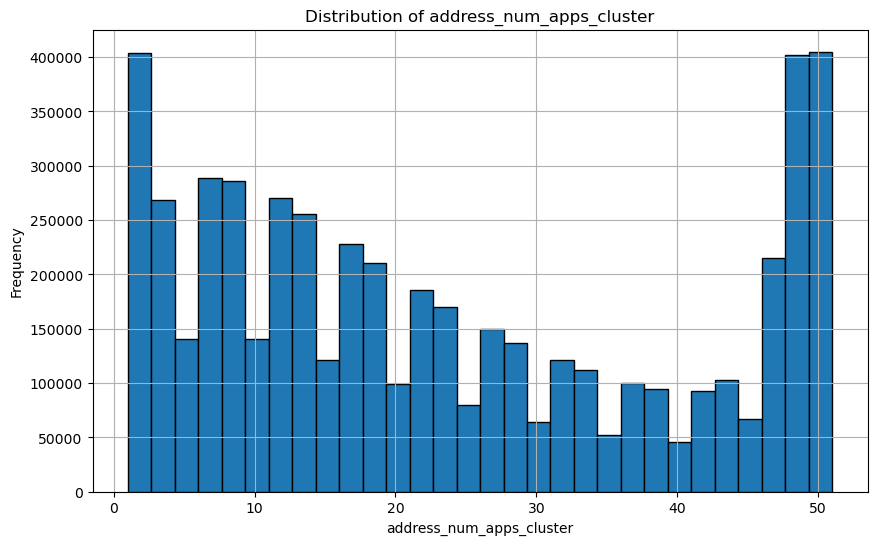

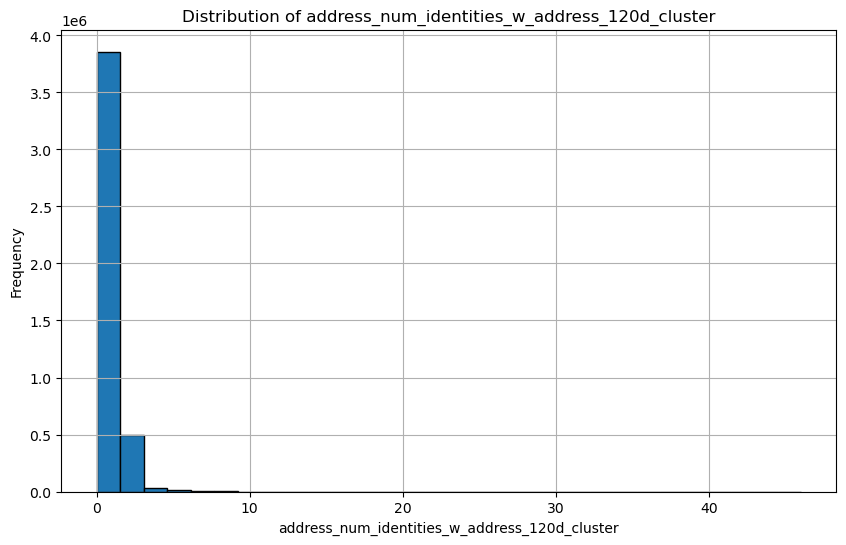

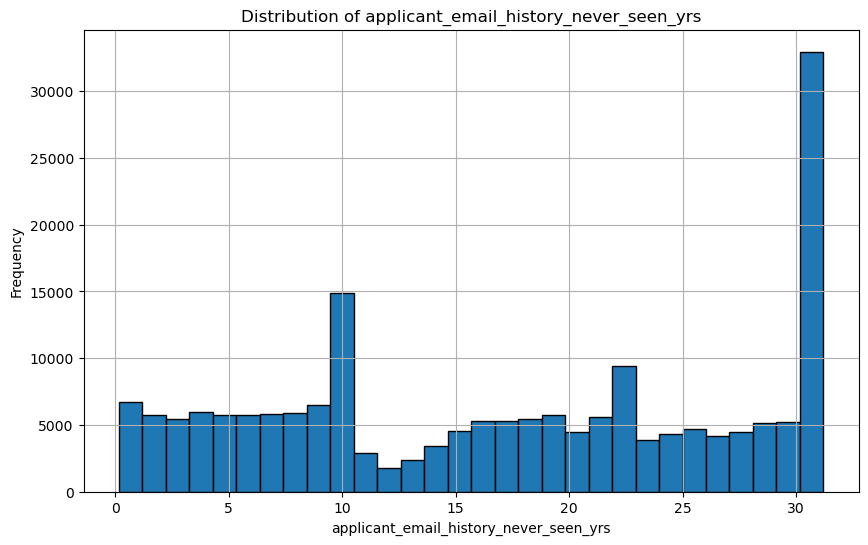

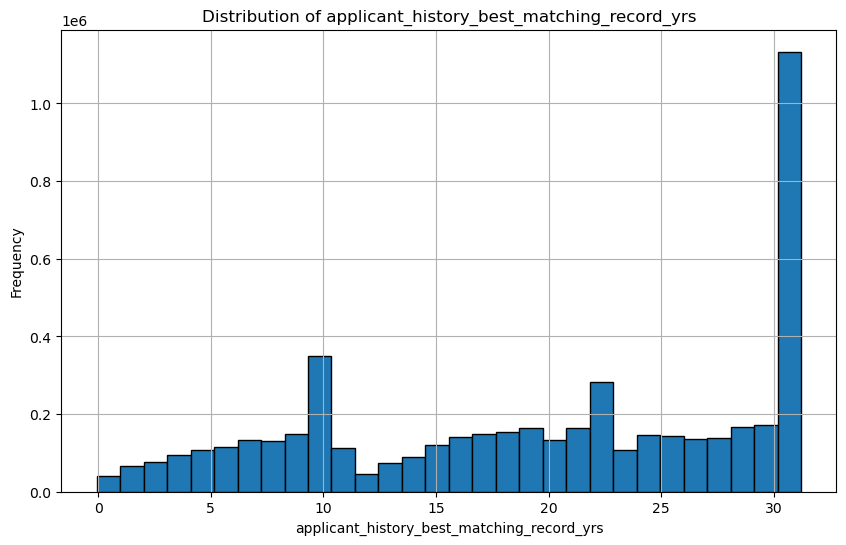

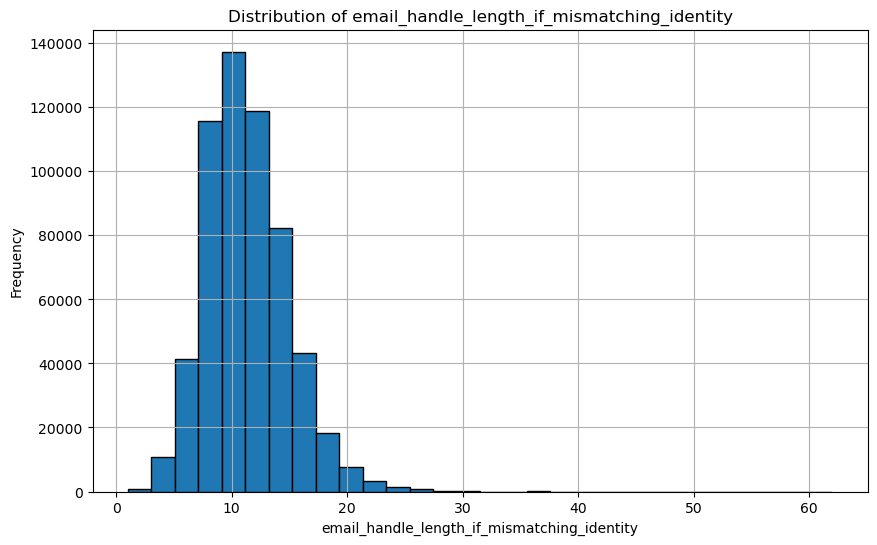

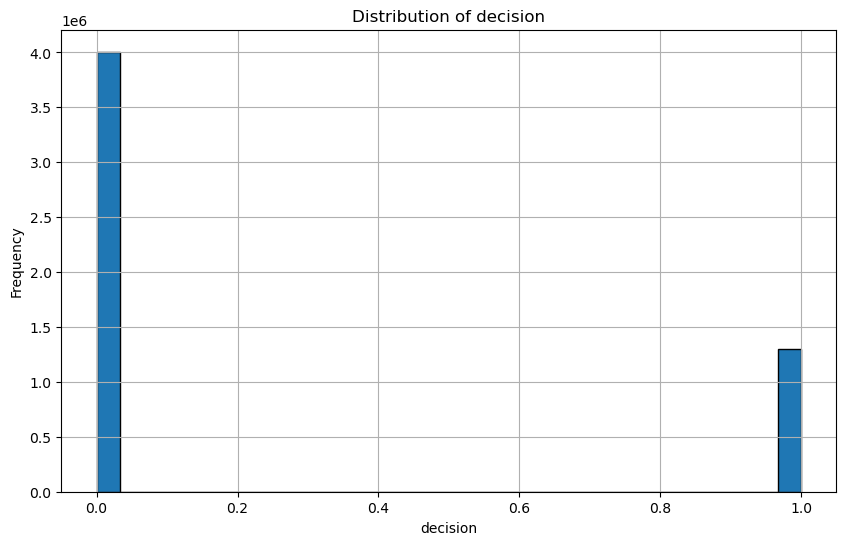

In [7]:
numeric_columns = [
    'address_distance_from_most_recent_on_record_km',
    'address_history_yrs',
    'address_num_apps_cluster',
    'address_num_identities_w_address_120d_cluster',
    'applicant_email_history_never_seen_yrs',
    'applicant_history_best_matching_record_yrs',
    'email_handle_length_if_mismatching_identity',
    'decision'
]

for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    final_df[column].dropna().hist(bins=30, edgecolor='k')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

## 2.1 Ever_30dpd_in_90 visualization

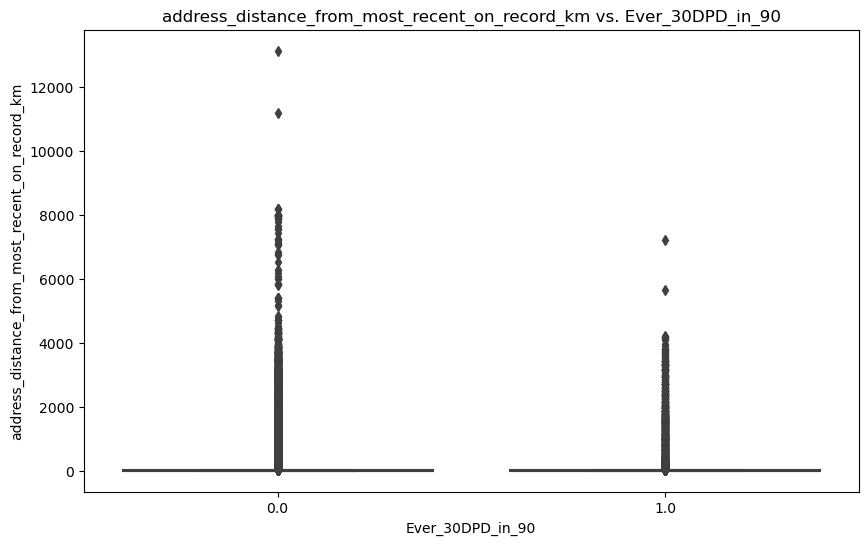

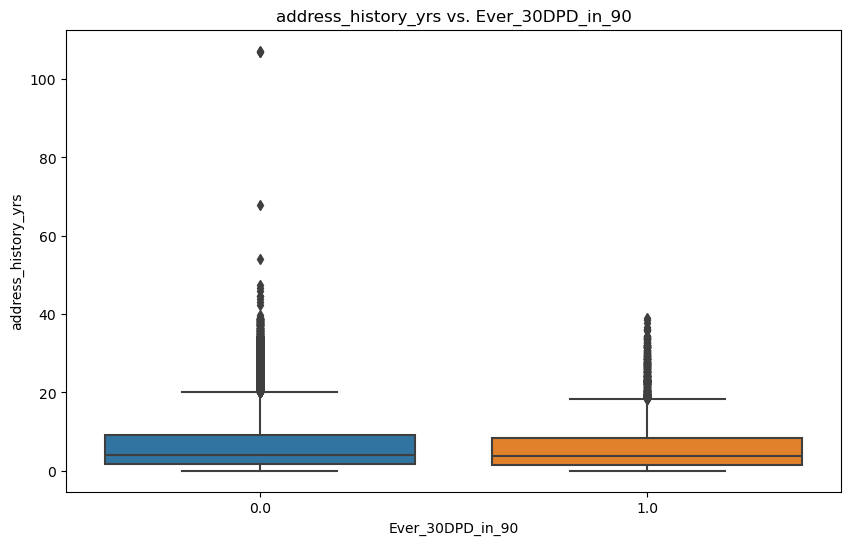

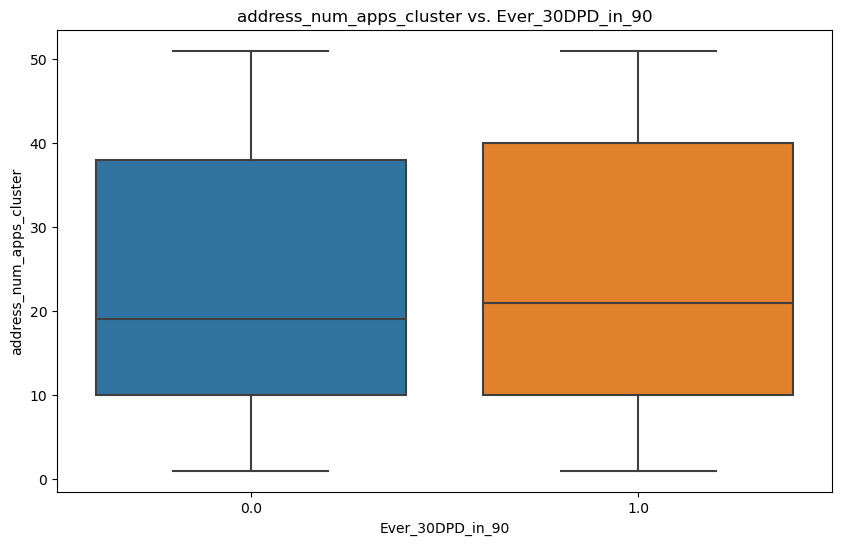

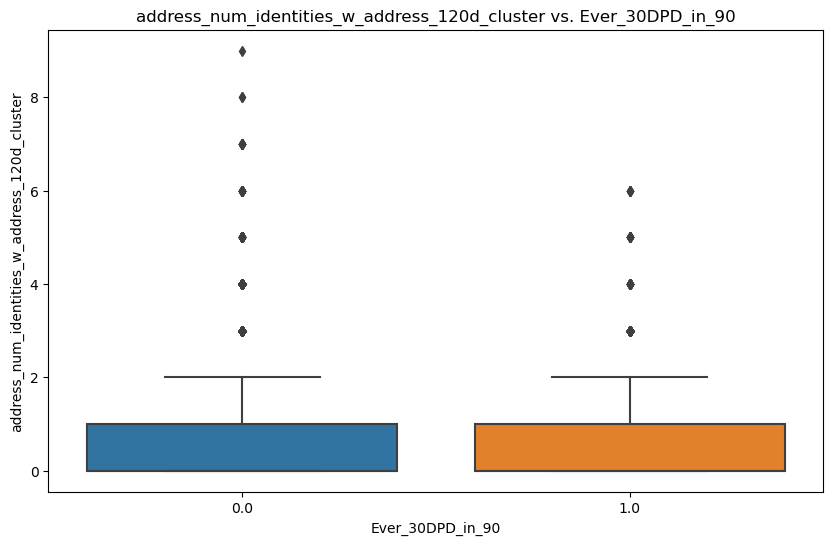

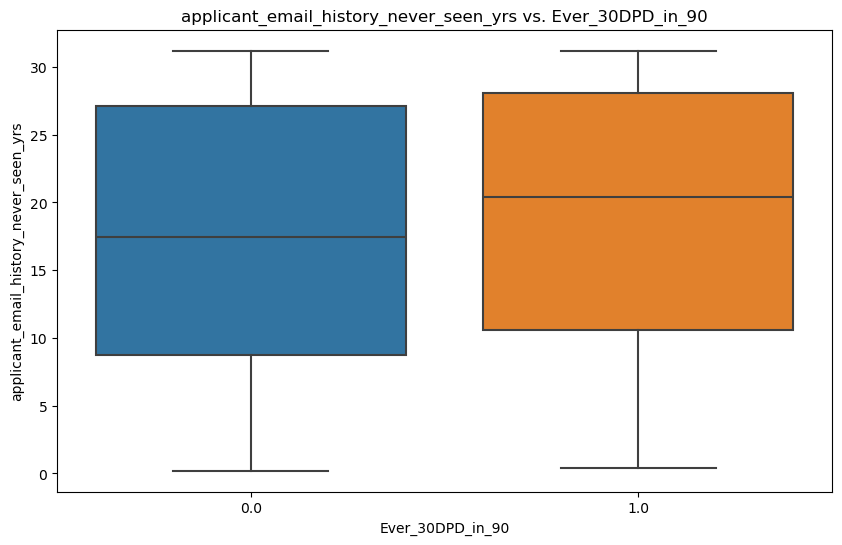

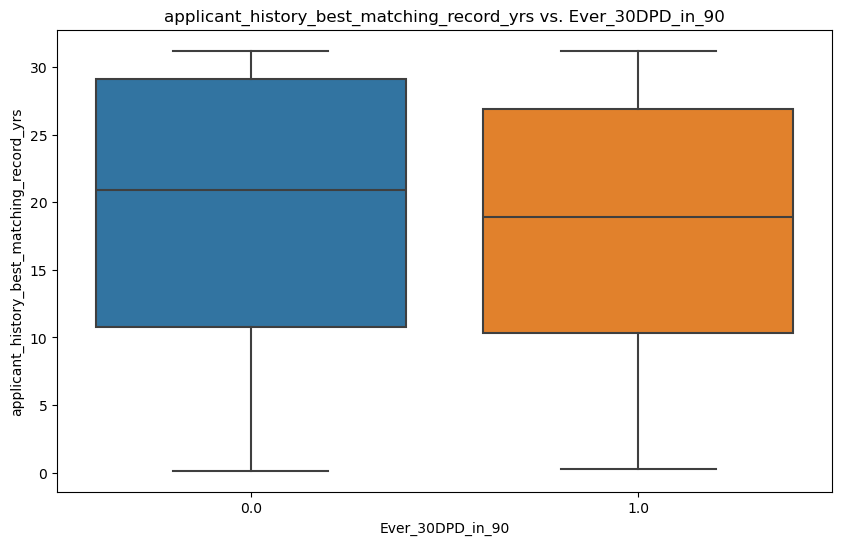

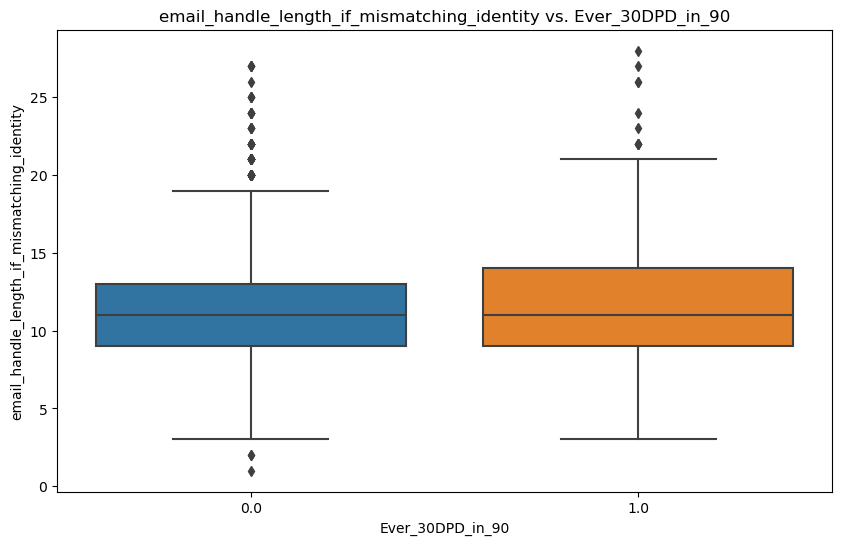

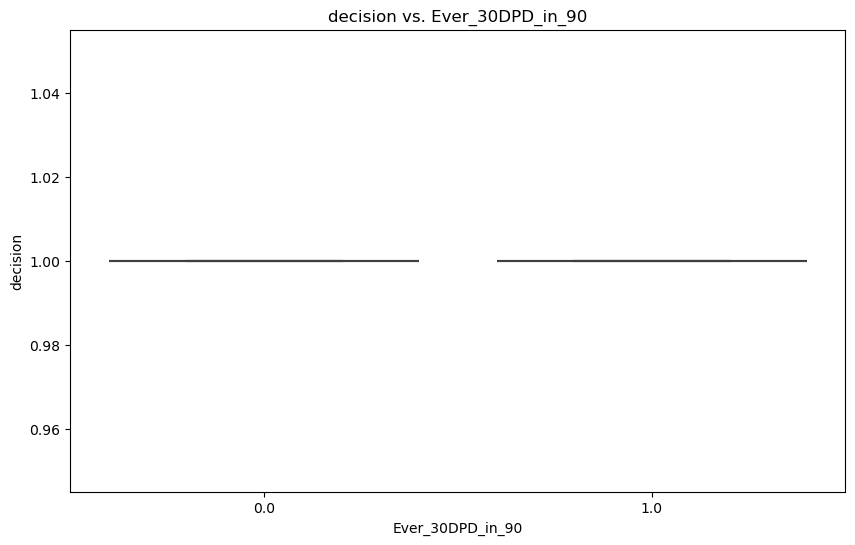

In [8]:
import seaborn as sns

def plot_relationships(data, target, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        if data[feature].dtype in ['int64', 'float64']:
            sns.boxplot(x=data[target], y=data[feature])
            plt.title(f'{feature} vs. {target}')
            plt.xlabel(target)
            plt.ylabel(feature)
        else: 
            sns.countplot(x=data[feature], hue=data[target])
            plt.title(f'{feature} vs. {target}')
            plt.xlabel(feature)
            plt.ylabel('Count')
        plt.show()

plot_relationships(final_df, 'Ever_30DPD_in_90', numeric_columns)

# 3. Feature Importance

## 3.1 Ever_30DPD_in_90 feature 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

data_clean = final_df.dropna(subset=['Ever_30DPD_in_90'])
numeric_features = data_clean.select_dtypes(include=[np.number]).columns.drop('Ever_30DPD_in_90')
numeric_data = data_clean[numeric_features].dropna(axis=1, how='all')

X = numeric_data
y = data_clean['Ever_30DPD_in_90']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
correlation_matrix = X_imputed_df.corr(numeric_only=True)
correlation_matrix['Ever_30DPD_in_90'] = data_clean['Ever_30DPD_in_90']
target_correlations = correlation_matrix['Ever_30DPD_in_90'].dropna().sort_values(ascending=False)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
missing_values = final_df.isnull().sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
feature_importances.head(20).plot(kind='barh')
plt.title('Important Features')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
missing_values.head(20).plot(kind='barh')
plt.title('Most MIssing Values')
plt.xlabel('Number of Missing Values')
plt.gca().invert_yaxis()
plt.show()
### out of 5310065

In [ ]:
top_60_importances = feature_importances.head(60).to_frame(name='Importance')
top_20_missing_values = missing_values.head(20).to_frame(name='Missing Values')

In [ ]:
(top_60_importances, top_20_missing_values)

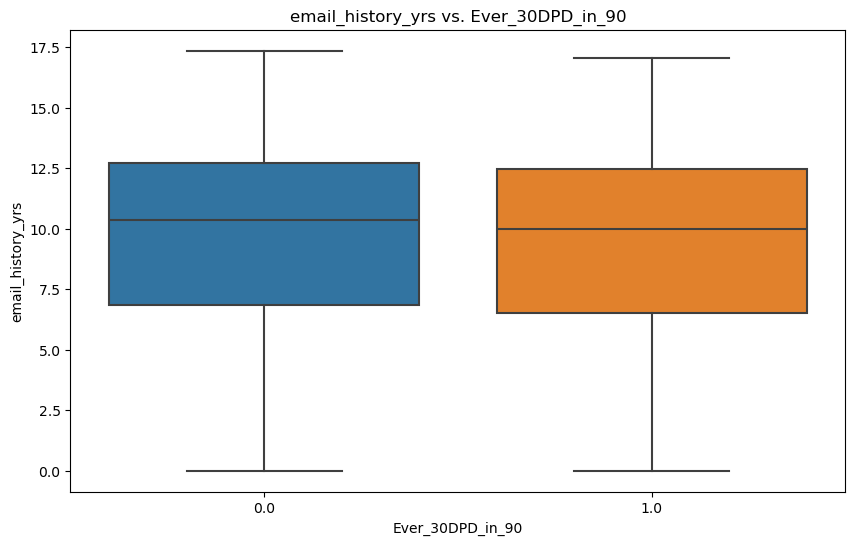

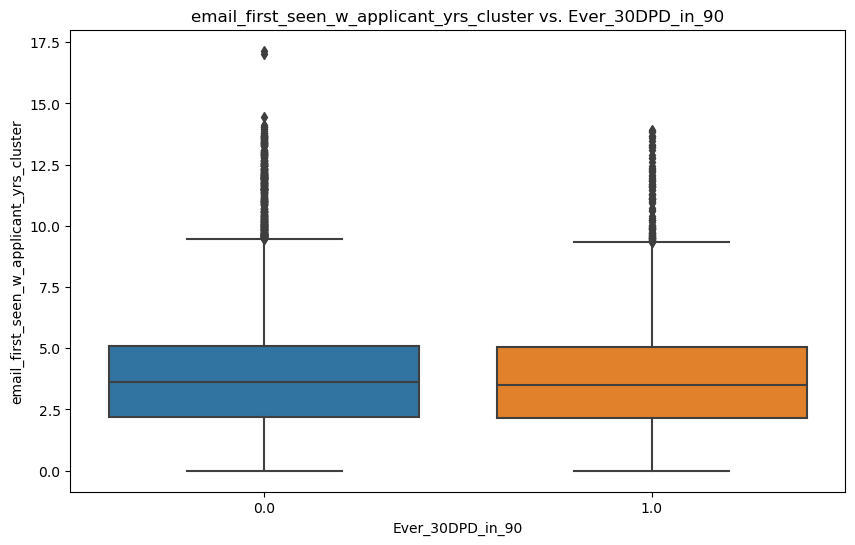

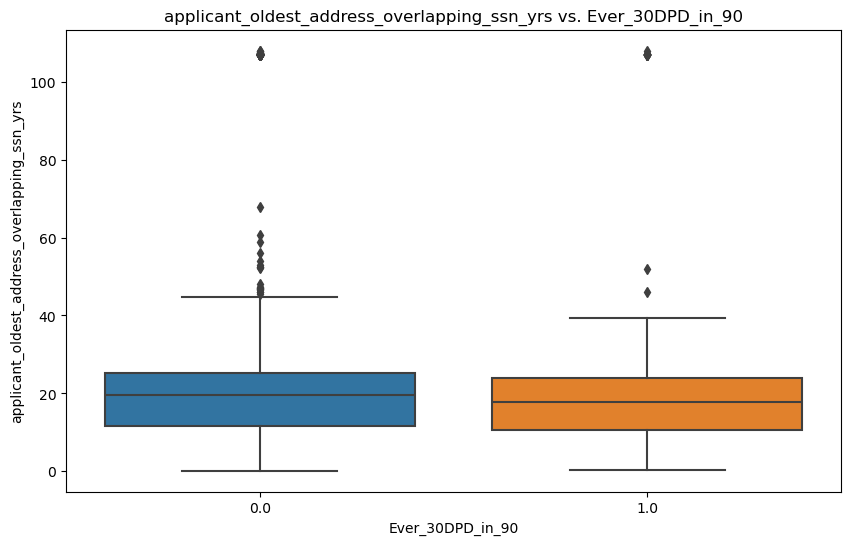

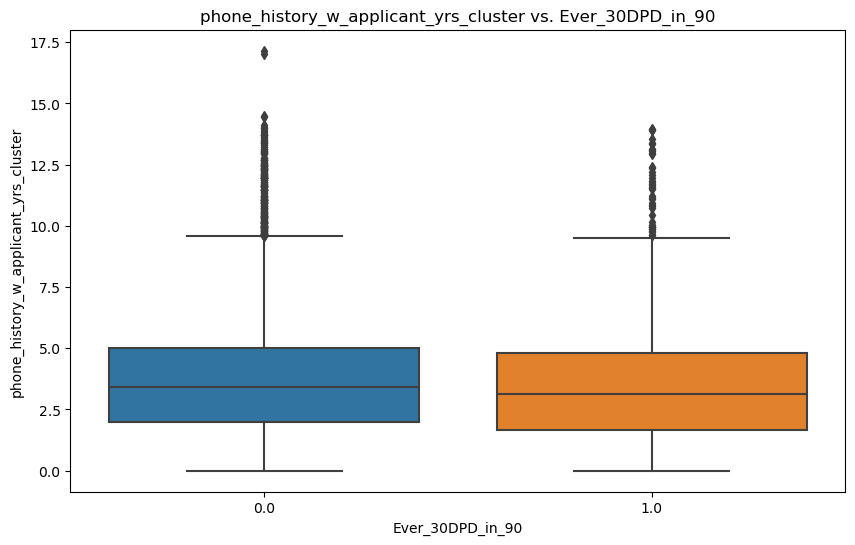

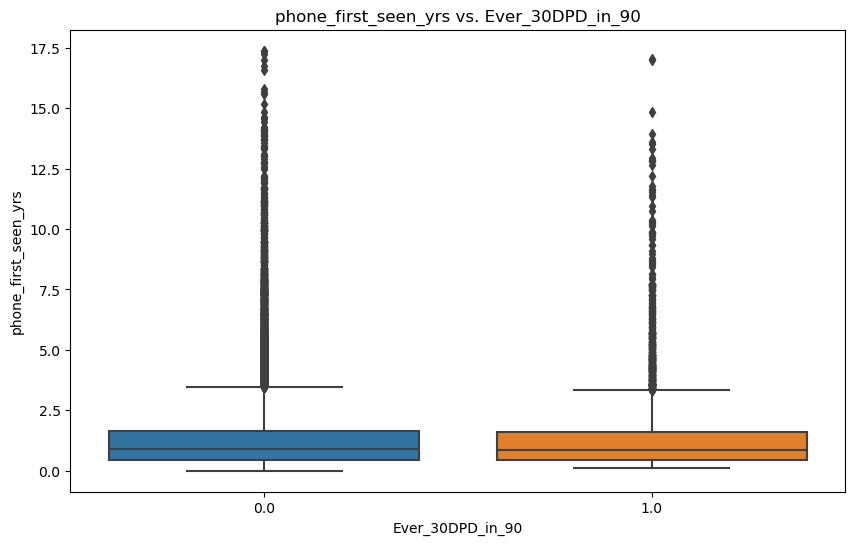

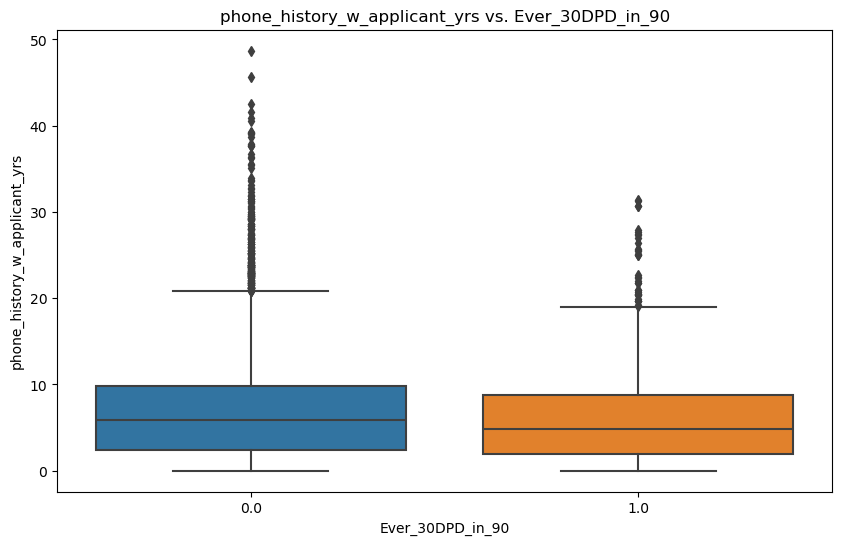

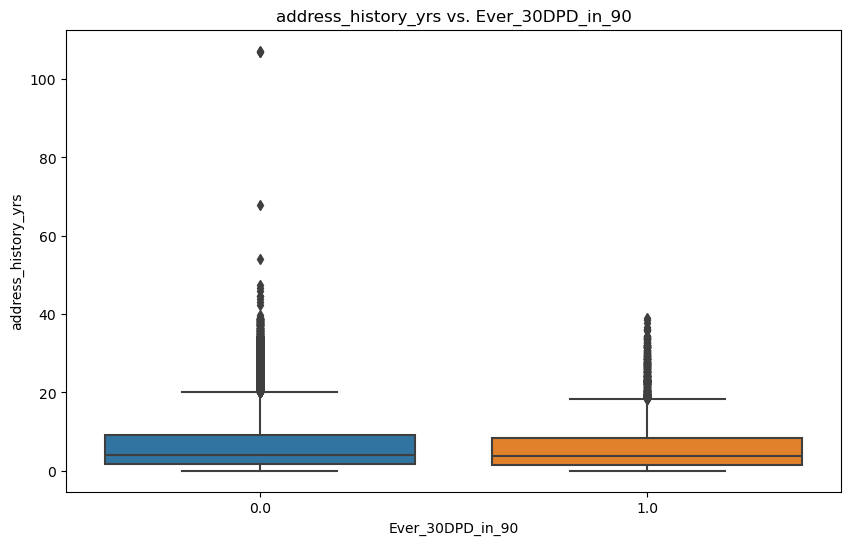

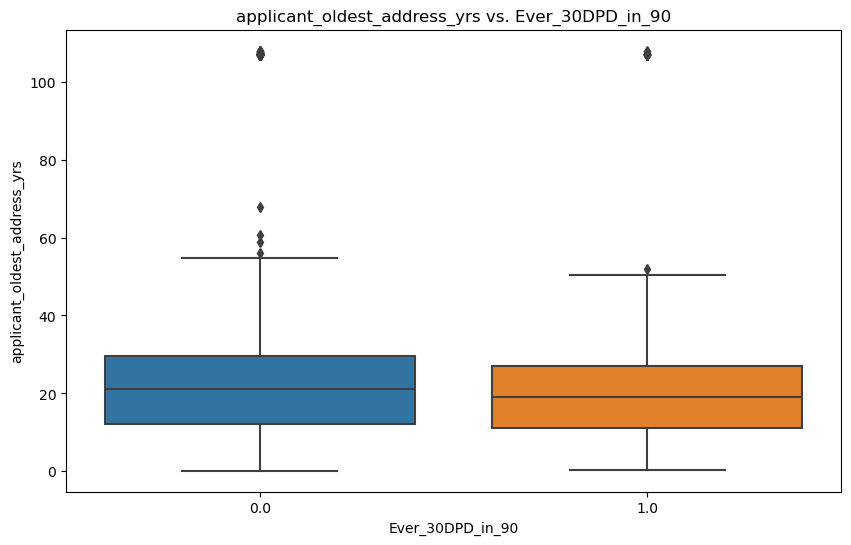

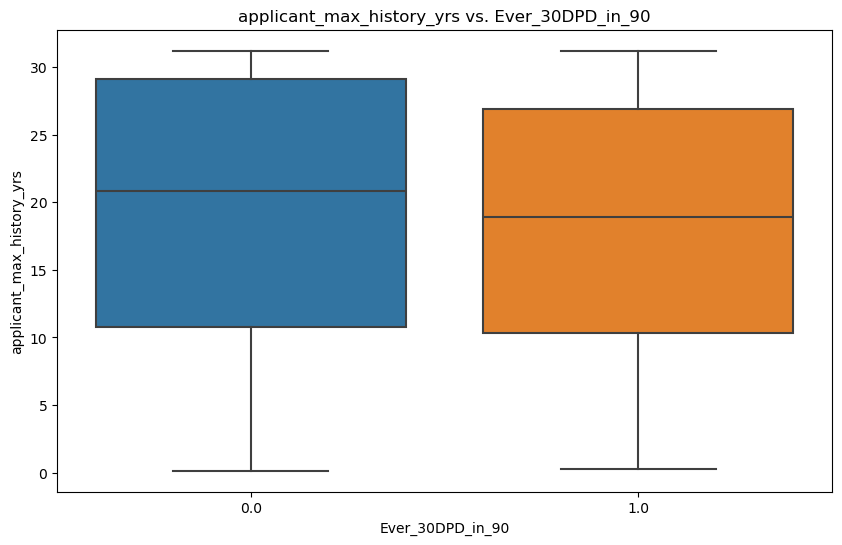

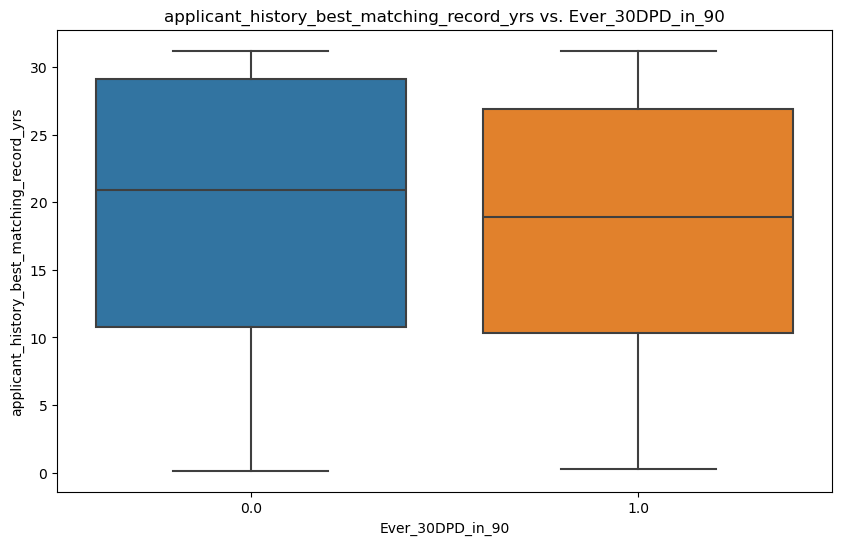

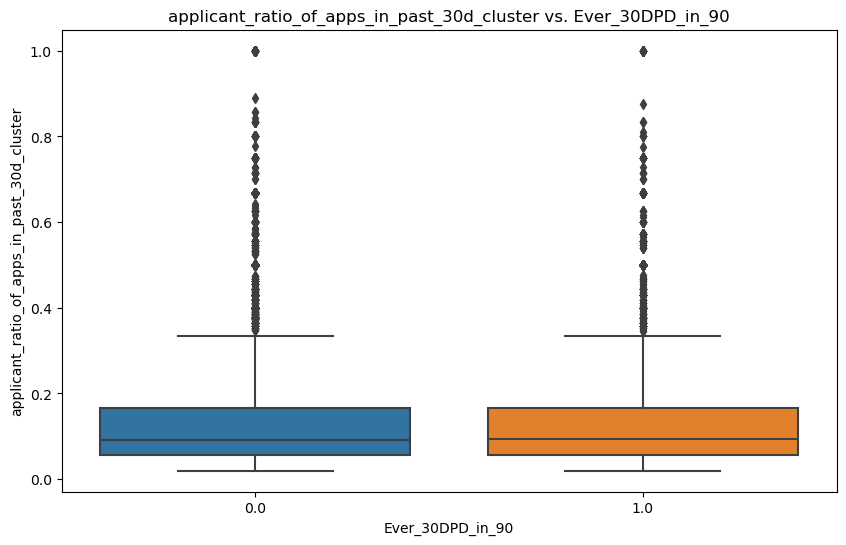

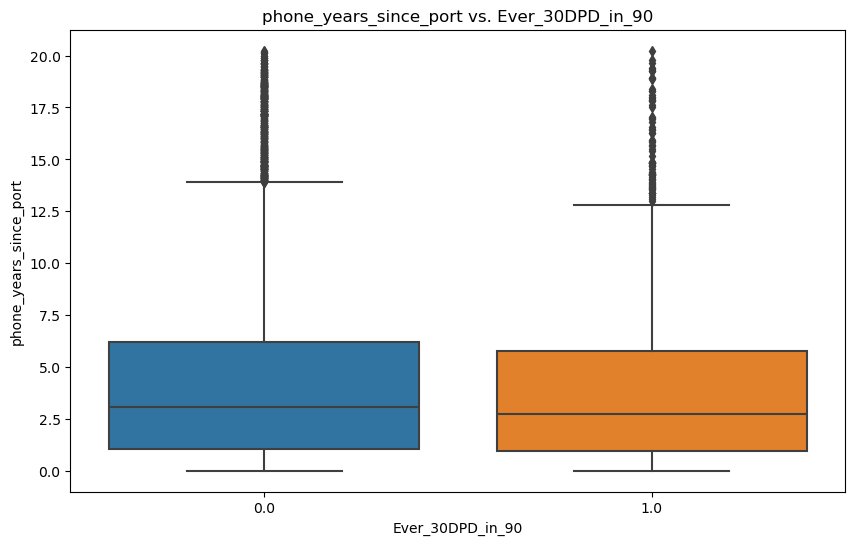

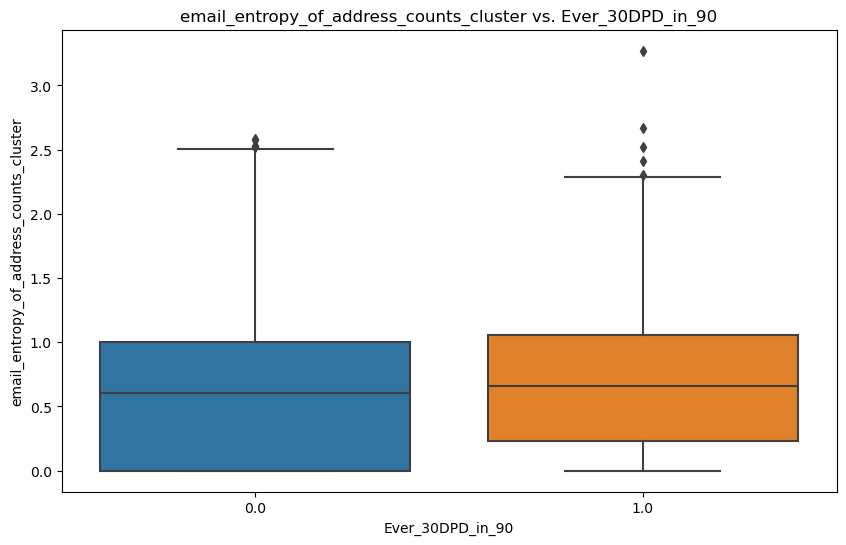

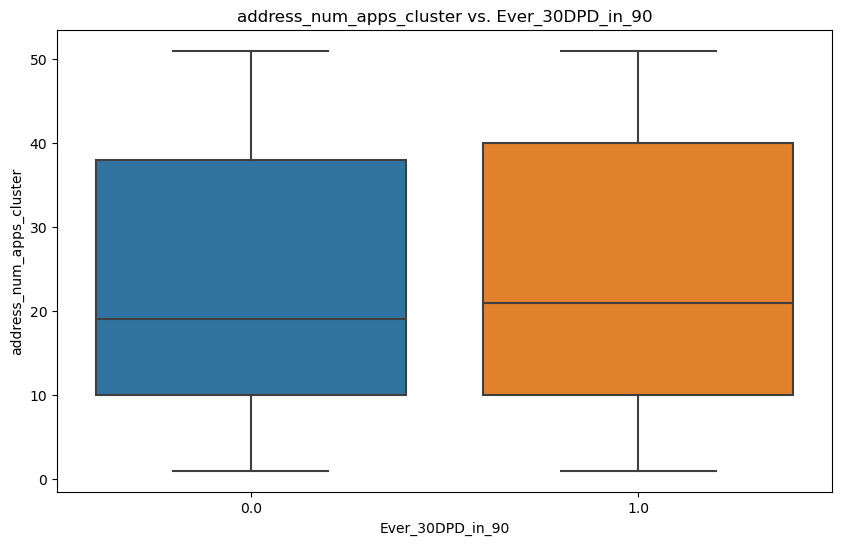

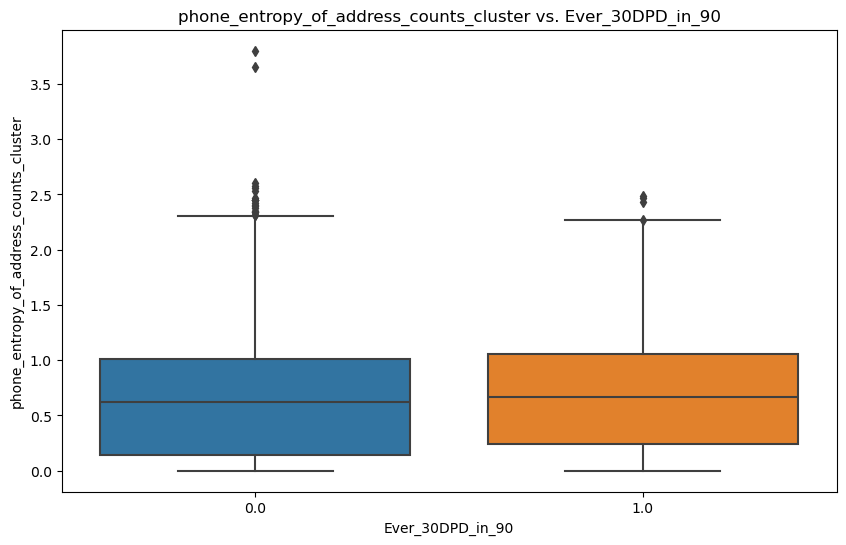

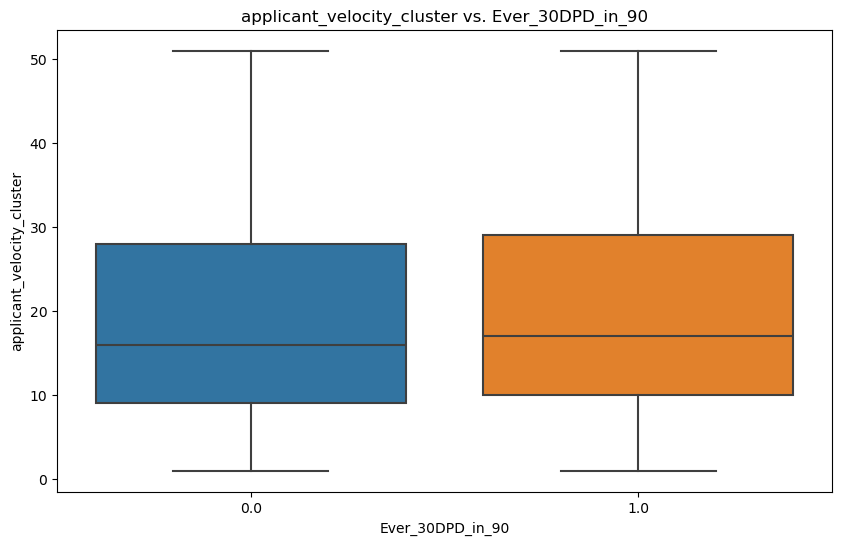

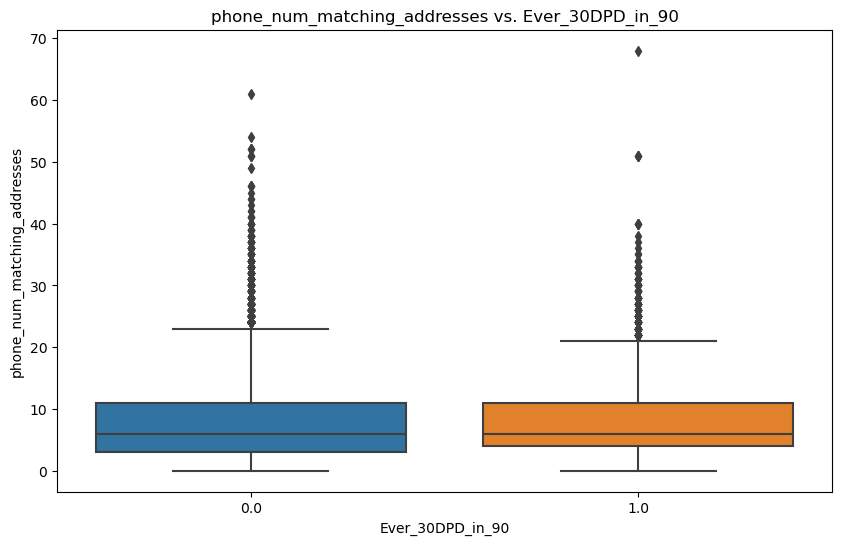

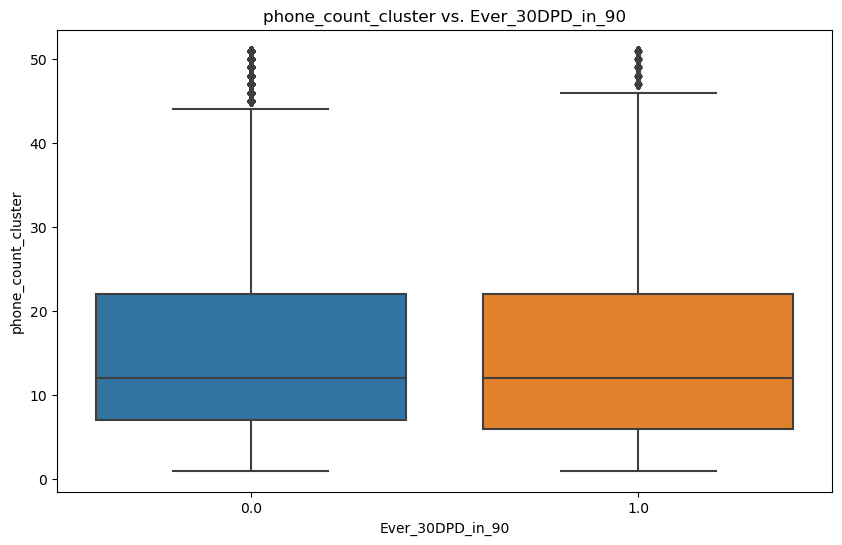

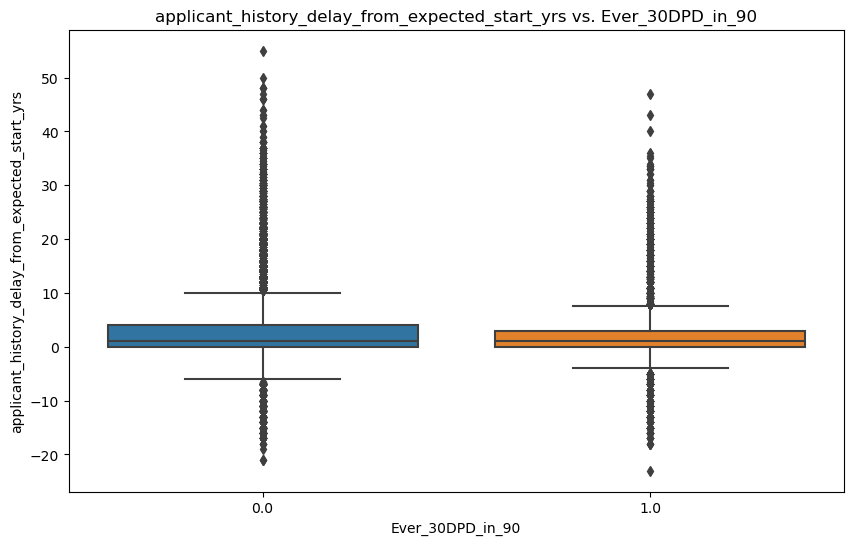

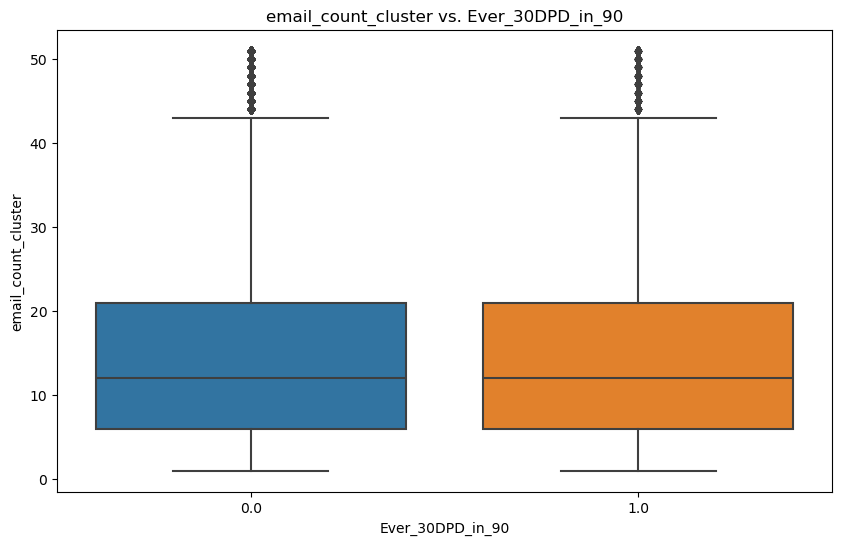

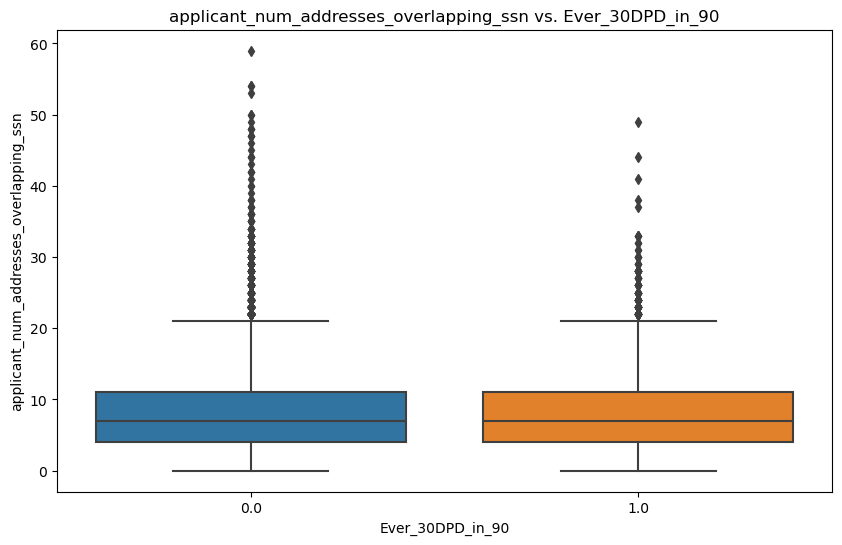

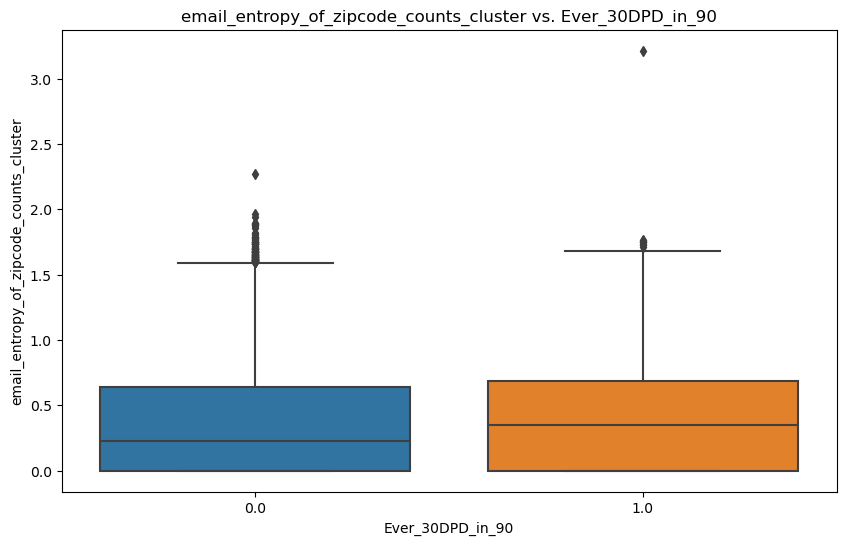

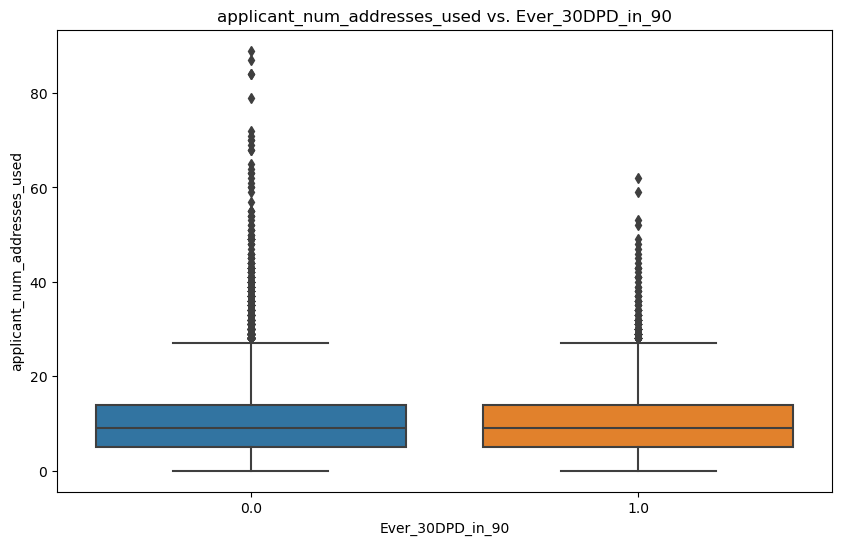

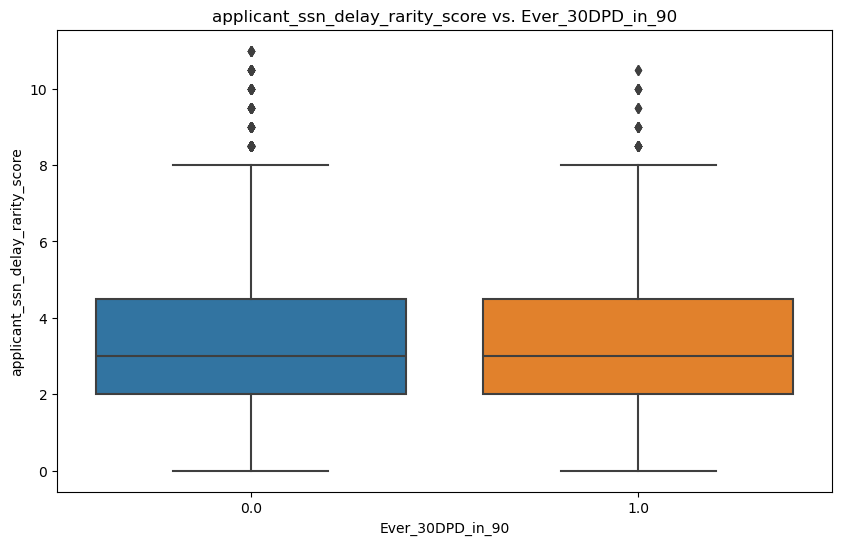

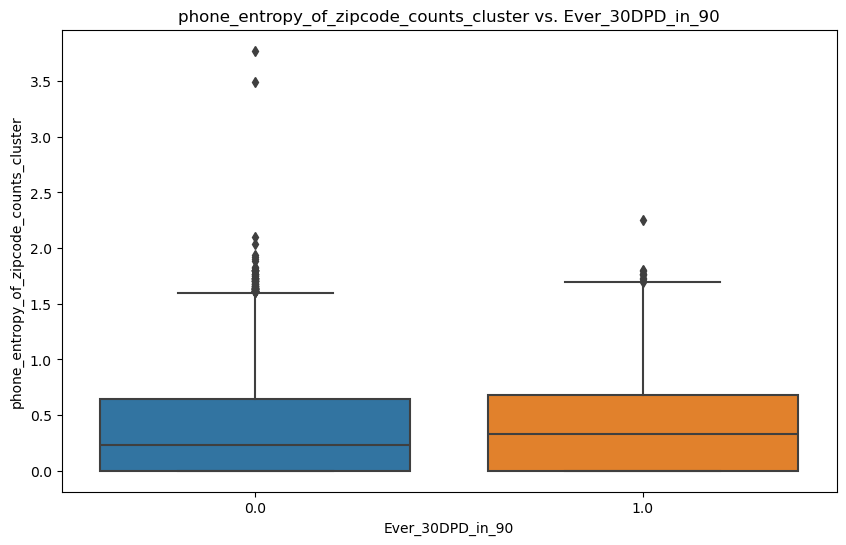

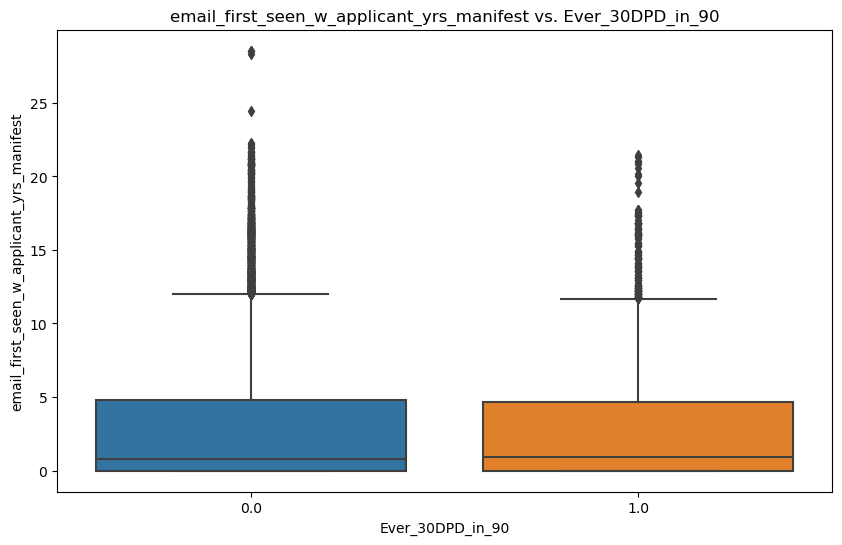

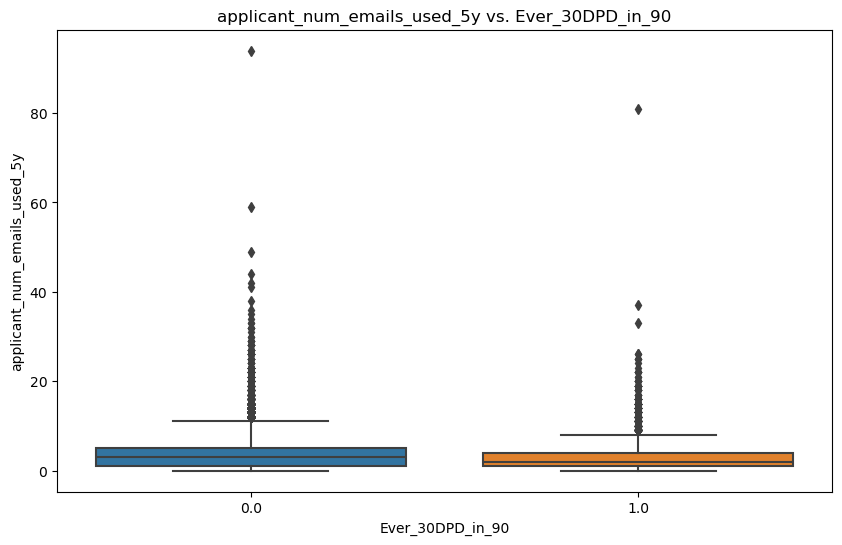

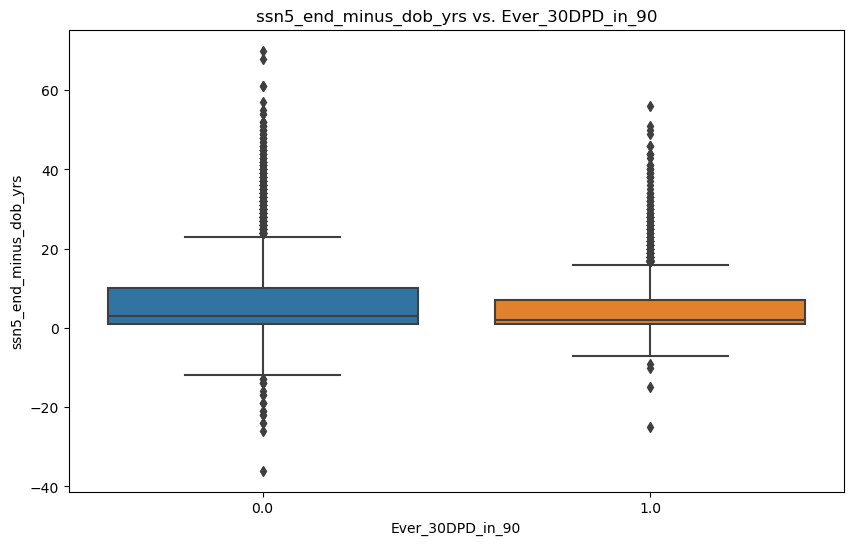

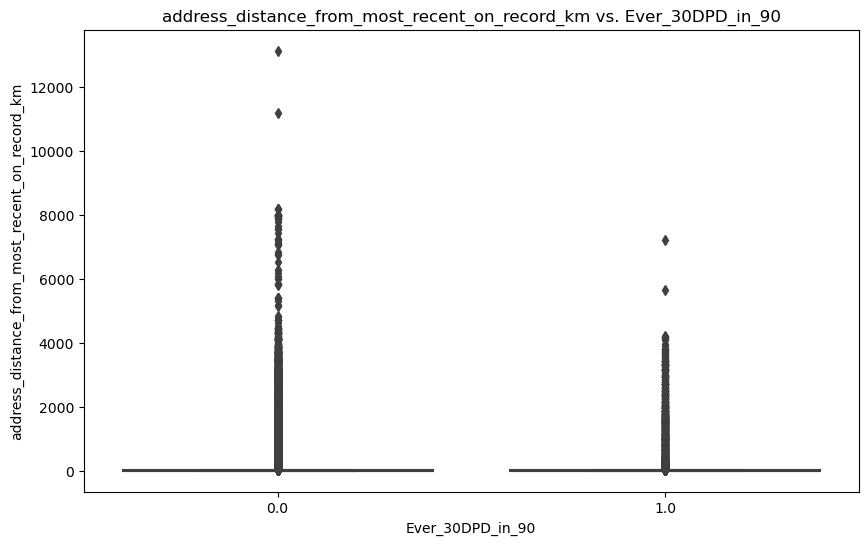

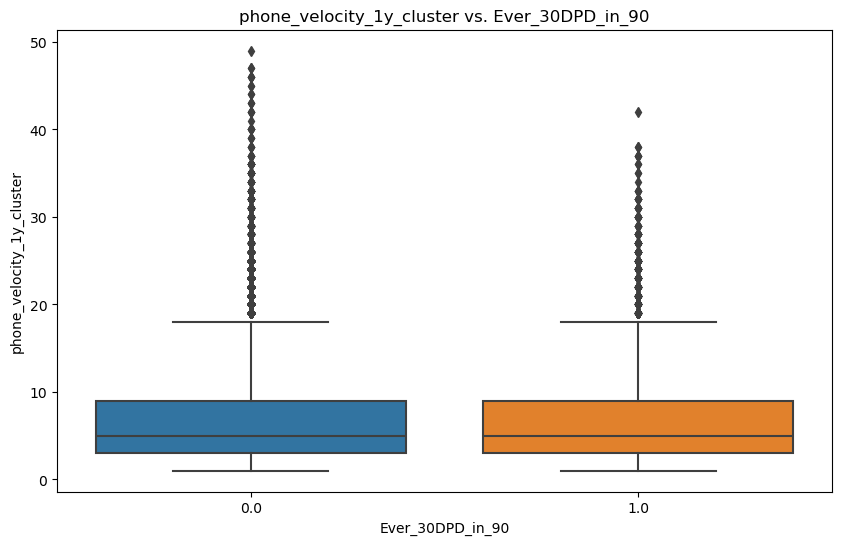

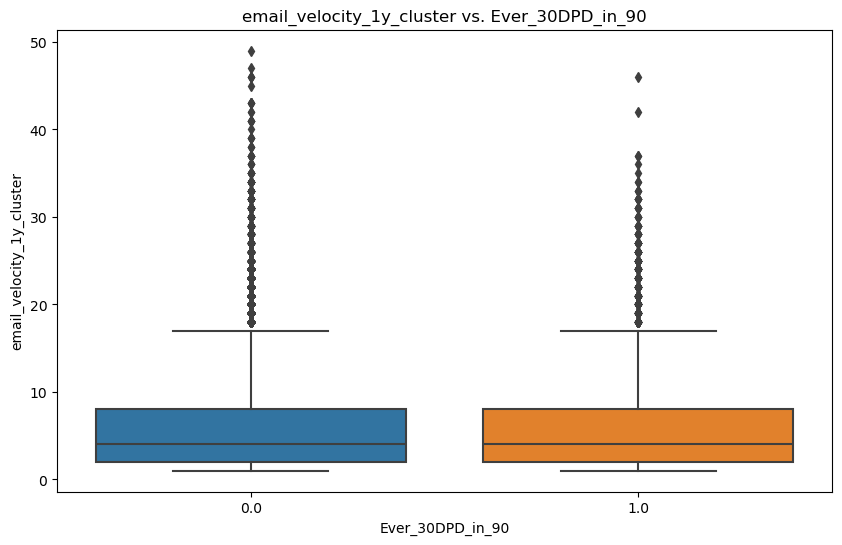

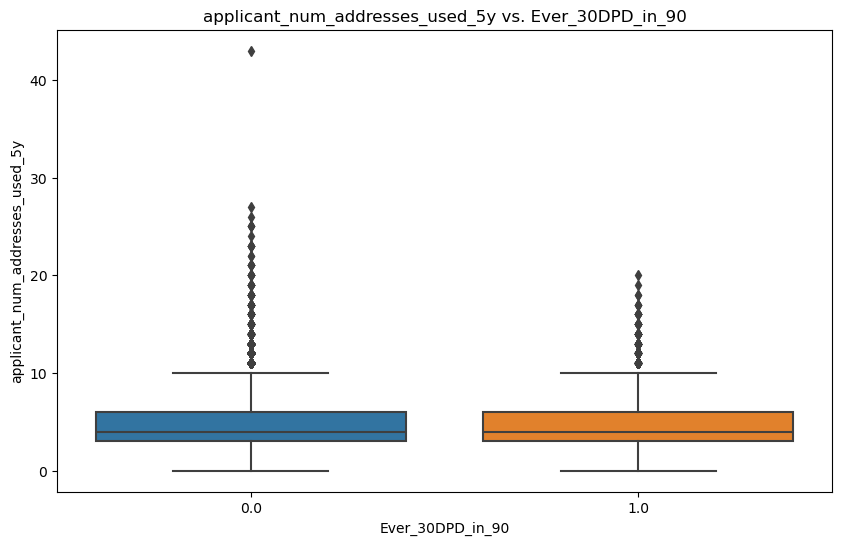

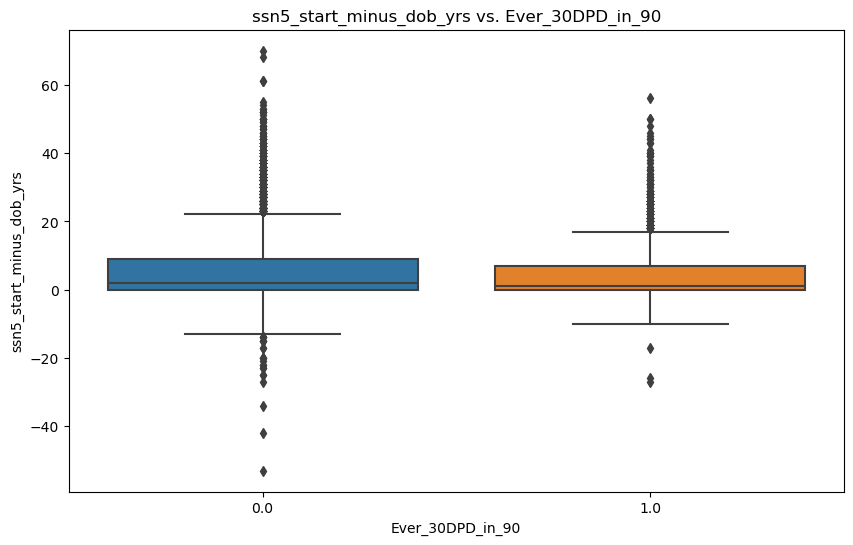

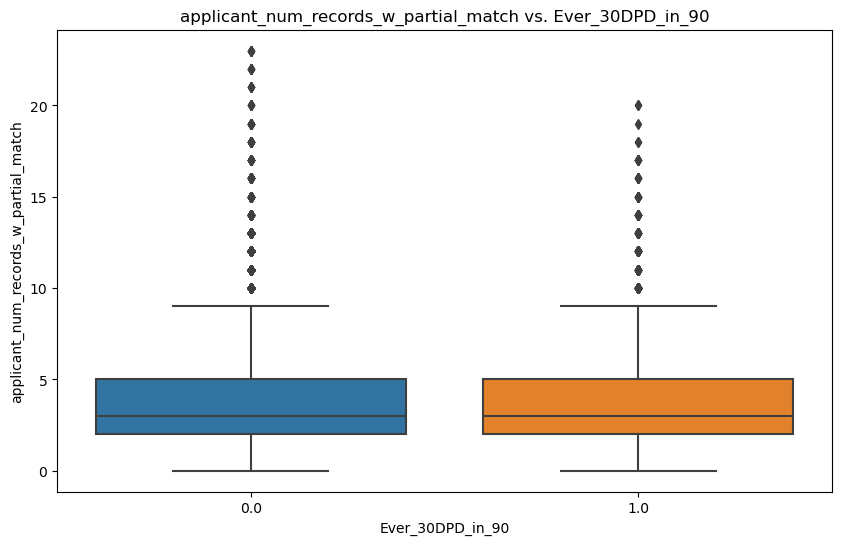

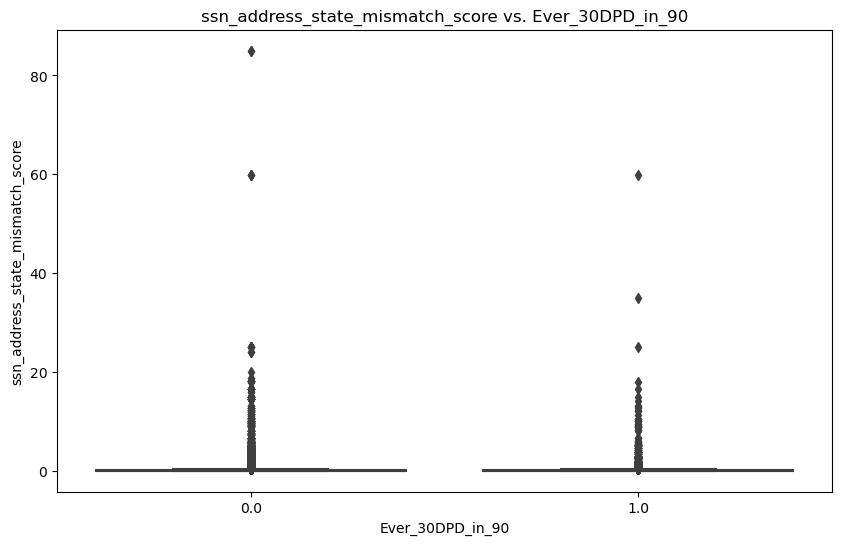

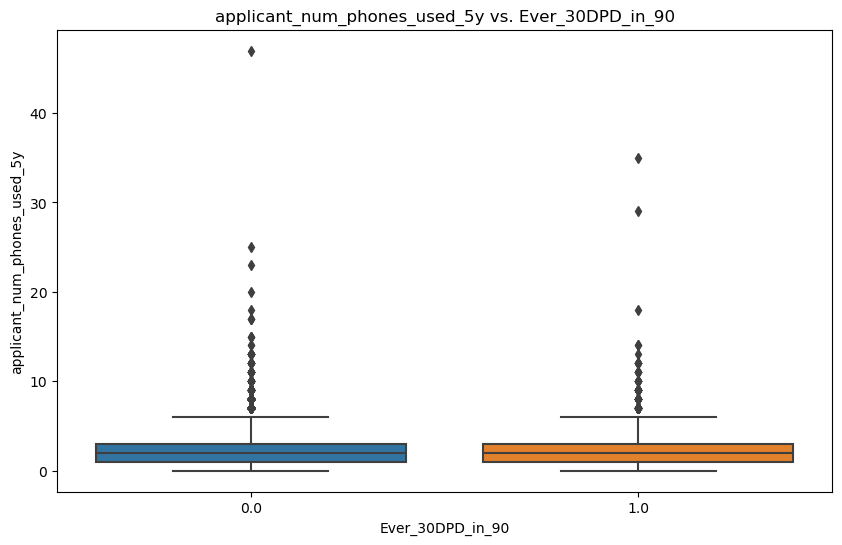

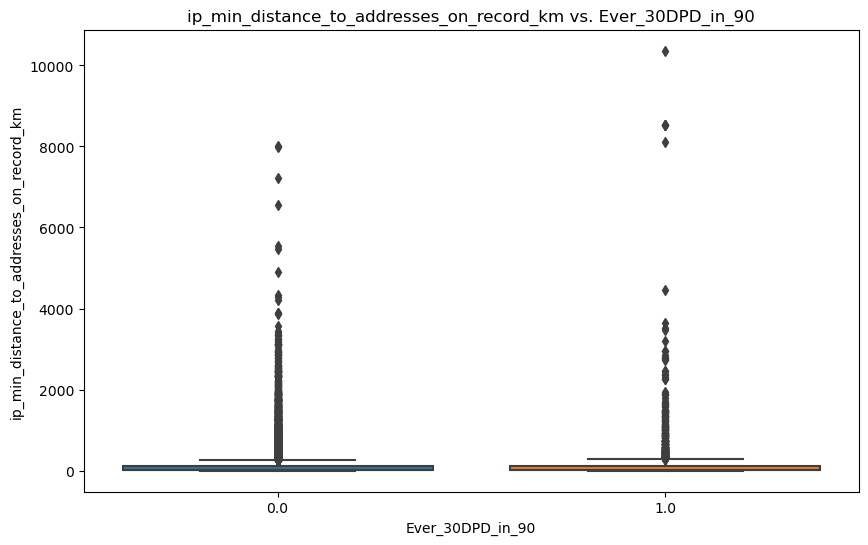

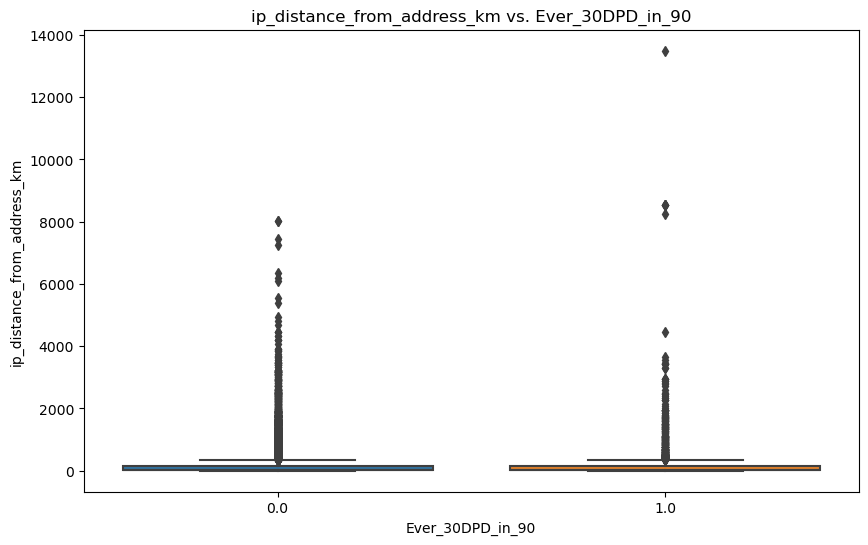

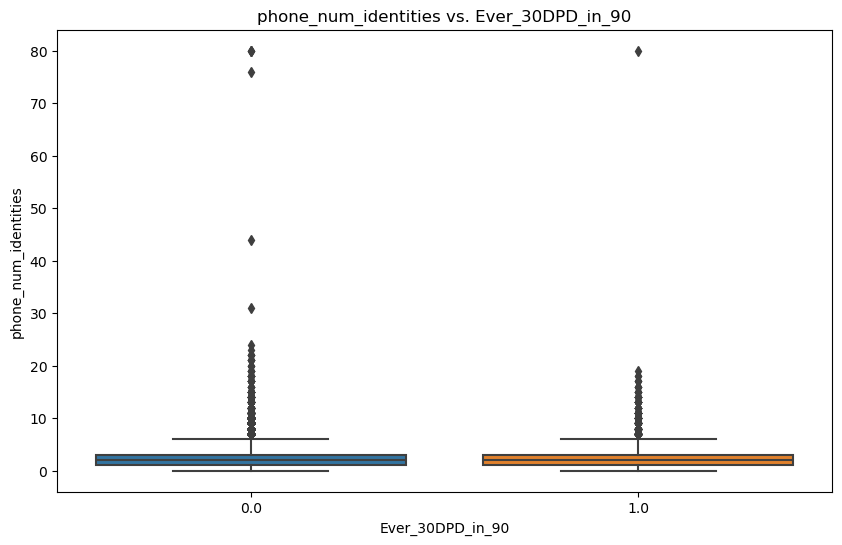

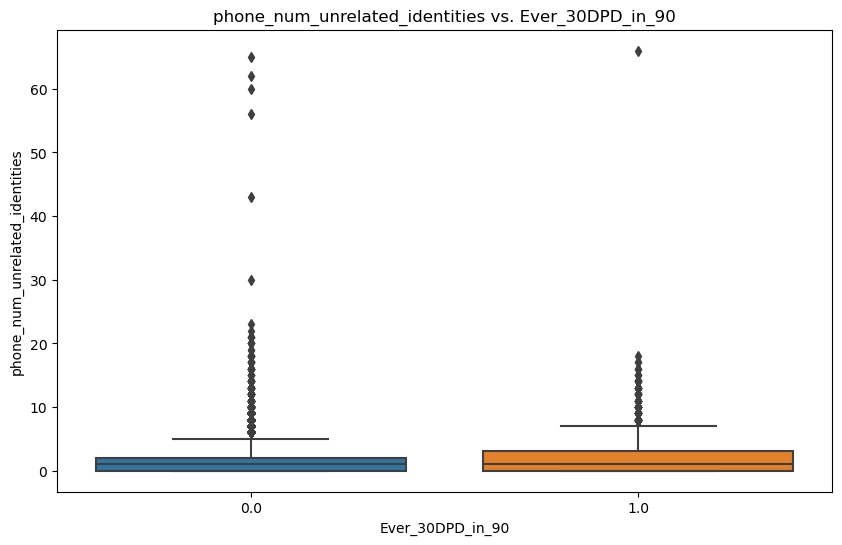

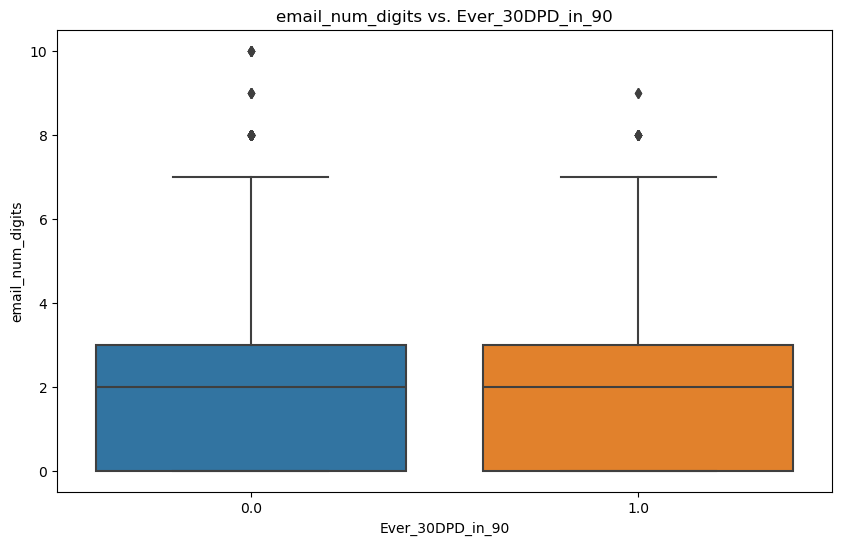

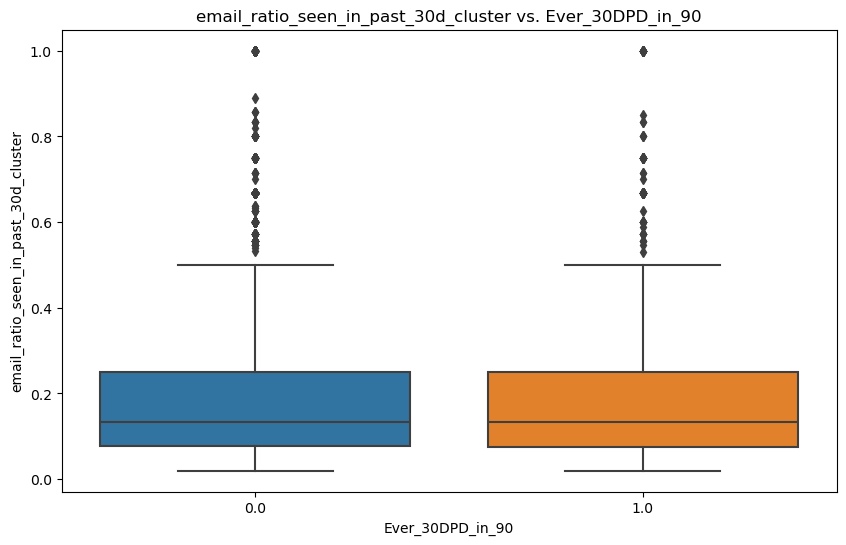

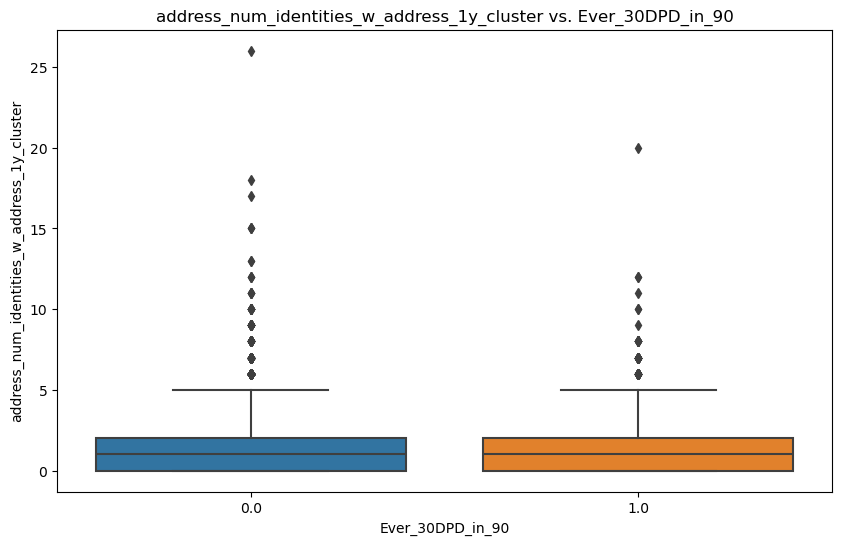

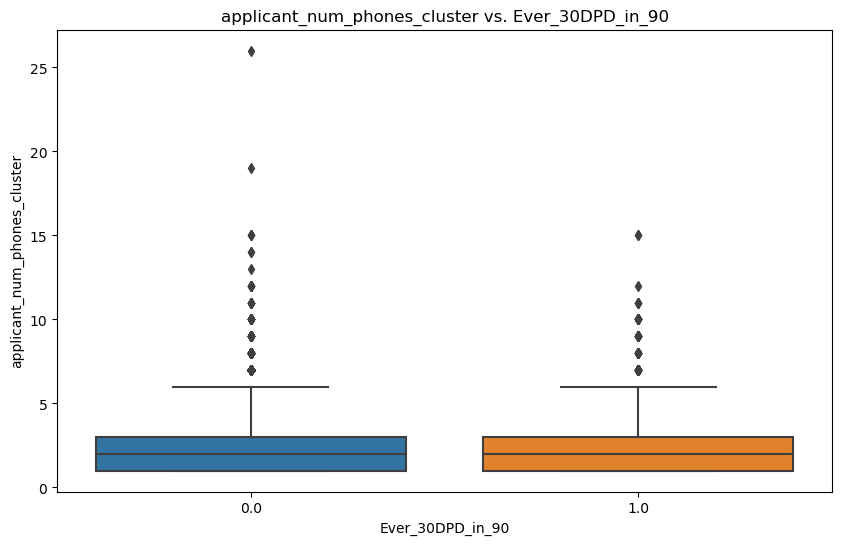

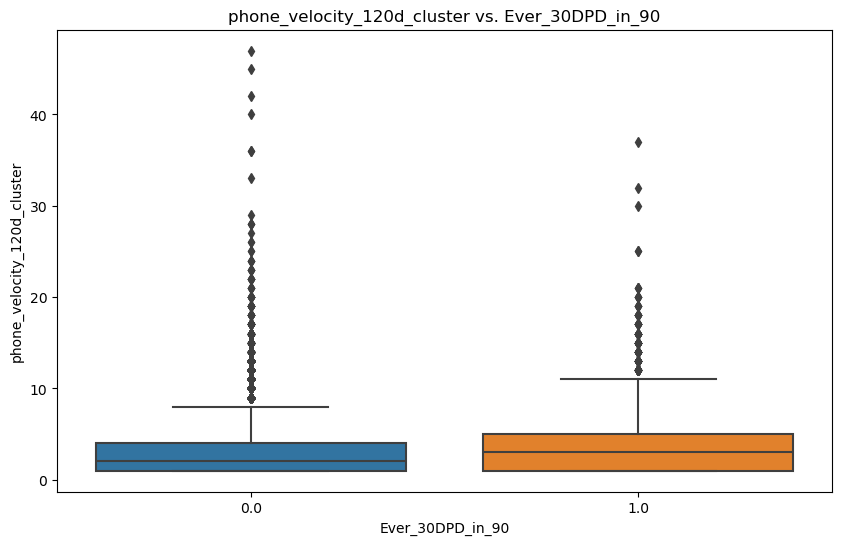

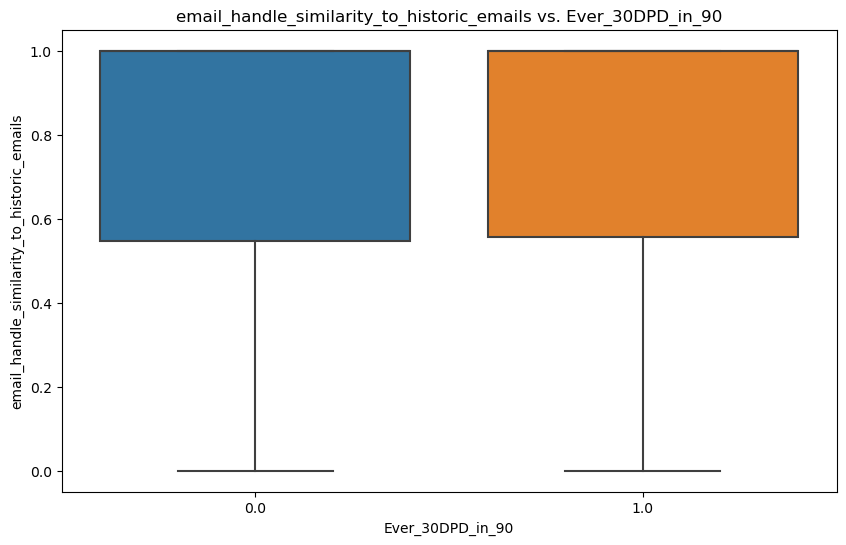

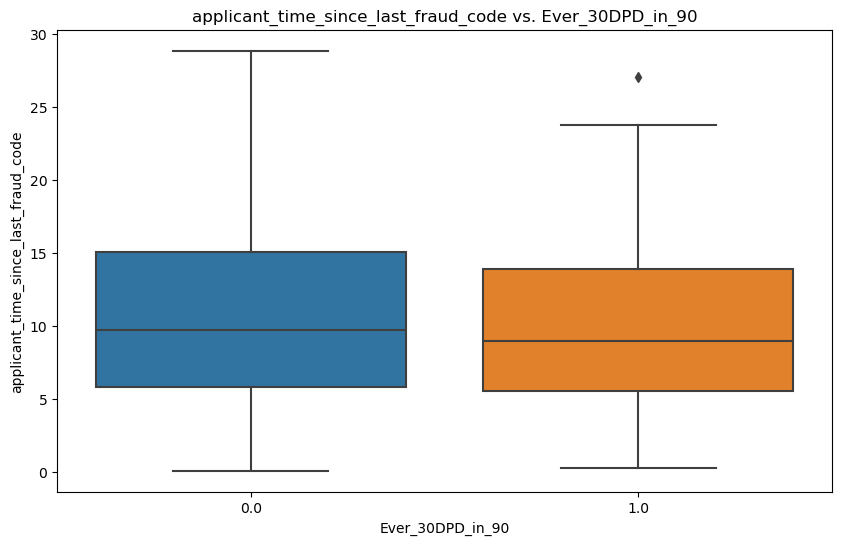

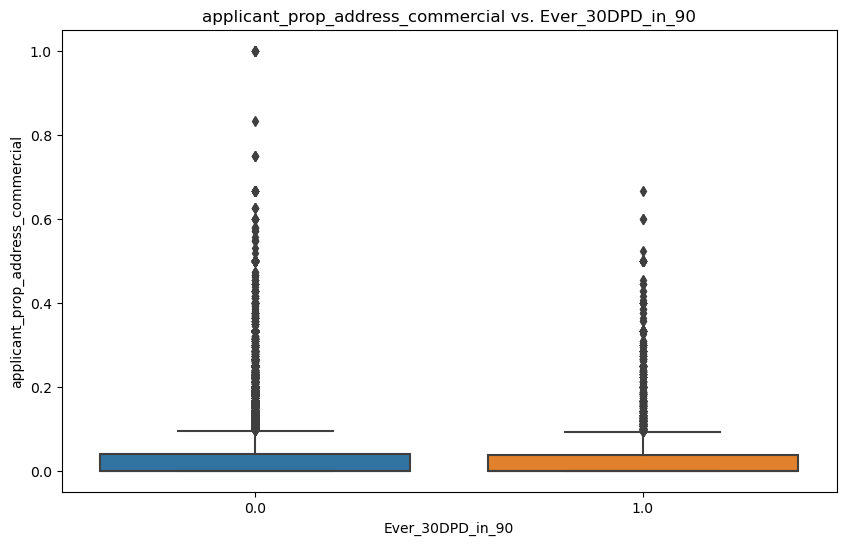

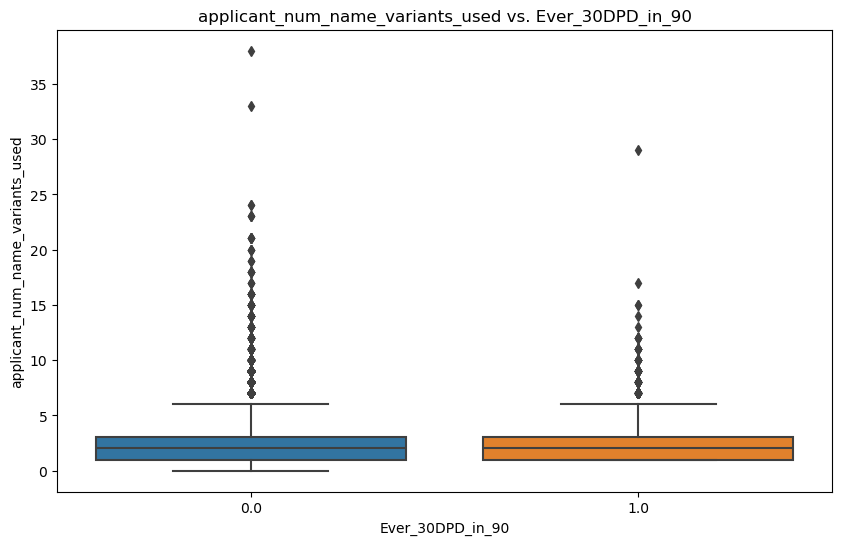

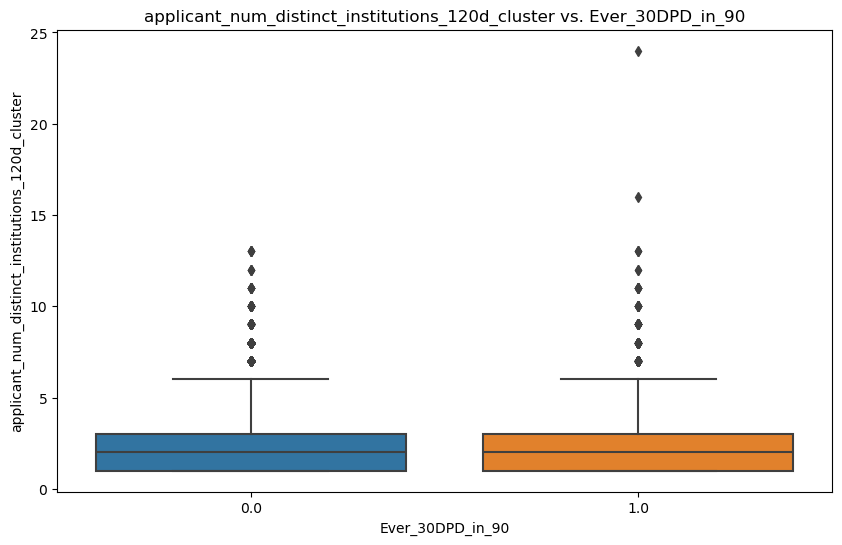

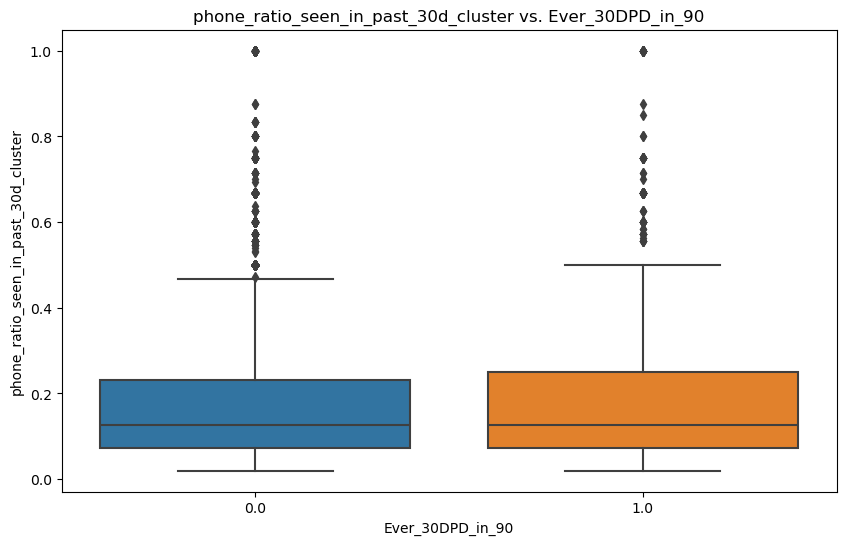

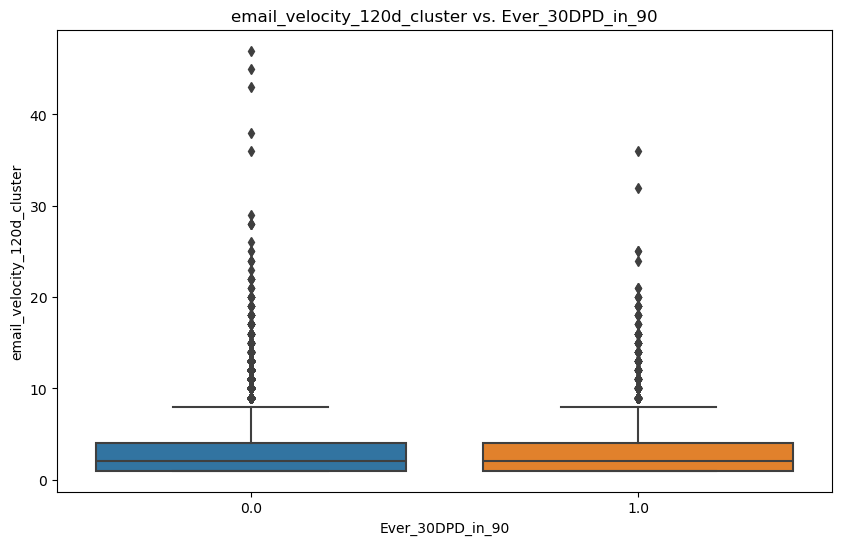

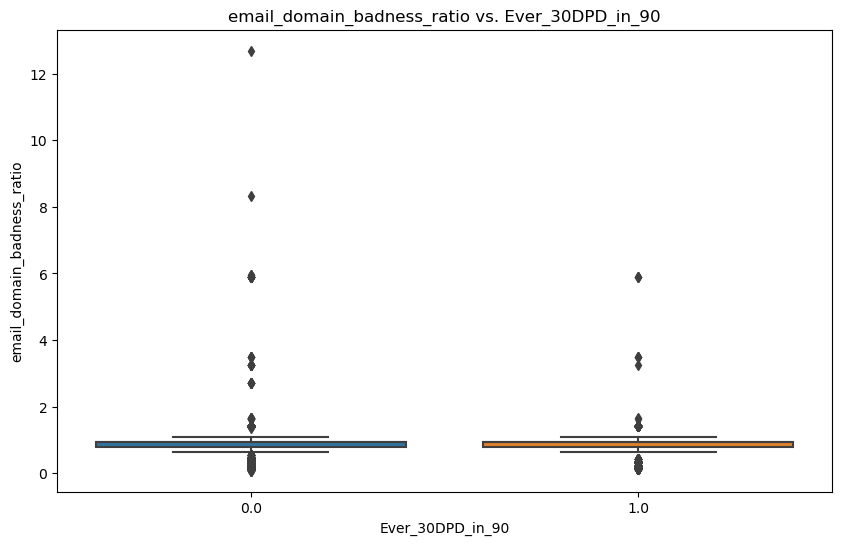

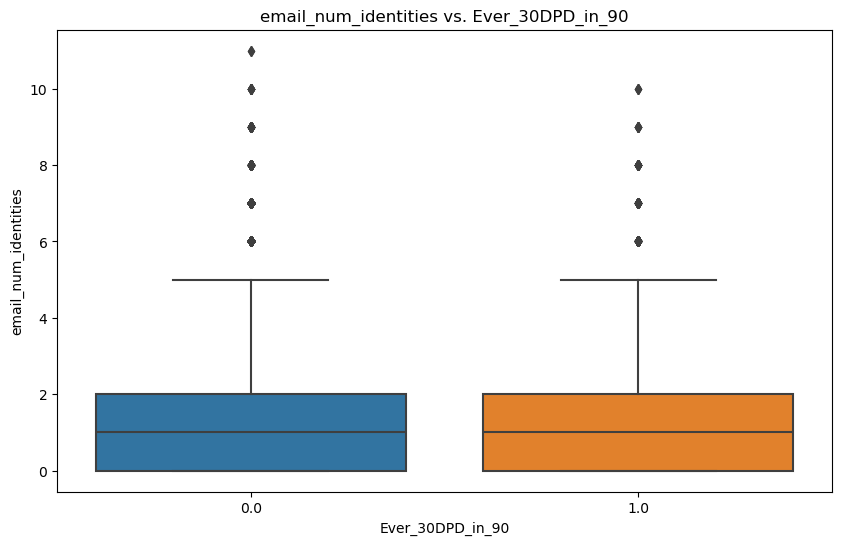

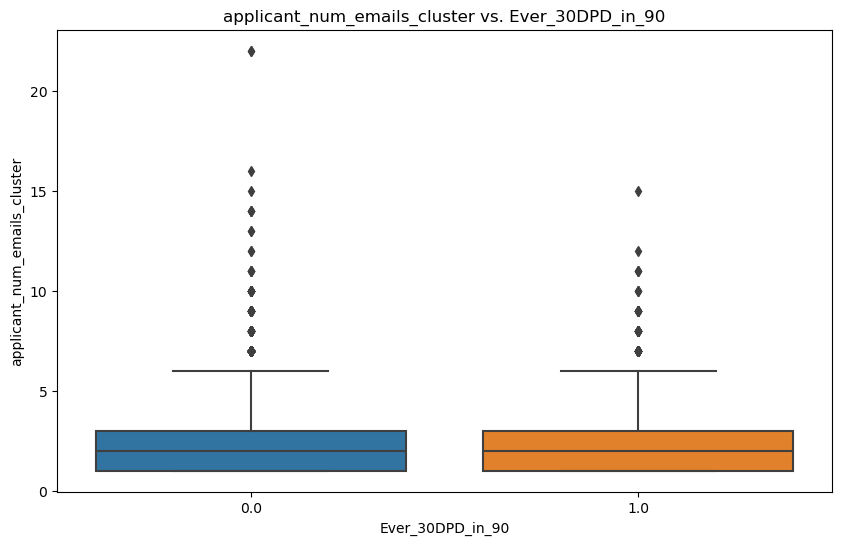

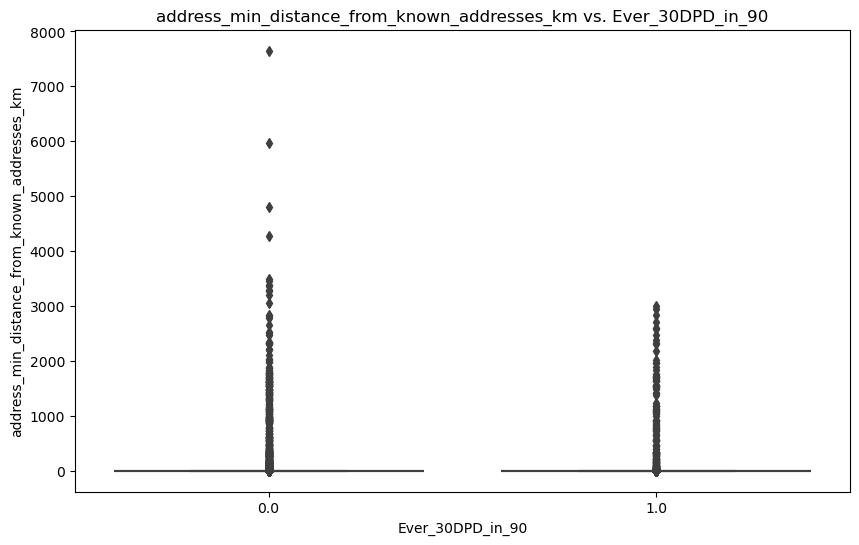

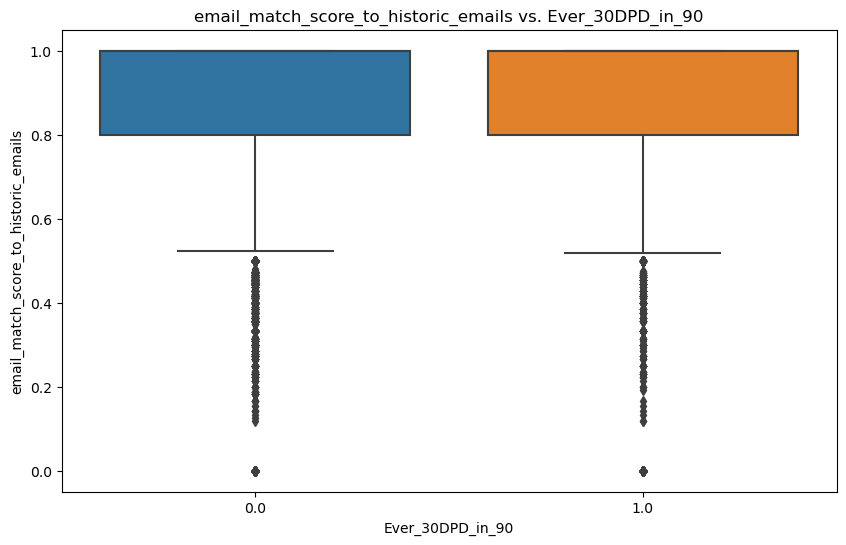

In [9]:

important_columns = [
 'email_history_yrs'                                   ,  
 'email_first_seen_w_applicant_yrs_cluster'            ,
 'applicant_oldest_address_overlapping_ssn_yrs'        ,
 'phone_history_w_applicant_yrs_cluster'               ,
 'phone_first_seen_yrs'                                ,
 'phone_history_w_applicant_yrs'                       ,
 'address_history_yrs'                                 ,
 'applicant_oldest_address_yrs'                        ,
 'applicant_max_history_yrs'                           ,
 'applicant_history_best_matching_record_yrs'          ,
 'applicant_ratio_of_apps_in_past_30d_cluster'         ,
 'phone_years_since_port'                              ,
 'email_entropy_of_address_counts_cluster'             ,
 'address_num_apps_cluster'                            ,
 'phone_entropy_of_address_counts_cluster'             ,
 'applicant_velocity_cluster'                          ,
 'phone_num_matching_addresses'                        ,
 'phone_count_cluster'                                 ,
 'applicant_history_delay_from_expected_start_yrs'     ,
 'email_count_cluster'                                 ,
 'applicant_num_addresses_overlapping_ssn'             ,
 'email_entropy_of_zipcode_counts_cluster'             ,
 'applicant_num_addresses_used'                        ,
 'applicant_ssn_delay_rarity_score'                    ,
 'phone_entropy_of_zipcode_counts_cluster'             ,
 'email_first_seen_w_applicant_yrs_manifest'           ,
 'applicant_num_emails_used_5y'                        ,
 'ssn5_end_minus_dob_yrs'                              ,
 'address_distance_from_most_recent_on_record_km'      ,
 'phone_velocity_1y_cluster'                           ,
 'email_velocity_1y_cluster'                           ,
 'applicant_num_addresses_used_5y'                     ,
 'ssn5_start_minus_dob_yrs'                            ,
 'applicant_num_records_w_partial_match'               ,
 'ssn_address_state_mismatch_score'                    ,
 'applicant_num_phones_used_5y'                        ,
 'ip_min_distance_to_addresses_on_record_km'           ,
 'ip_distance_from_address_km'                         ,
 'phone_num_identities'                                ,
 'phone_num_unrelated_identities'                      ,
 'email_num_digits'                                    ,
 'email_ratio_seen_in_past_30d_cluster'                ,
 'address_num_identities_w_address_1y_cluster'         ,
 'applicant_num_phones_cluster'                        ,
 'phone_velocity_120d_cluster'                         ,
 'email_handle_similarity_to_historic_emails'          ,
 'applicant_time_since_last_fraud_code'                ,
 'applicant_prop_address_commercial'                   ,
 'applicant_num_name_variants_used'                    ,
 'applicant_num_distinct_institutions_120d_cluster'    ,
 'phone_ratio_seen_in_past_30d_cluster'                ,
 'email_velocity_120d_cluster'                         ,
 'email_domain_badness_ratio'                          ,
 'email_num_identities'                                ,
 'applicant_num_emails_cluster'                        ,
 'address_min_distance_from_known_addresses_km'        ,
 'email_match_score_to_historic_emails'                
]

plot_relationships(final_df, 'Ever_30DPD_in_90', important_columns)

In [10]:
dpd_features = ['email_history_yrs',
                'email_first_seen_w_applicant_yrs_cluster',
                'applicant_oldest_address_overlapping_ssn_yrs',
                'phone_history_w_applicant_yrs_cluster',
                'phone_history_w_applicant_yrs',
                'address_history_yrs',
                'applicant_oldest_address_yrs',
                'applicant_max_history_yrs',
                'applicant_history_best_matching_record_yrs',
                'phone_years_since_port',
                'email_entropy_of_address_counts_cluster',
                'phone_entropy_of_address_counts_cluster',
                'applicant_history_delay_from_expected_start_yrs',
                'email_entropy_of_zipcode_counts_cluster',
                'phone_entropy_of_zipcode_counts_cluster',
                'ssn5_end_minus_dob_yrs',
                'applicant_num_addresses_used_5y',
                'ssn5_start_minus_dob_yrs',
                'applicant_num_phones_used_5y',
                'address_num_identities_w_address_1y_cluster',
                'applicant_num_phones_cluster',
                'applicant_time_since_last_fraud_code',
                'applicant_num_distinct_institutions_120d_cluster',
                'applicant_num_emails_cluster',
                'address_min_distance_from_known_addresses_km'
               ]

In [ ]:
def create_unique_bins(feature_data, target_data, initial_bins=10):
    bins = initial_bins
    while bins > 1:
        bin_edges = np.histogram_bin_edges(feature_data.dropna(), bins=bins)
        if len(bin_edges) == len(set(bin_edges)):
            break
        bins -= 1
    bin_labels = pd.cut(feature_data, bins=bin_edges, include_lowest=True, labels=range(len(bin_edges)-1))
    bin_means = target_data.groupby(bin_labels).mean()
    return bin_edges, bin_means

def plot_feature_buckets(data, target_col, features):
    for feature in features:
        feature_data = data[feature]
        target_data = data[target_col]
        bin_edges, bin_means = create_unique_bins(feature_data, target_data)
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(bin_means)), bin_means, tick_label=[f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in
                                                             range(len(bin_edges)-1)])
        plt.xlabel(f'{feature} Bins')
        plt.ylabel(f'Mean {target_col}')
        plt.title(f'{feature} vs. Mean {target_col}')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
def decile_buckets(df, icolumns, fpd_column, dpd_column):
    for column in icolumns:
        df['decile'] = pd.qcut(df[column].rank(method='first'), 10, labels=False) + 1
        stats = df.groupby(['decile', fpd_column])[column].agg(['count']).reset_index()
        stats_pivot = stats.pivot(index='decile', columns=fpd_column, values=['count']).reset_index()
        stats_pivot.columns = ['decile', 'count_0', 'count_1']
        stats_pivot.fillna({'count_0': 0, 'count_1': 0}, inplace=True)
        stats_pivot['total'] = stats_pivot['count_0'] + stats_pivot['count_1']
        stats_pivot['default_rate'] = stats_pivot['count_1'] / stats_pivot['total'] * 100
        stats_interval = df.groupby('decile')[column].agg(['min', 'max']).reset_index()
        result = pd.merge(stats_interval, stats_pivot,  on='decile')
        dpd_stats = df.groupby('decile')[dpd_column].mean().reset_index()
        result = pd.merge(result, dpd_stats, on='decile')
        print(f'{column}')
        print(result)


In [ ]:
feature_buckets = decile_buckets(final_df, dpd_features, 'isFPD', 'Ever_30DPD_in_90')

In [11]:
def decile_buckets(df, icolumns, fpd_column, dpd_column):
    feature_buckets = {}
    for col in icolumns:
        if col not in df.columns:
            continue
        df['decile'] = pd.qcut(df[col].rank(method='first'), 10, labels=False) + 1
        decile_df = df.groupby('decile').agg(
            min_value=(col, 'min'),
            max_value=(col, 'max'),
            default_rate=(fpd_column, 'mean'),
            ever_30dpd=(dpd_column, 'mean')
        ).reset_index()
        decile_df['feature'] = col
        feature_buckets[col] = decile_df
    return feature_buckets

feature_buckets = decile_buckets(final_df, dpd_features, 'isFPD', 'Ever_30DPD_in_90')
print(feature_buckets)


{'email_history_yrs':    decile  min_value  max_value  default_rate  ever_30dpd            feature
0     1.0   0.000000   2.015058      0.103088    0.169387  email_history_yrs
1     2.0   2.015058   3.868583      0.092240    0.138979  email_history_yrs
2     3.0   3.868583   5.508556      0.091711    0.148770  email_history_yrs
3     4.0   5.508556   6.956879      0.088662    0.134128  email_history_yrs
4     5.0   6.956879   8.232717      0.091275    0.141565  email_history_yrs
5     6.0   8.232717  10.036961      0.087260    0.145012  email_history_yrs
6     7.0  10.036961  11.060917      0.075453    0.128186  email_history_yrs
7     8.0  11.060917  12.531143      0.083383    0.139051  email_history_yrs
8     9.0  12.531143  14.206708      0.078539    0.127837  email_history_yrs
9    10.0  14.206708  17.538672      0.073399    0.112107  email_history_yrs, 'email_first_seen_w_applicant_yrs_cluster':    decile  min_value    max_value  default_rate  ever_30dpd  \
0     1.0   0.000000   

In [12]:
import openpyxl
from openpyxl.drawing.image import Image 
import os

def write_to_excel_with_graphs(feature_buckets, output_file):
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        sheet_index = 0
        
        for feature, df in feature_buckets.items():
            sheet_name = f'Features {sheet_index // 5 + 1}'
            startrow = (sheet_index % 5) * 15
            df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)
            
            plt.figure(figsize=(8, 6))
            plt.bar(df['decile'], df['ever_30dpd'])
            plt.xlabel('Decile')
            plt.ylabel('Ever_30dpd_in_90')
            
            image_path = f'{feature}.png'
            plt.savefig(image_path)
            plt.close()
            workbook = writer.book
            worksheet = workbook[sheet_name]
            img = openpyxl.drawing.image.Image(image_path)
            img.anchor = f'I{startrow + 1}'
            worksheet.add_image(img)
            sheet_index += 1
            
    for feature in feature_buckets.keys():
        os.remove(f'{feature}.png')

In [ ]:
output_file = 'feature_buckets.xlsx'
write_to_excel_with_graphs(feature_buckets, output_file)

In [ ]:
#final_df = pd.read_pickle('Sentilink_df.pkl')

## Graph features that show the best trends relating to dpd/fpd
### Look at isoriginated and do the same as for dpd/fpd
#### Check features against TUrs/mkscore and see if the features within Sentilink offer anything suggestive for defaults

## 3.2 isOrigination 

In [13]:
columns_drop_2 = ['isFPD', 'base_loan_id', 'Ever_30DPD_in_90', 'decision', 'lead_sequence_id']
final_df_iso = final_df.drop(columns=columns_drop_2)

In [ ]:
final_df_iso

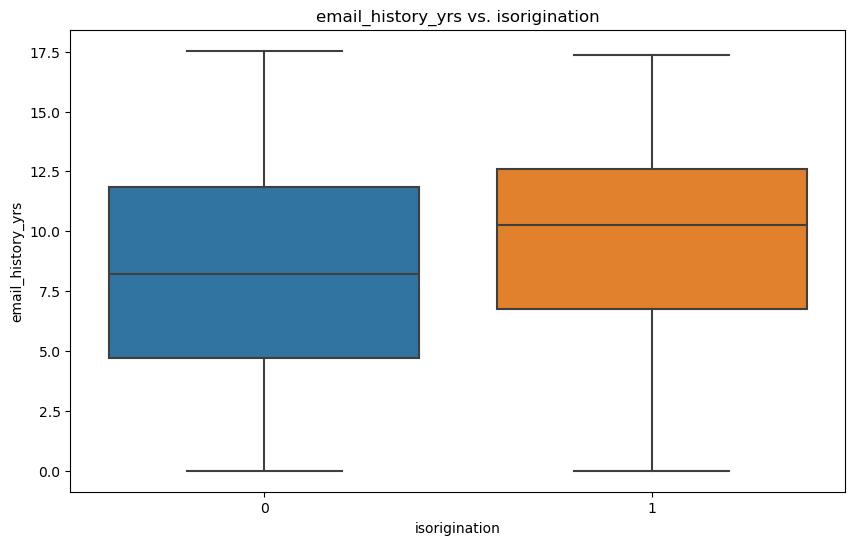

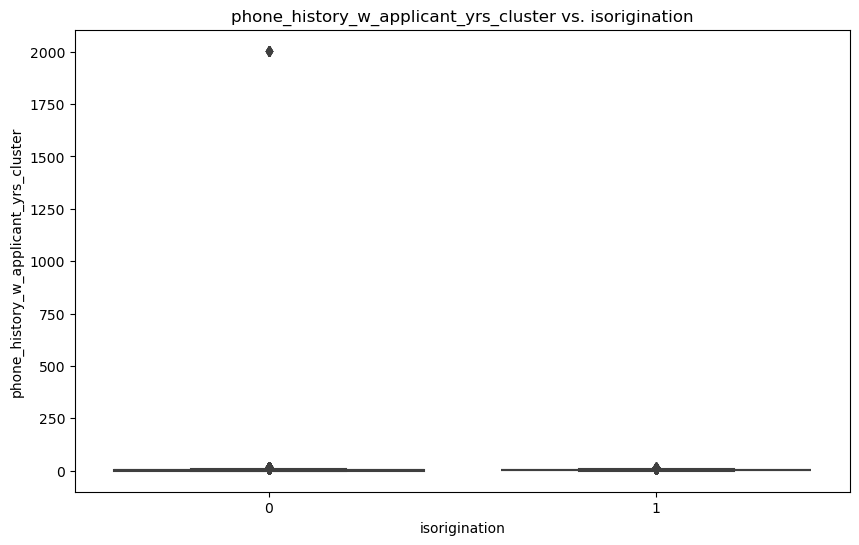

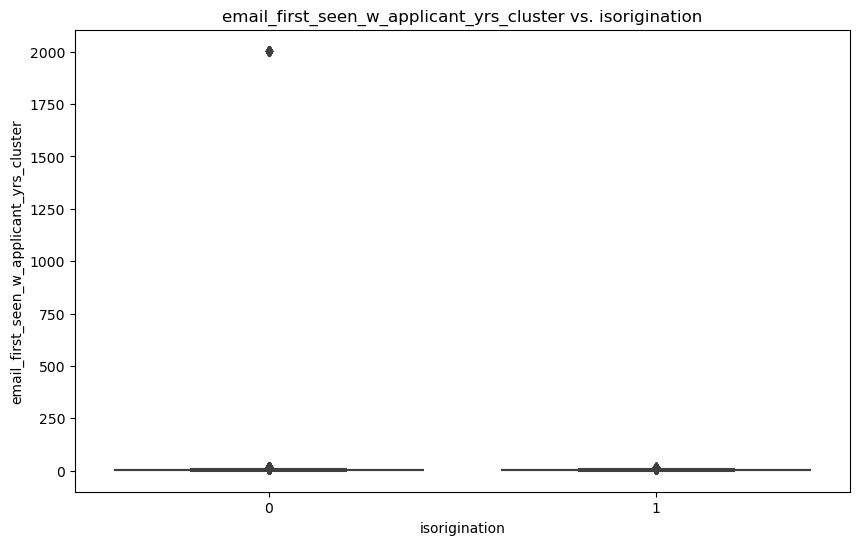

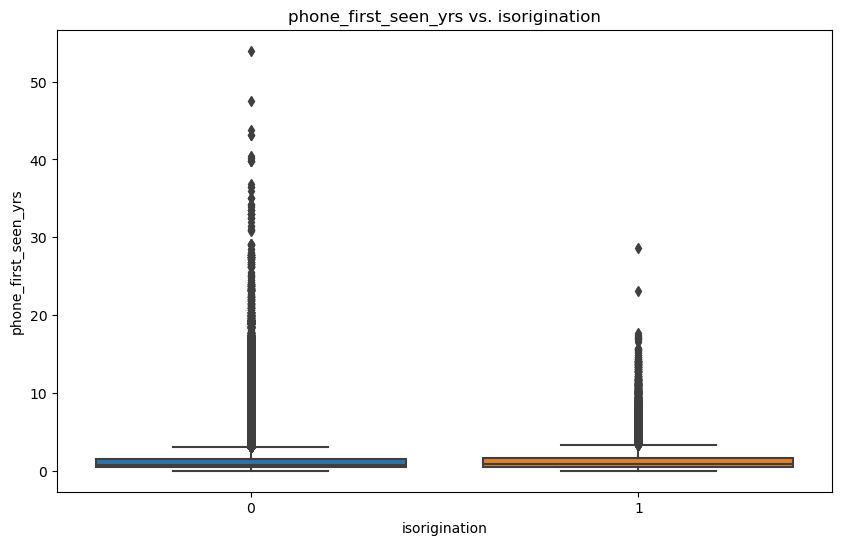

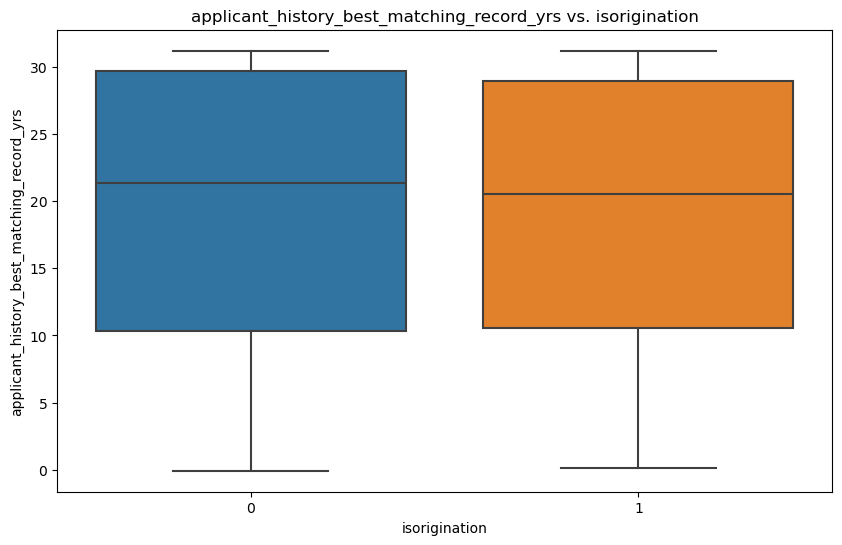

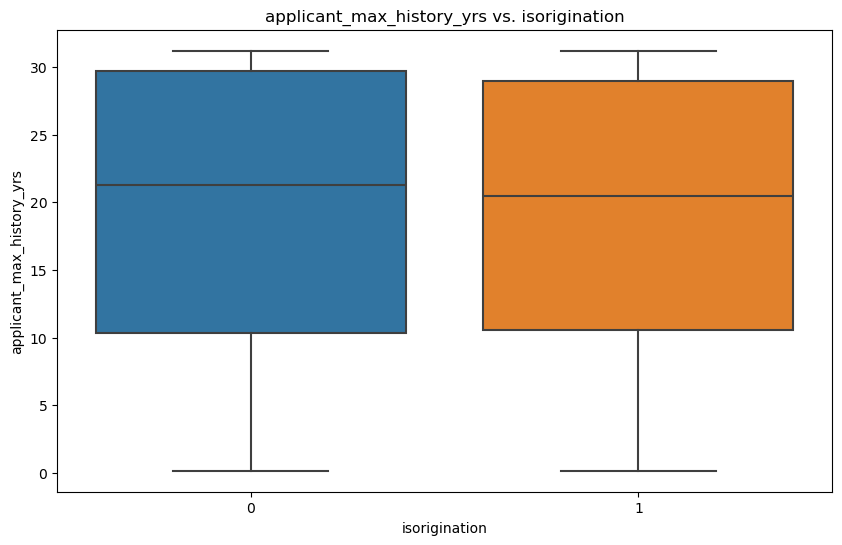

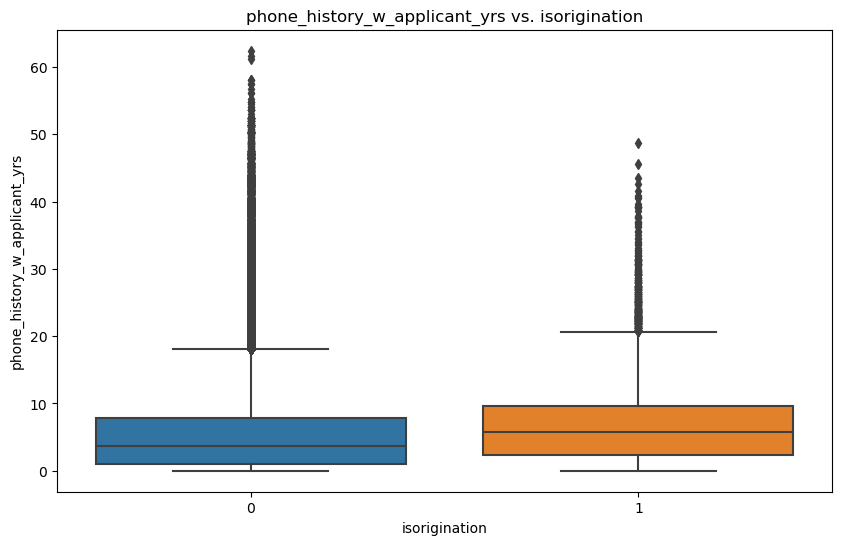

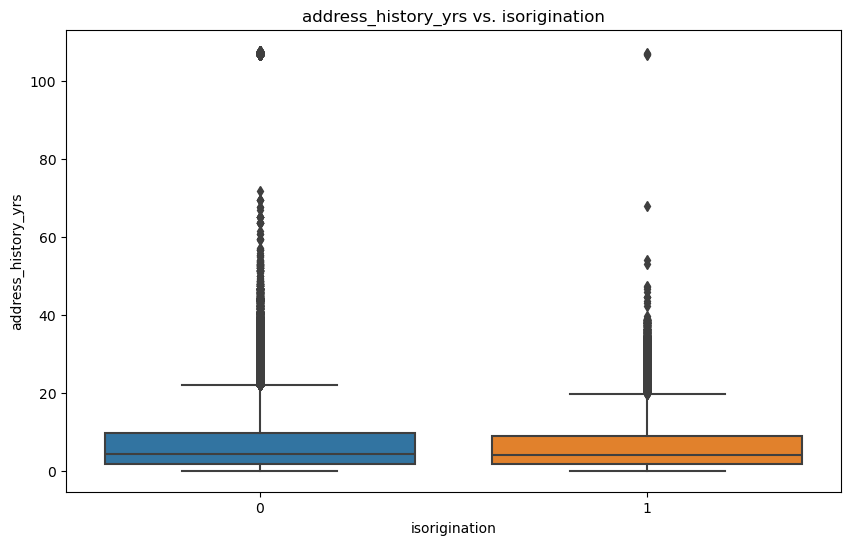

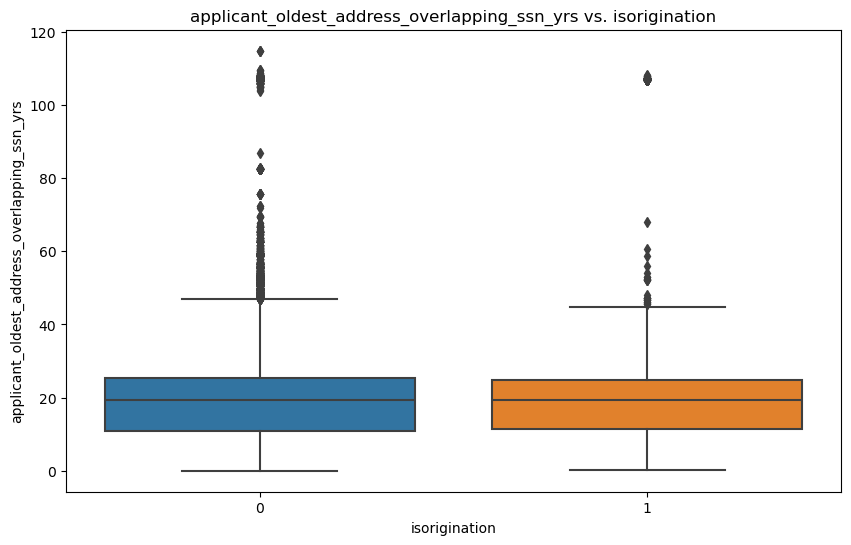

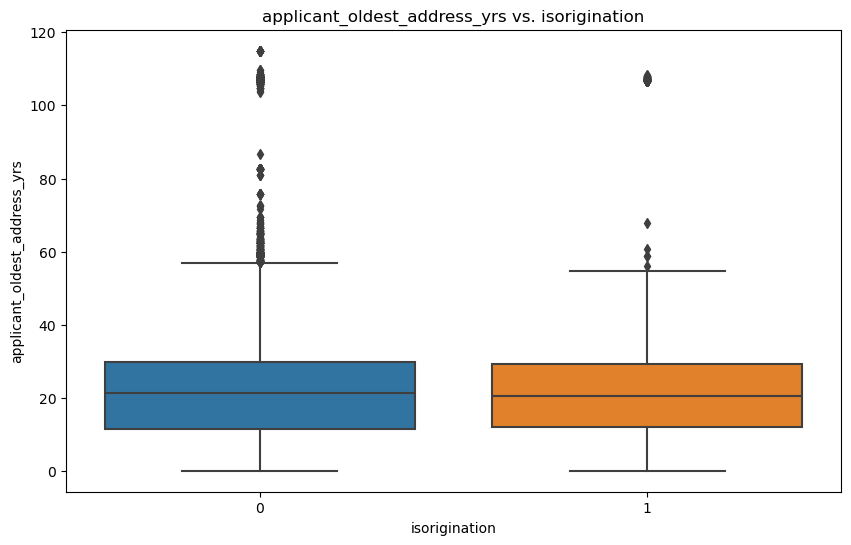

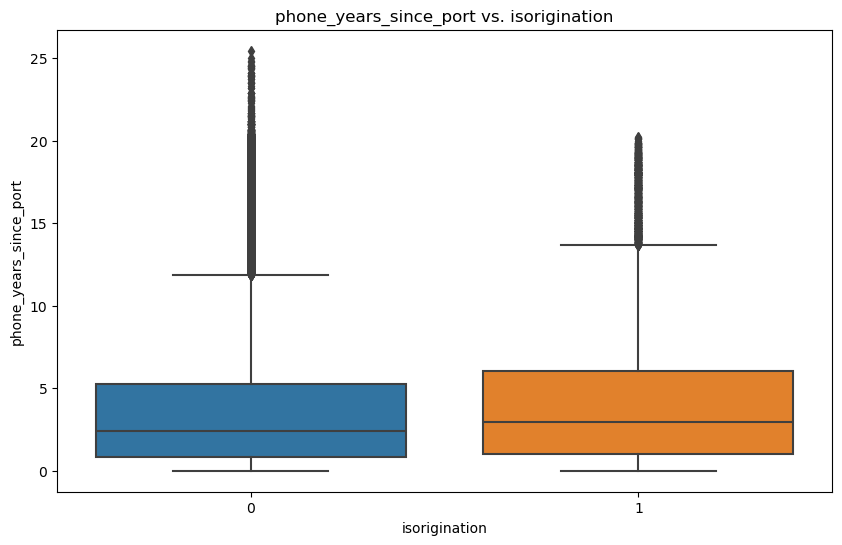

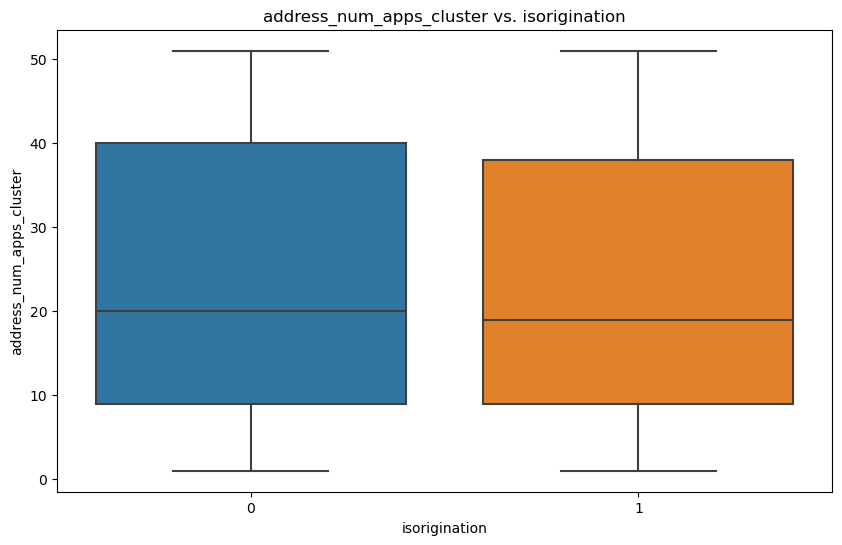

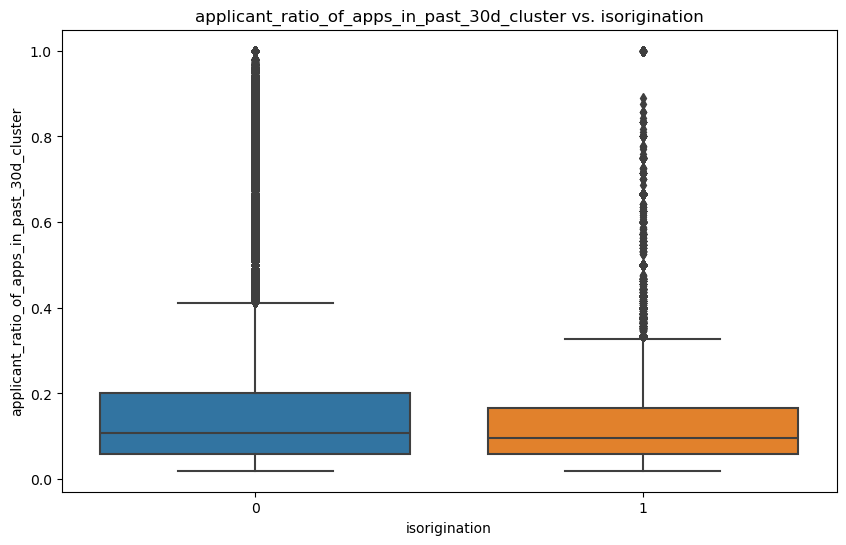

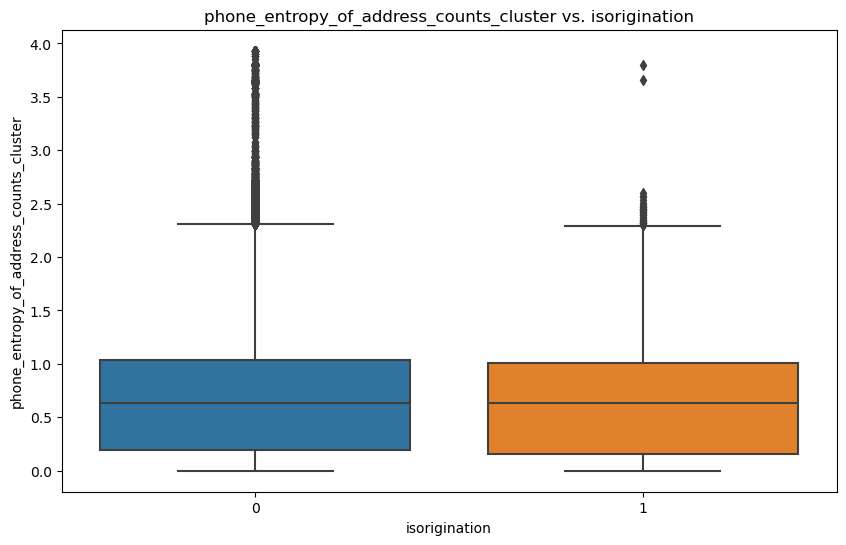

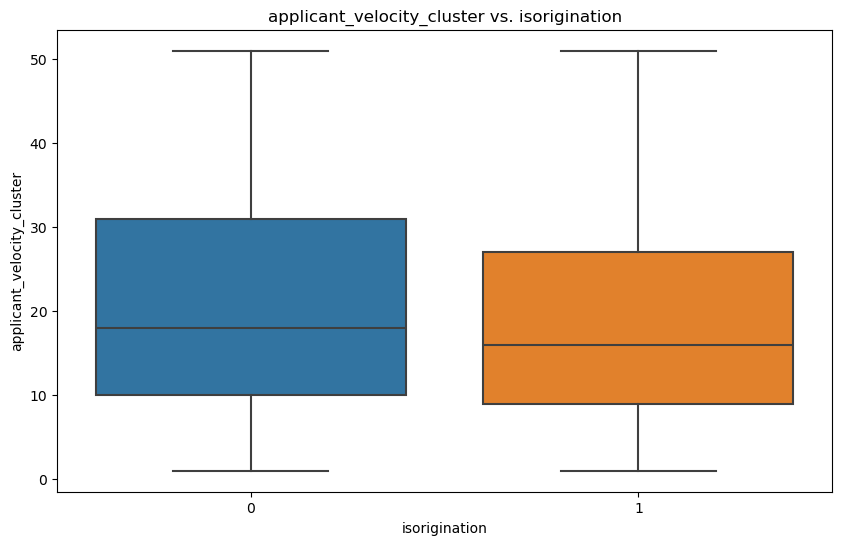

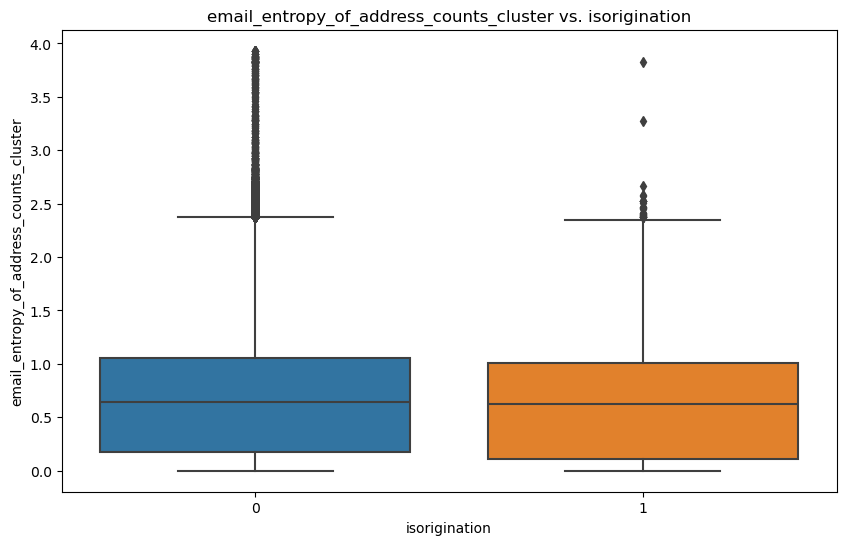

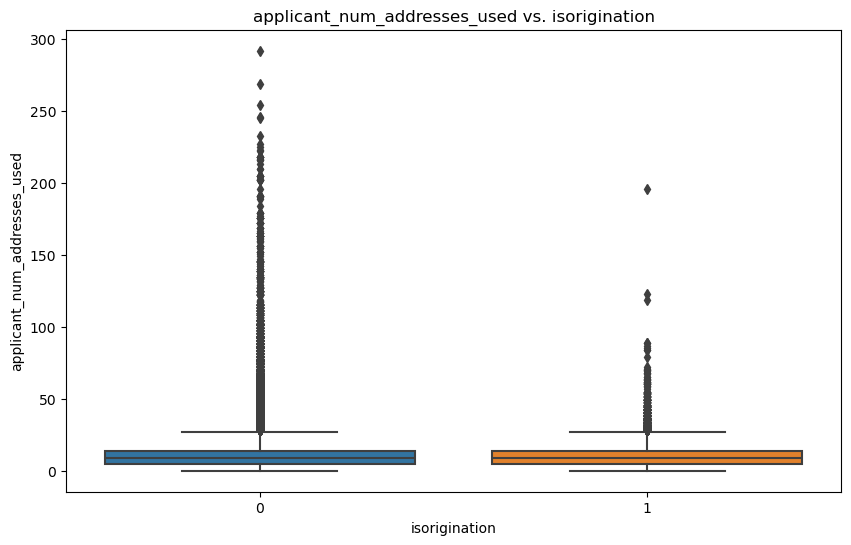

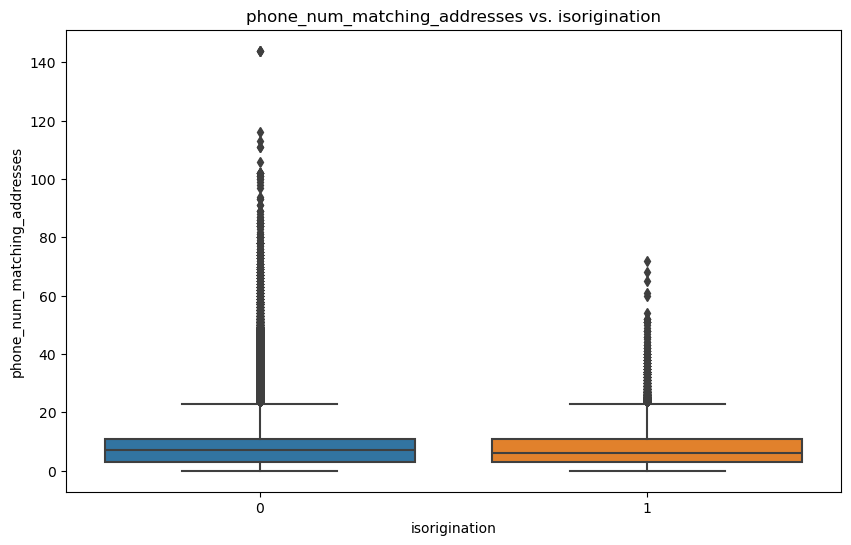

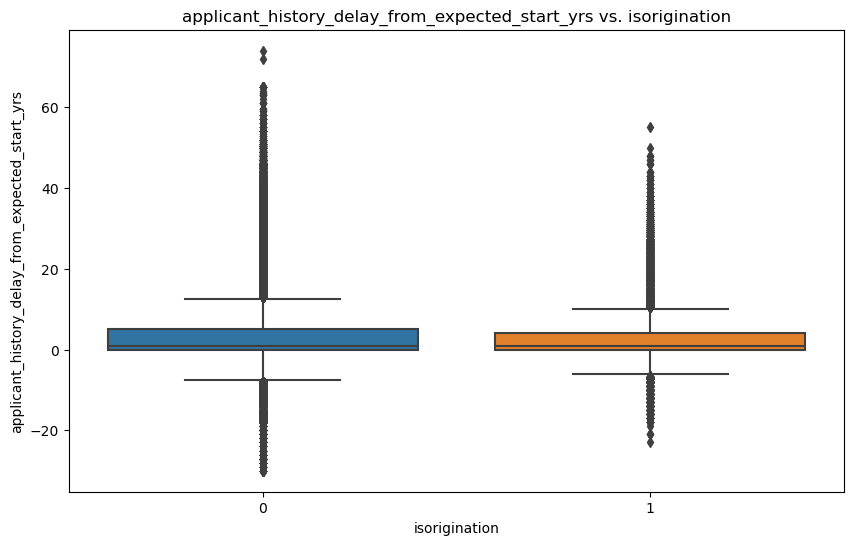

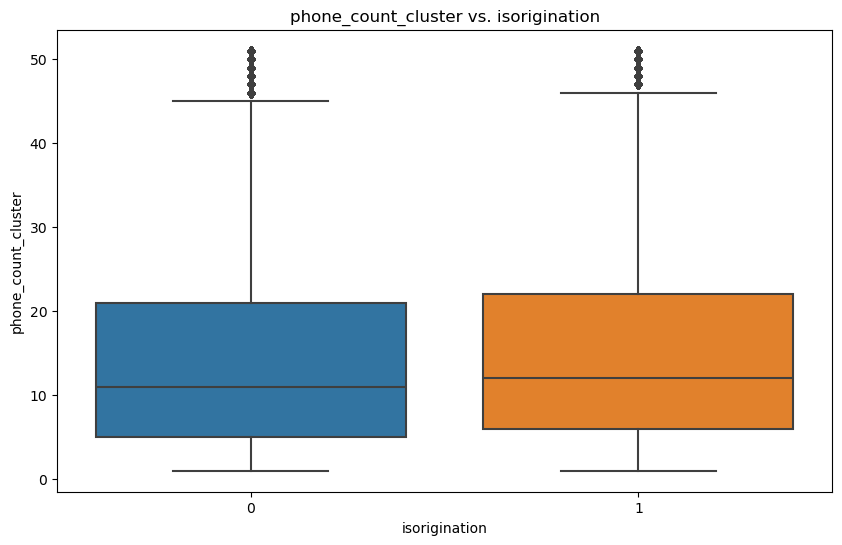

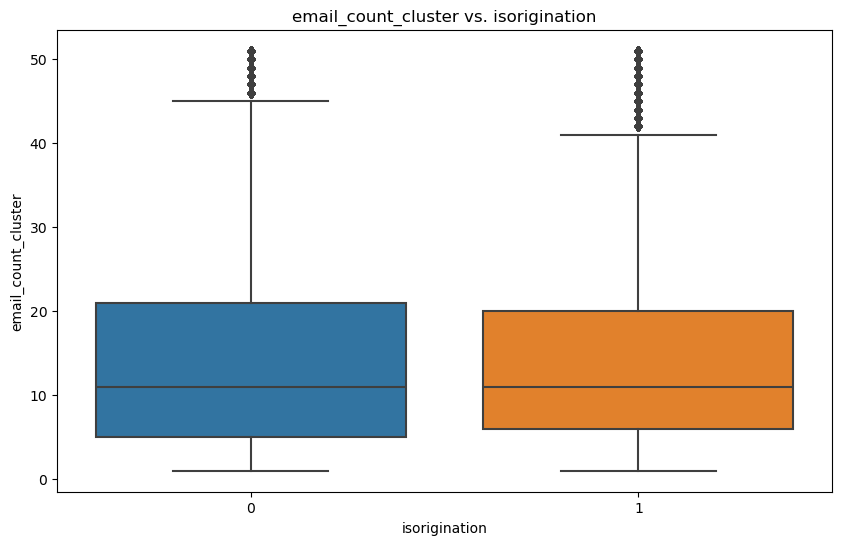

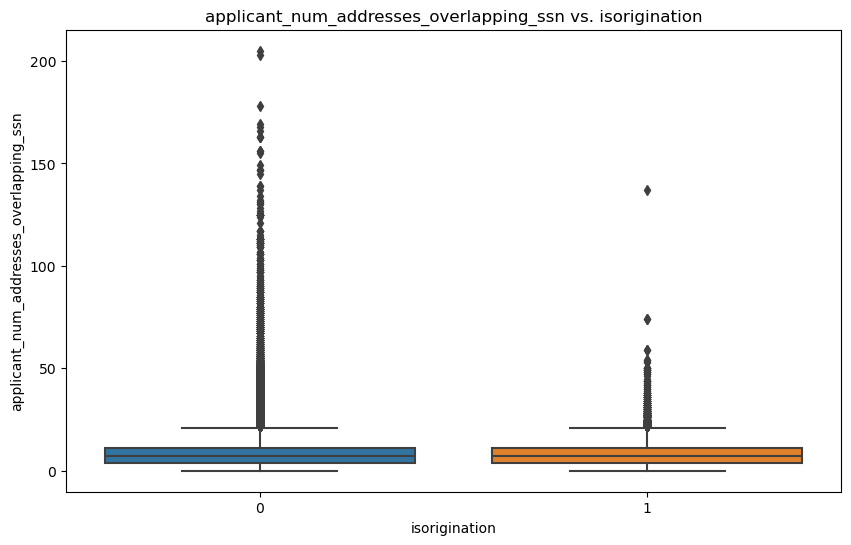

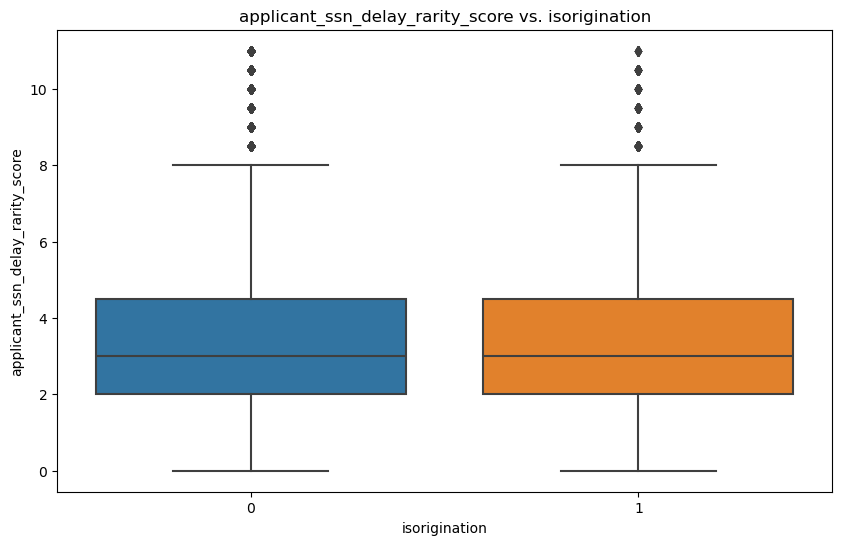

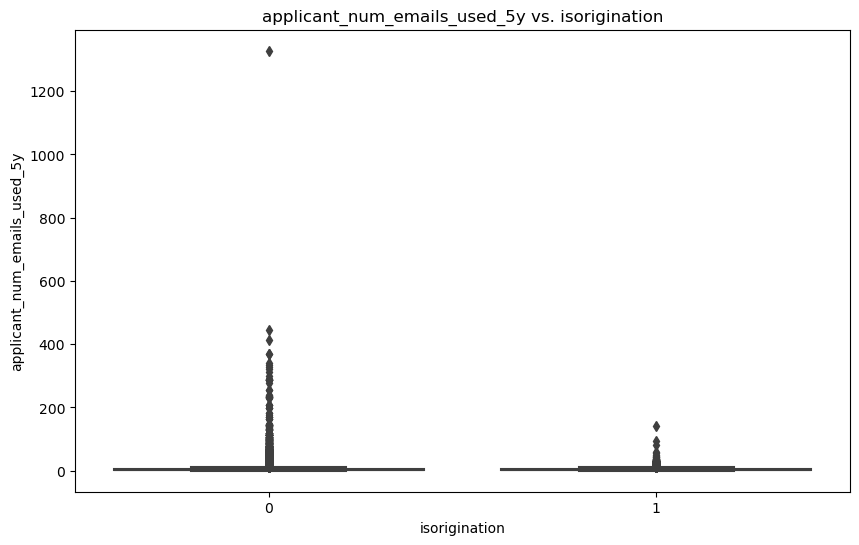

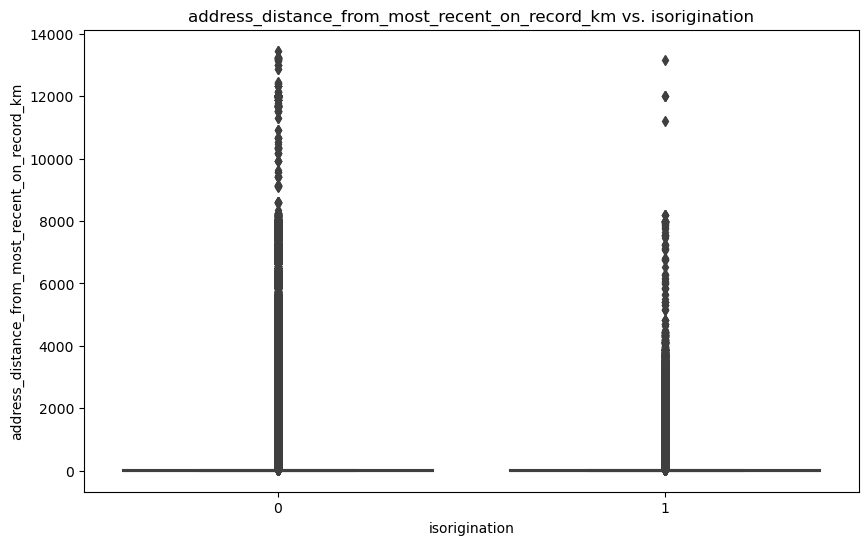

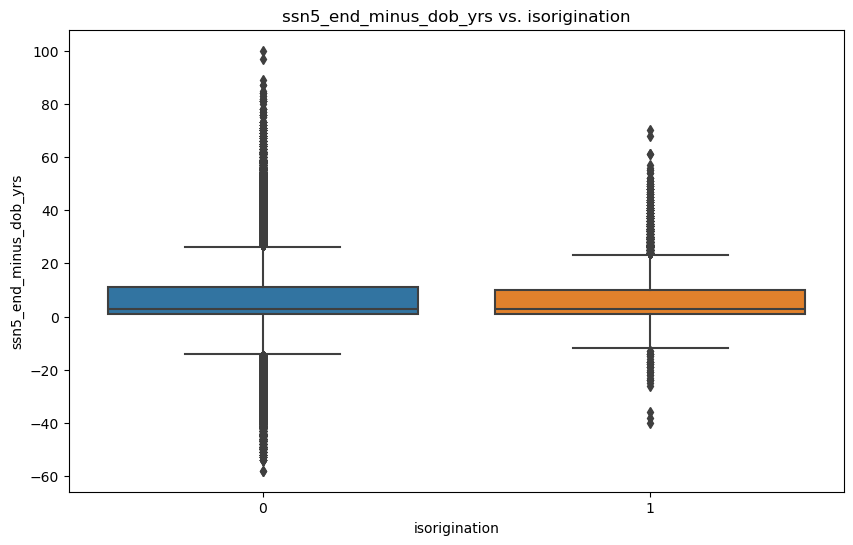

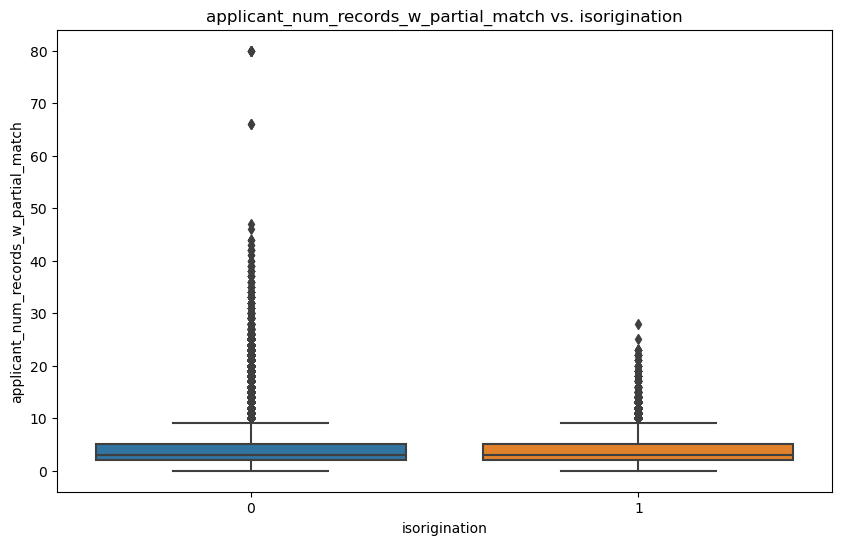

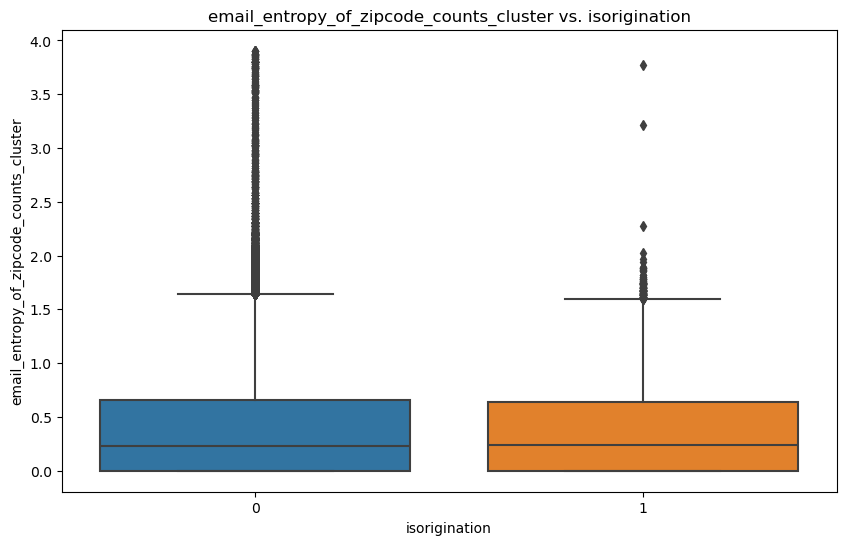

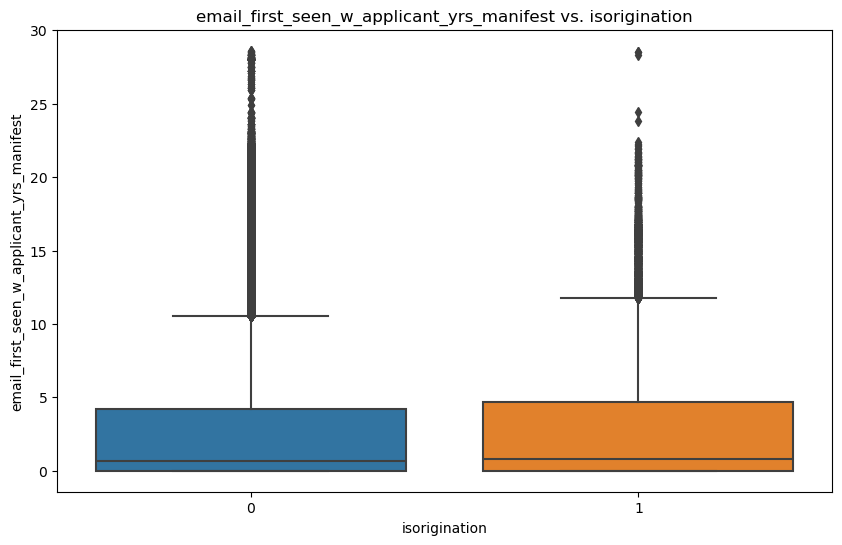

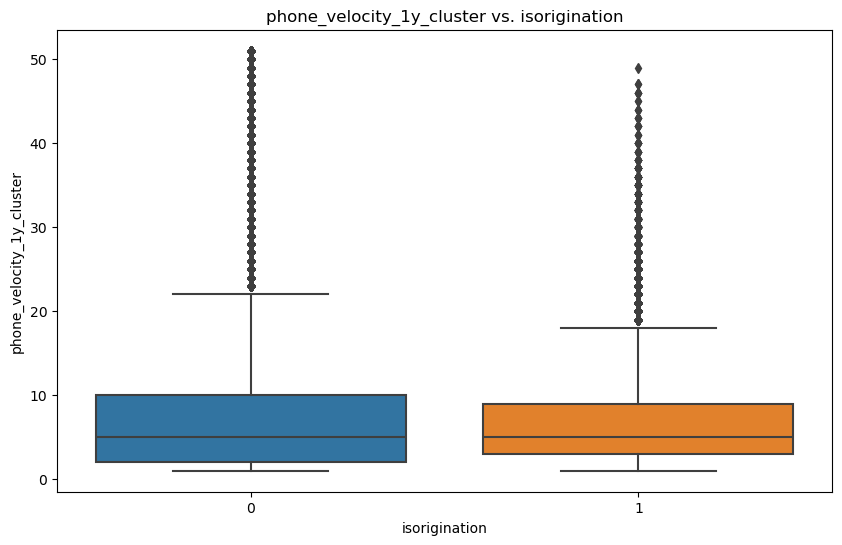

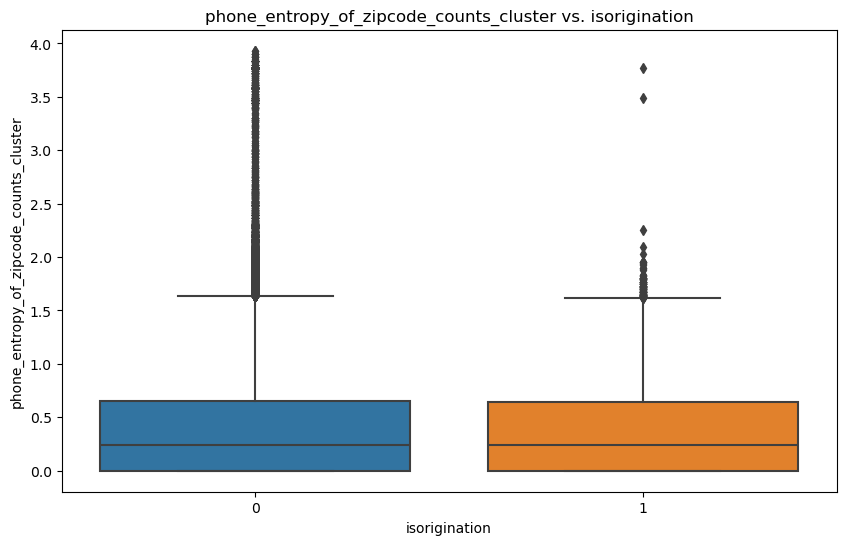

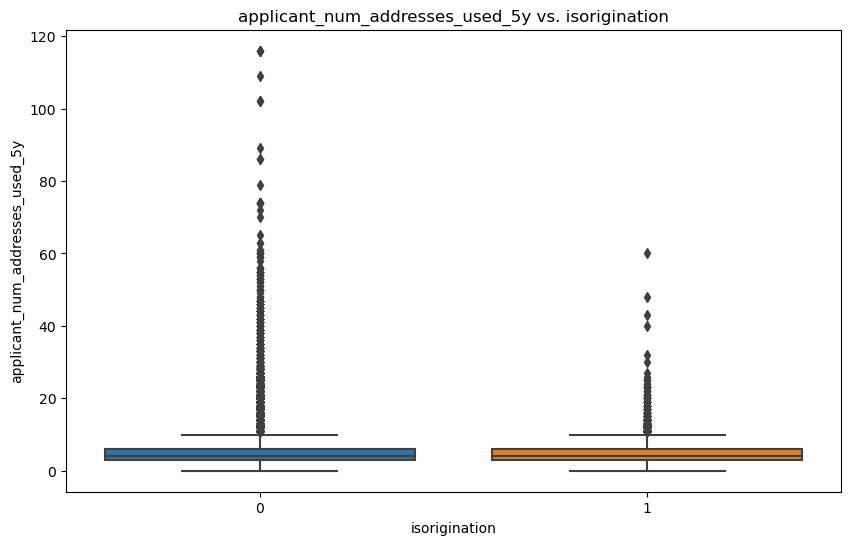

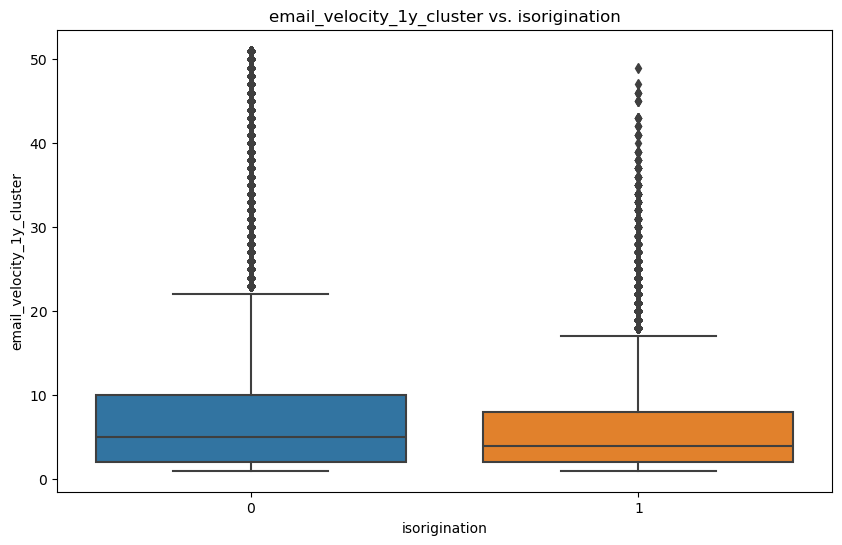

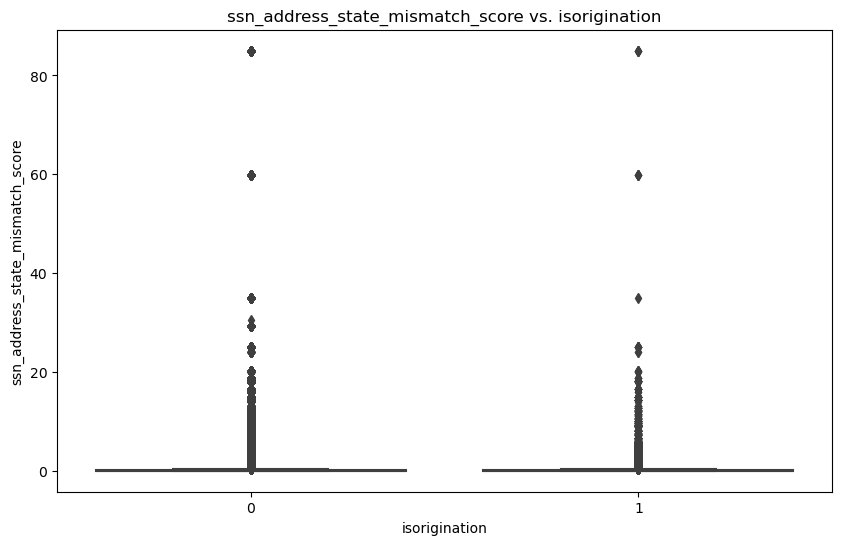

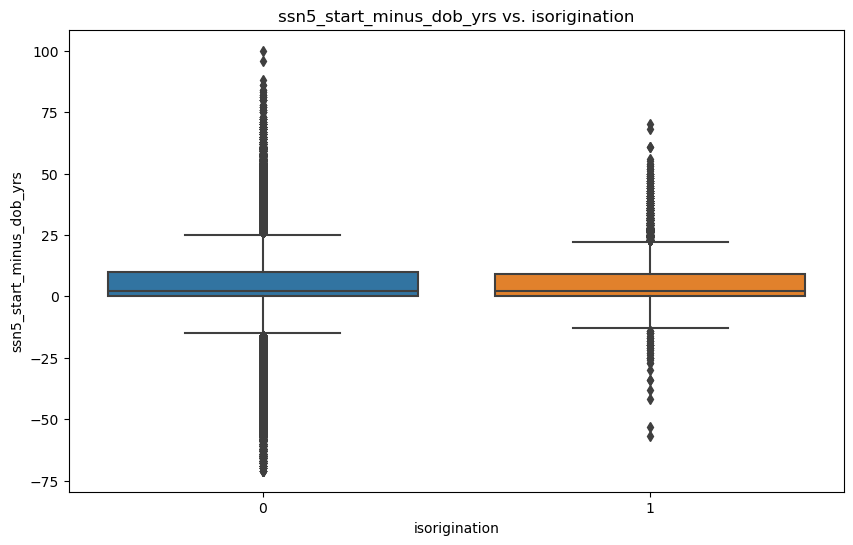

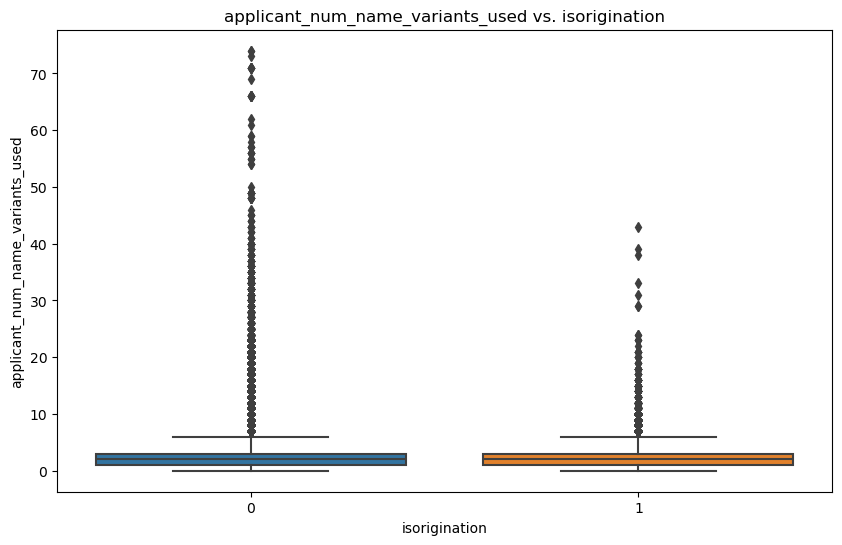

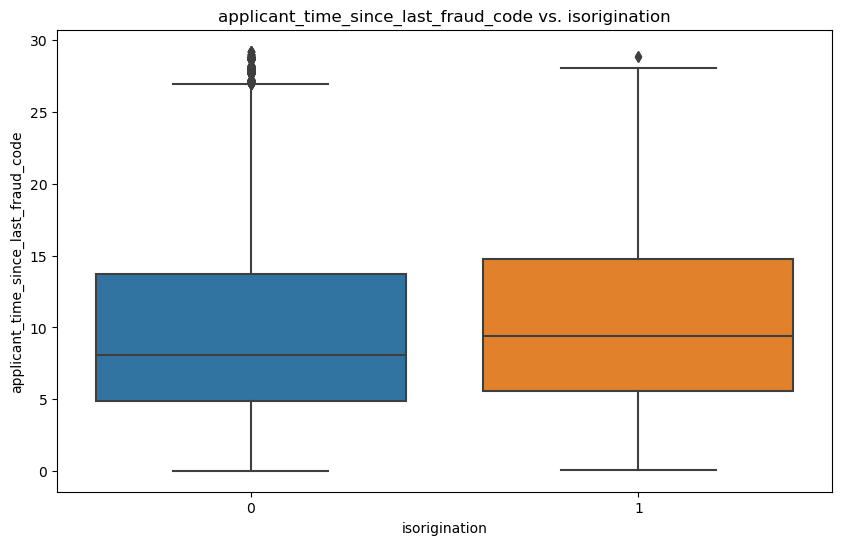

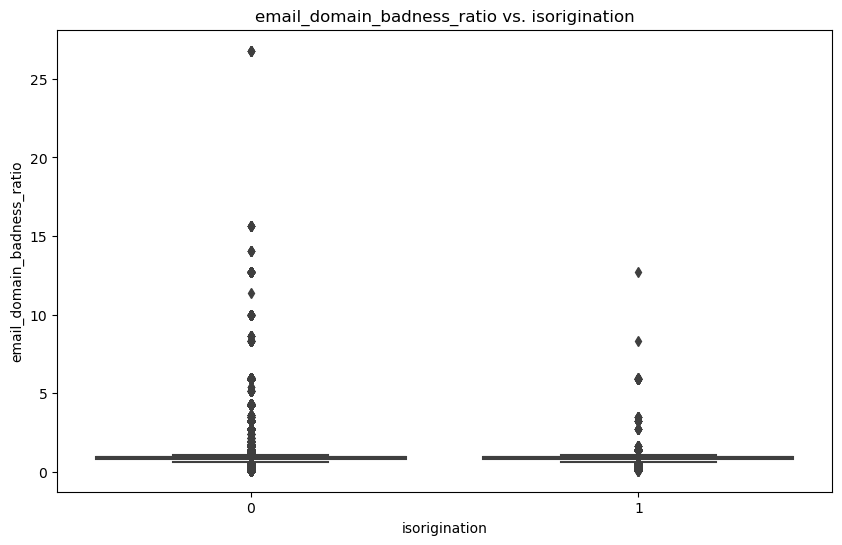

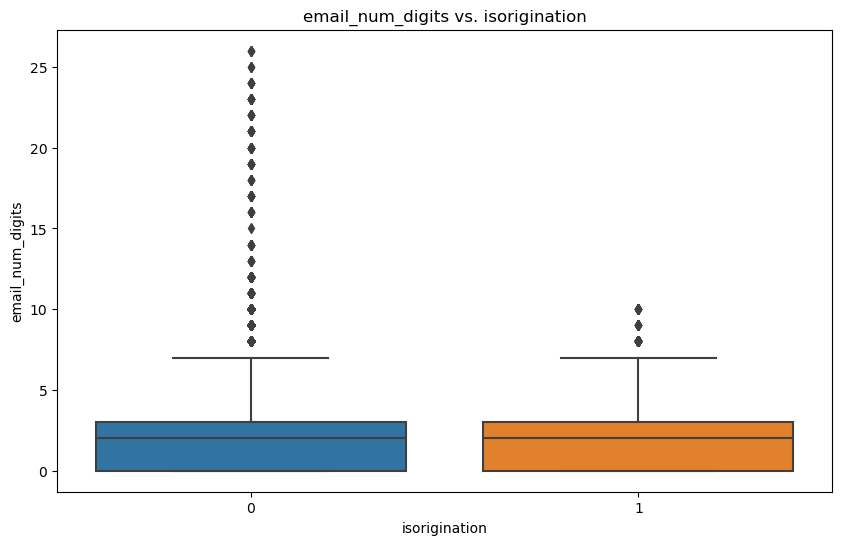

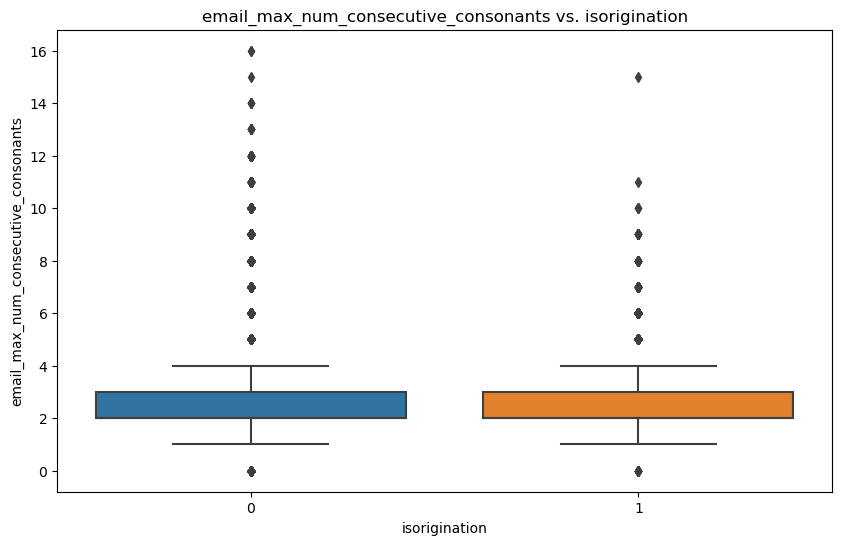

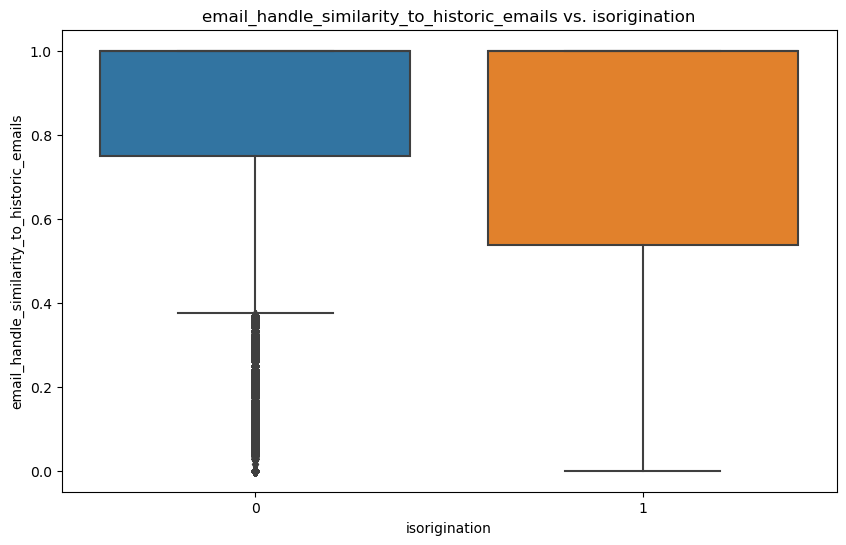

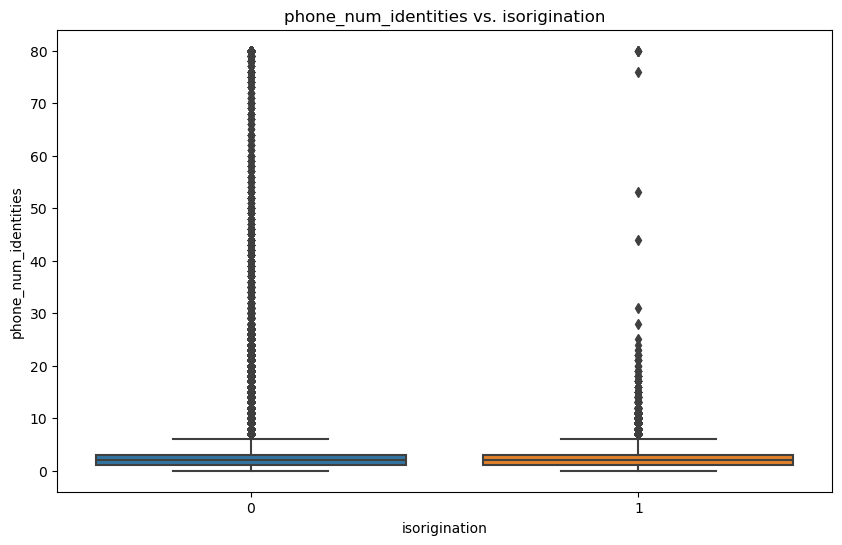

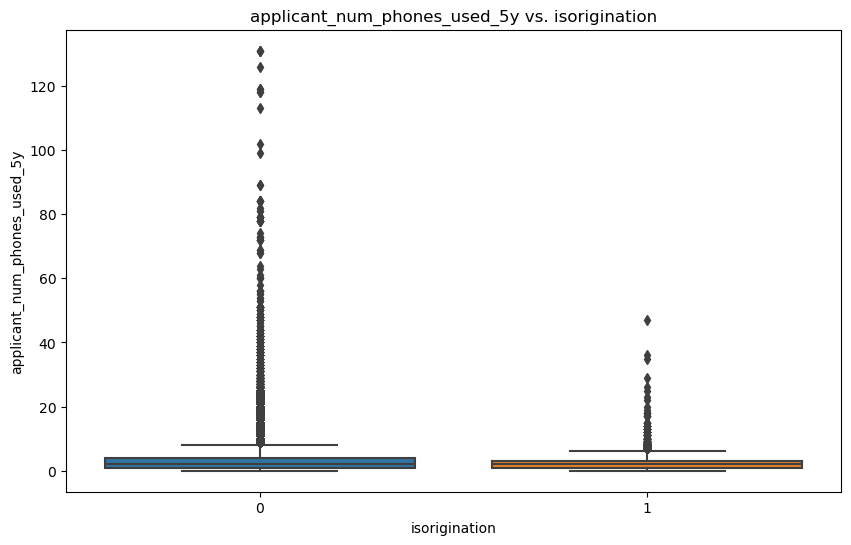

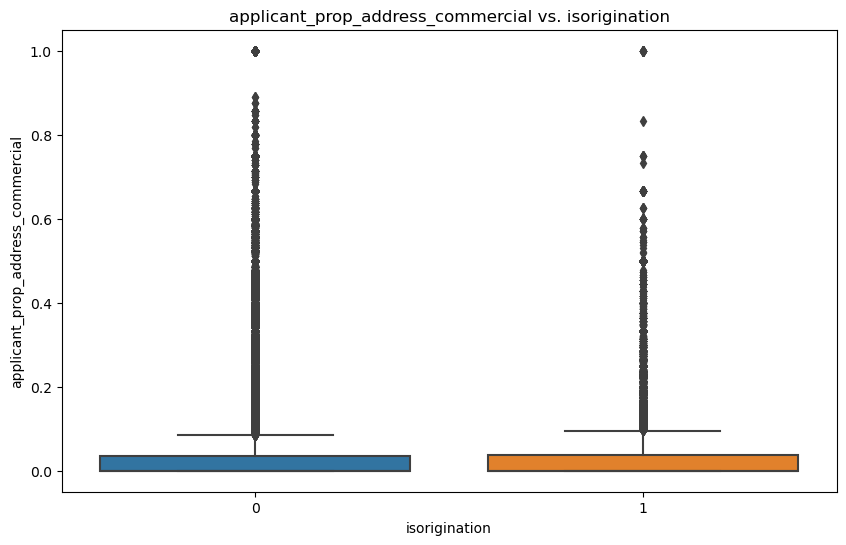

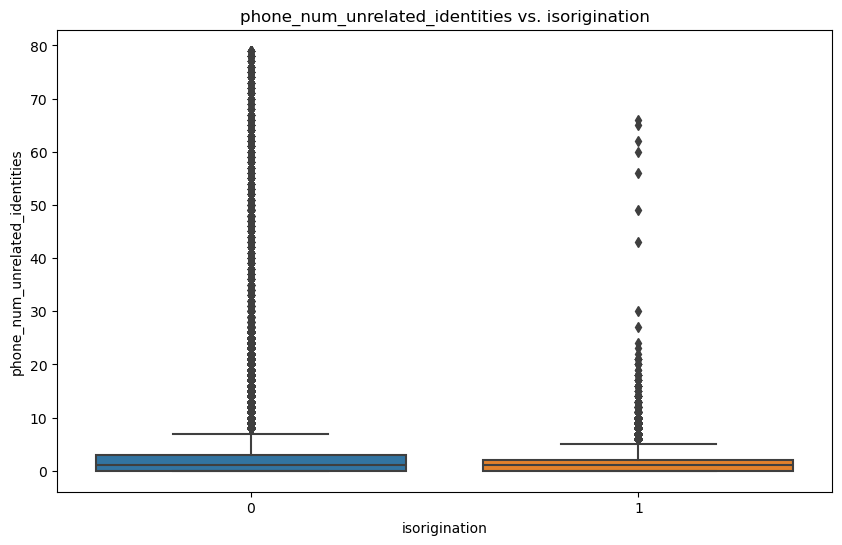

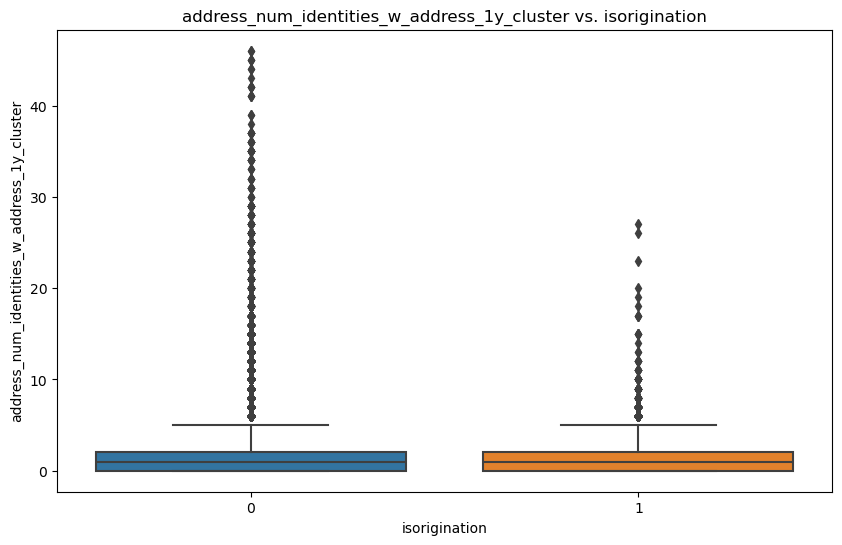

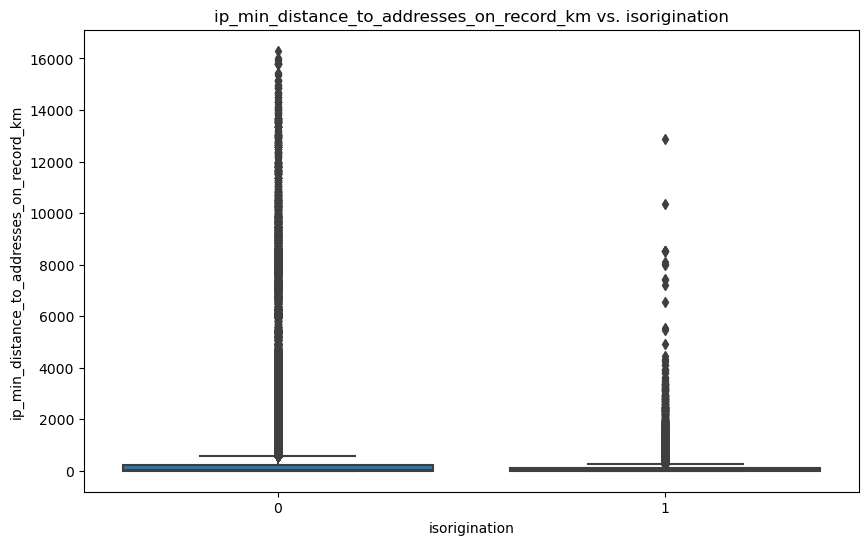

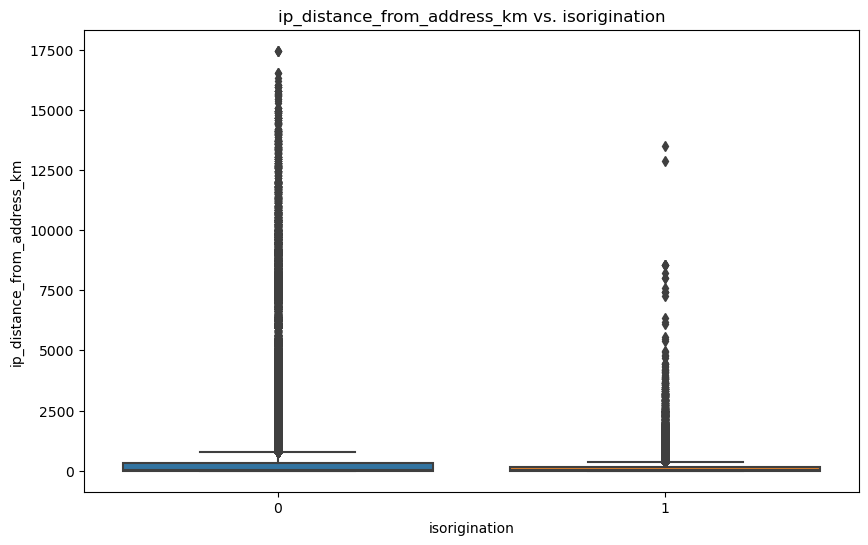

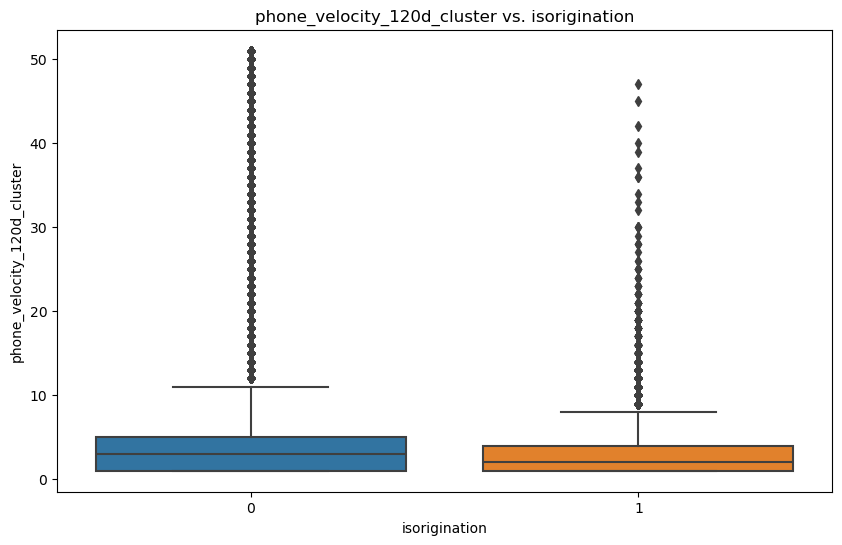

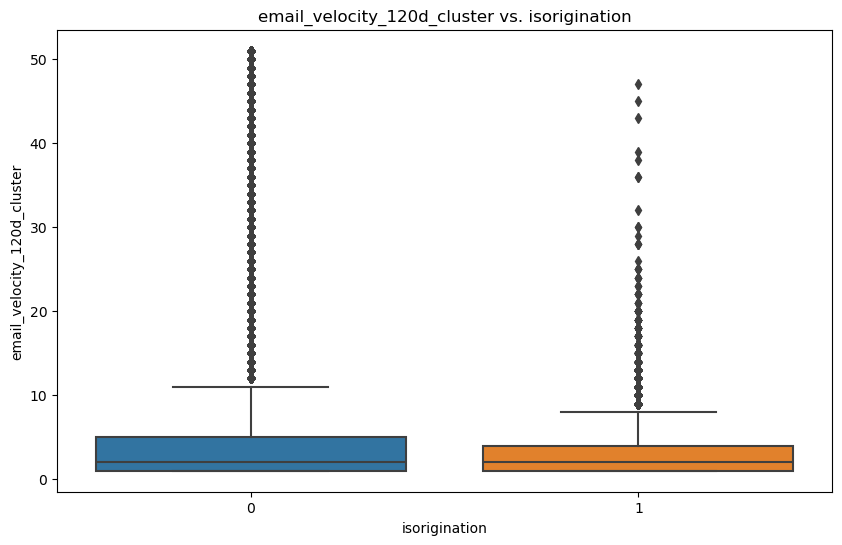

In [15]:
plot_relationships(final_df_iso, 'isorigination', important_columns_iso)

In [ ]:
data_clean_iso = final_df_iso.dropna(subset=['isorigination'])
numeric_features = data_clean_iso.select_dtypes(include=[np.number]).columns.drop('isorigination')
numeric_data = data_clean_iso[numeric_features].dropna(axis=1, how='all')

X = numeric_data
y = data_clean_iso['isorigination']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
X_imputed_df.to_pickle('Sentilink_imputed_isorigination_split_df.pkl')

In [ ]:
correlation_matrix = X_imputed_df.corr(numeric_only=True)
correlation_matrix['isorigination'] = data_clean_iso['isorigination']
target_correlations = correlation_matrix['isorigination'].dropna().sort_values(ascending=False)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
feature_importances.head(20).plot(kind='barh')
plt.title('Important Features')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
top_50_importances = feature_importances.head(50).to_frame(name='Importance')
top_50_importances

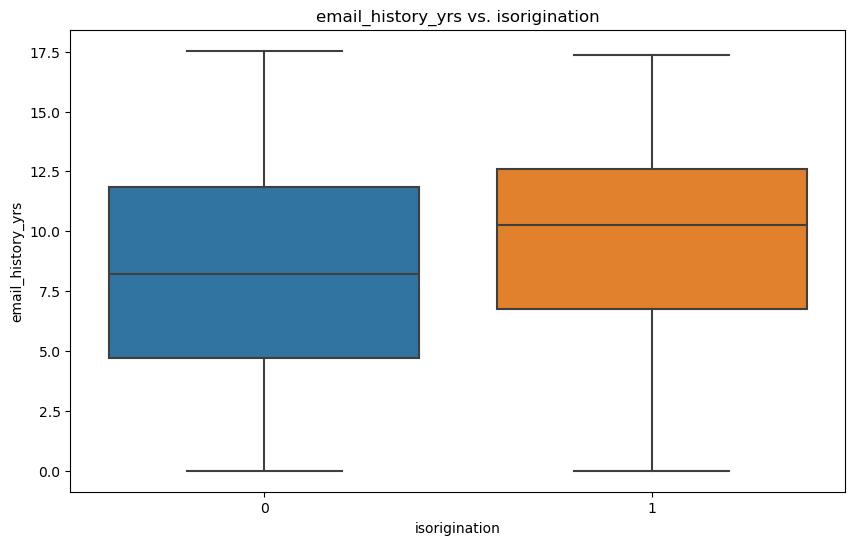

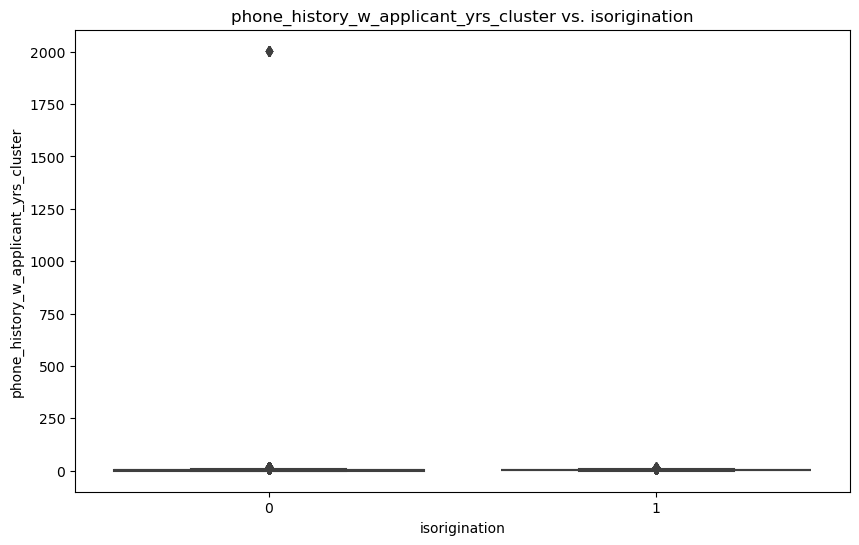

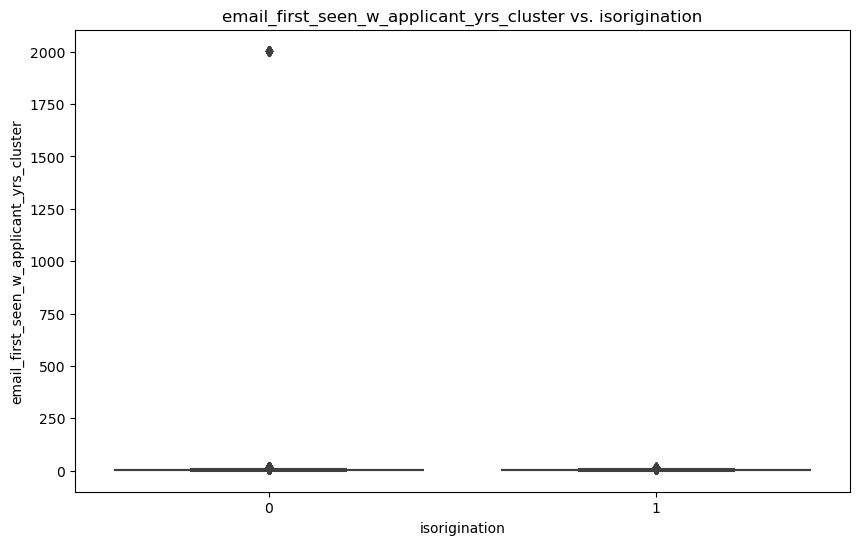

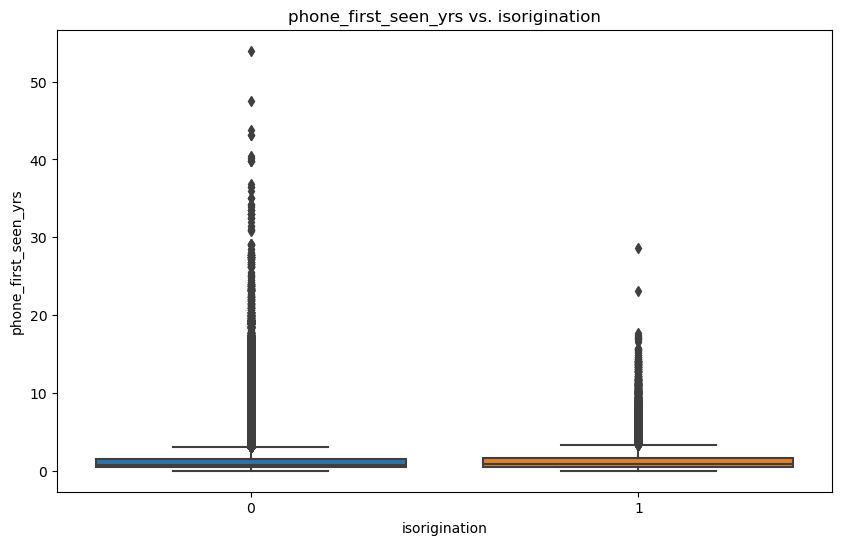

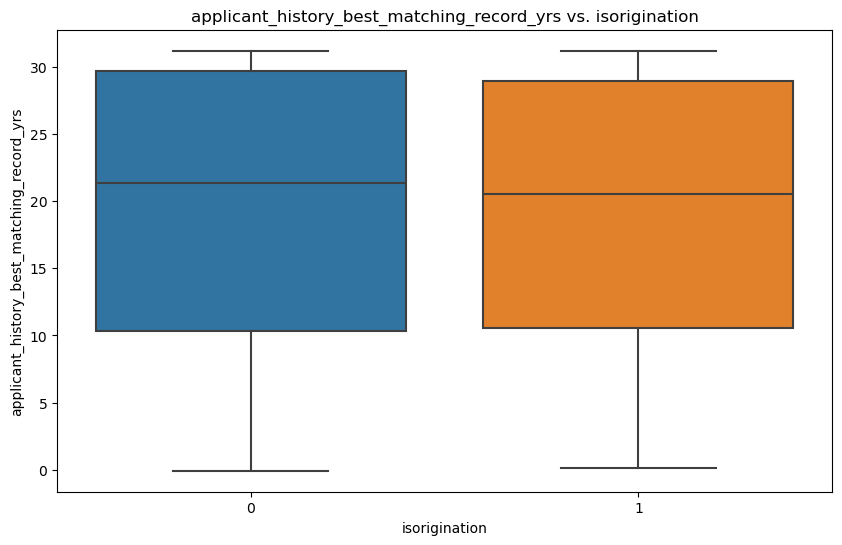

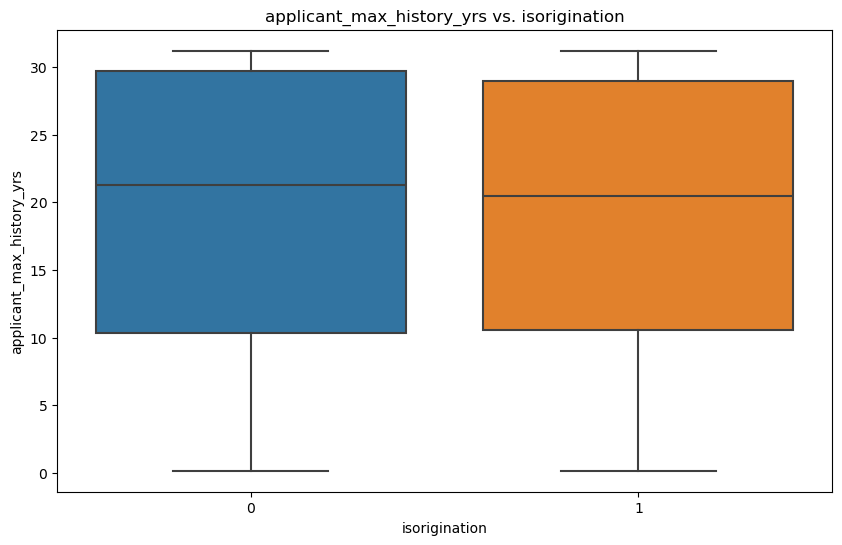

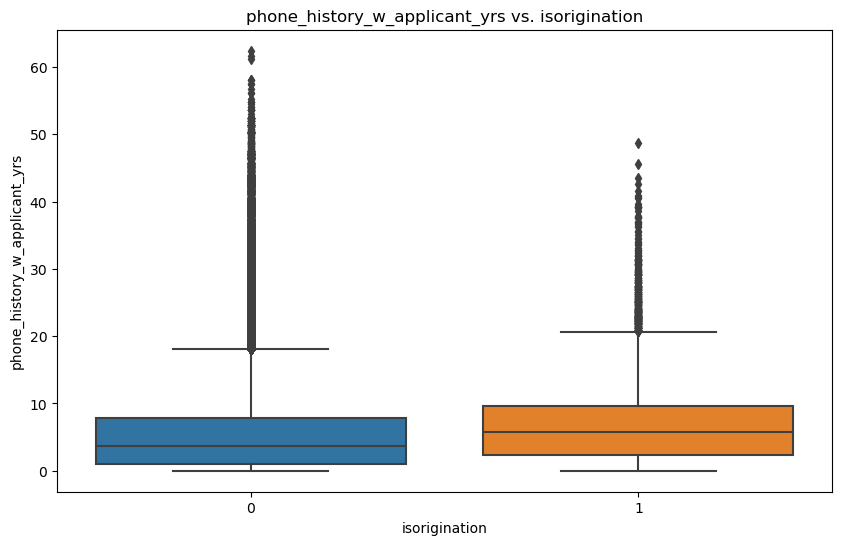

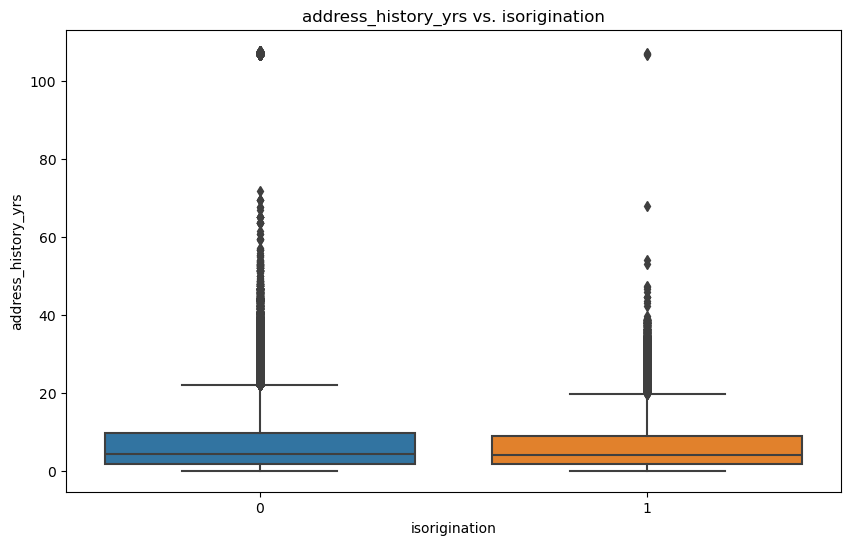

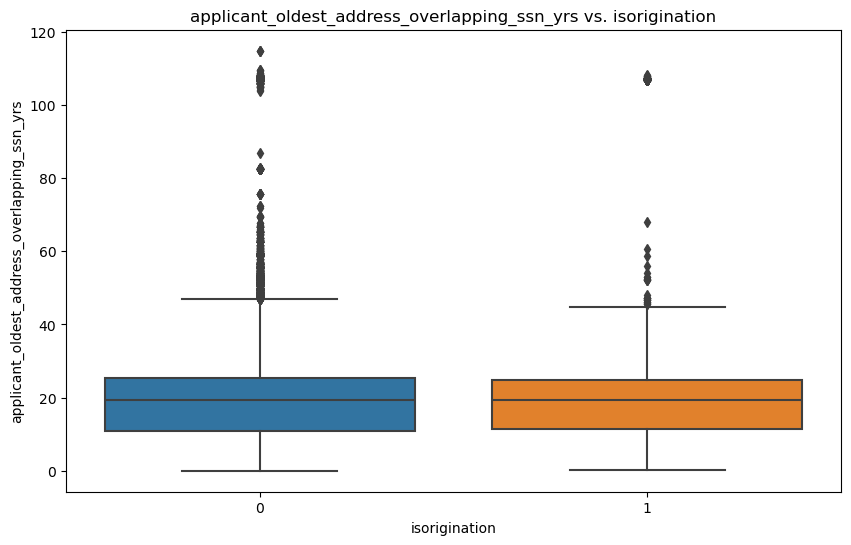

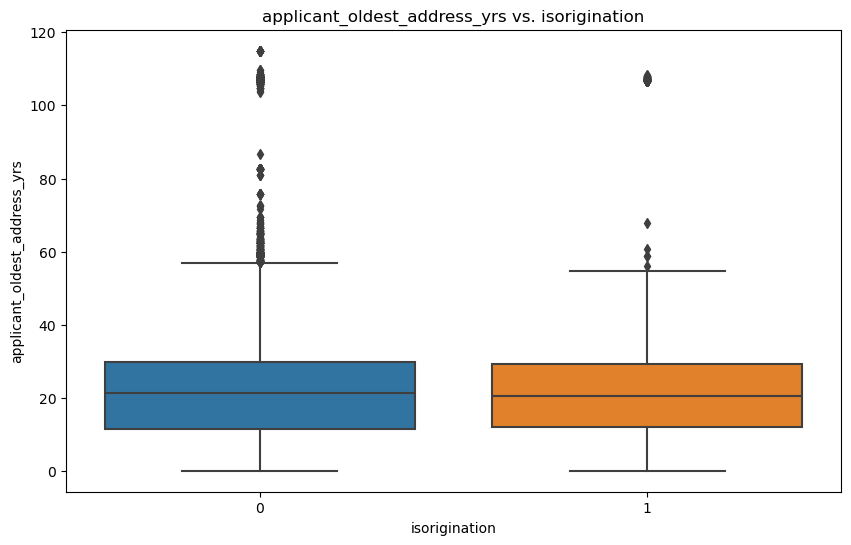

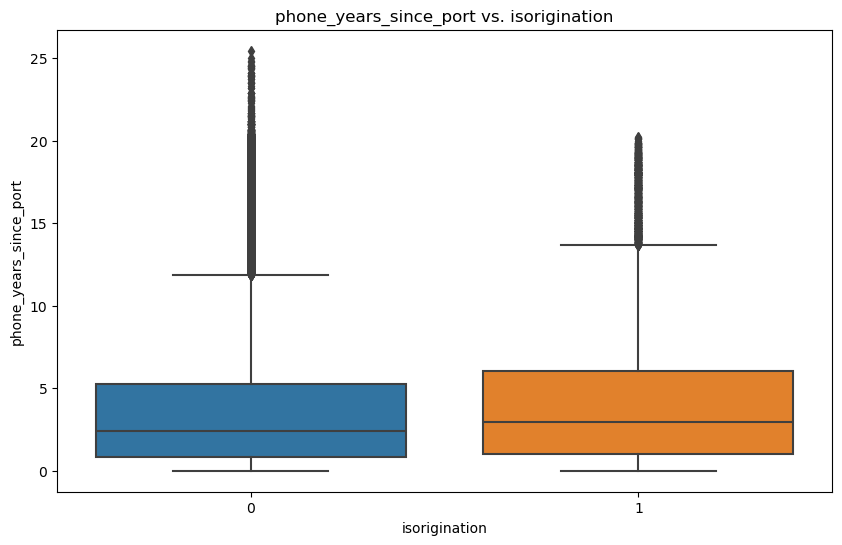

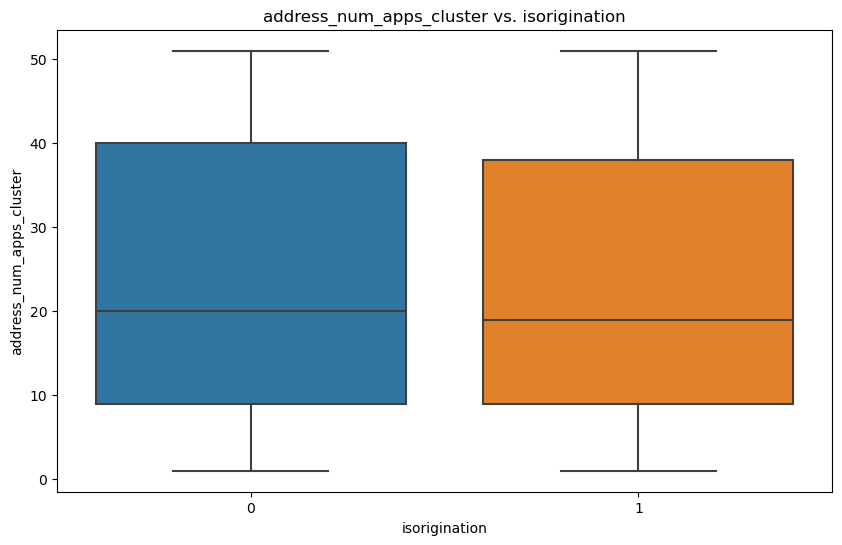

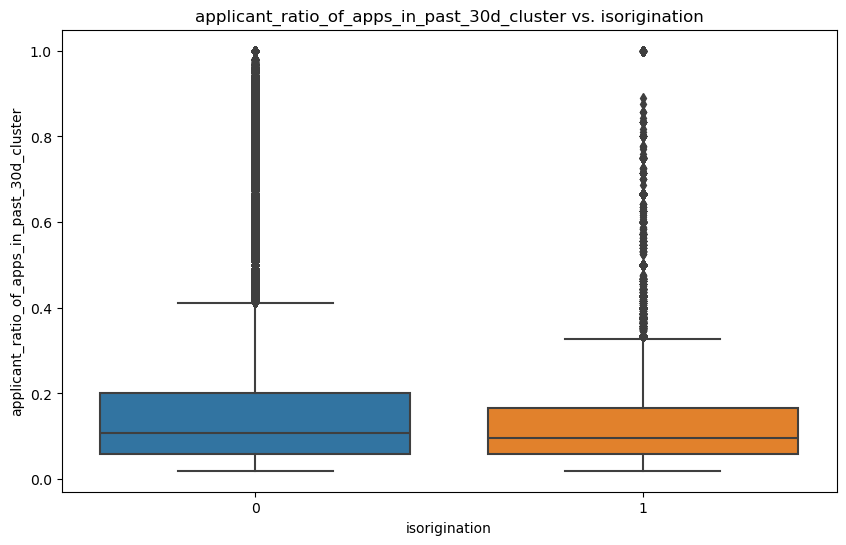

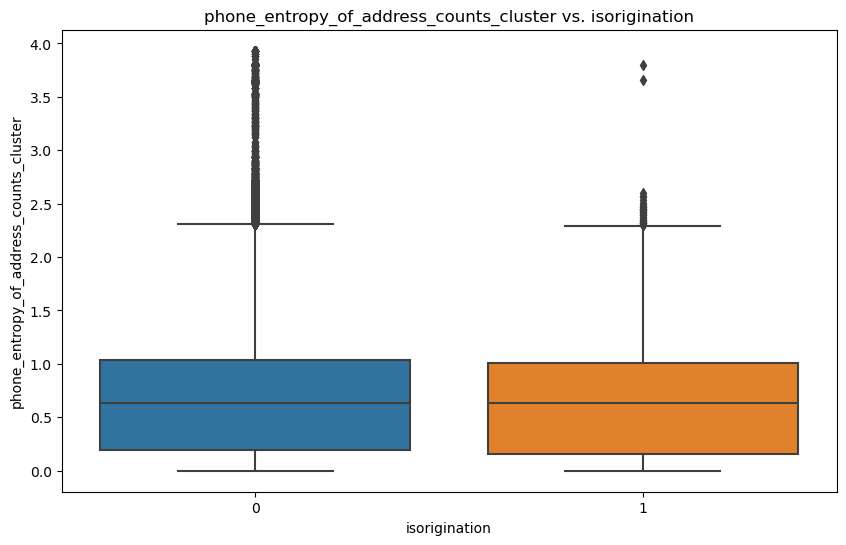

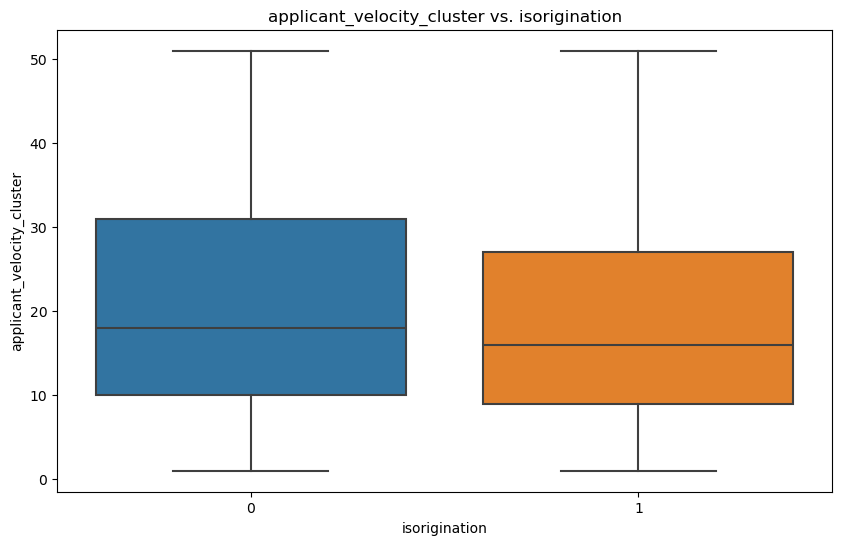

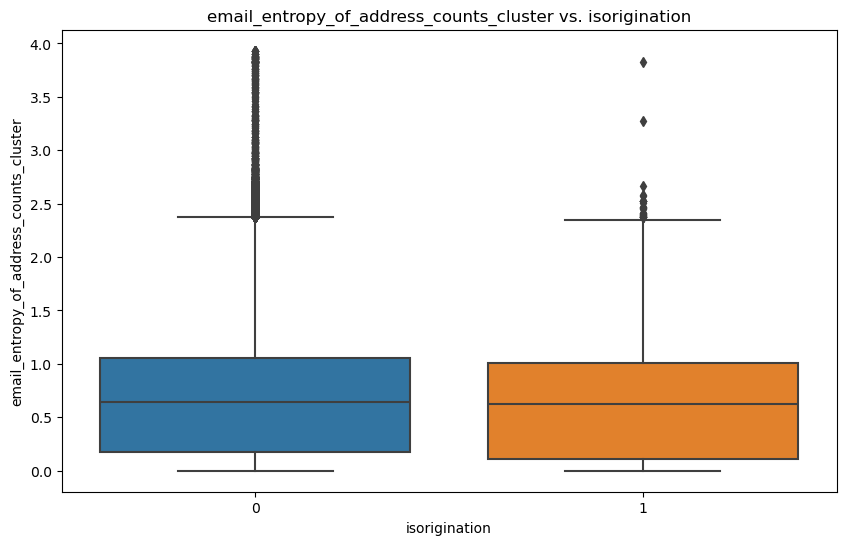

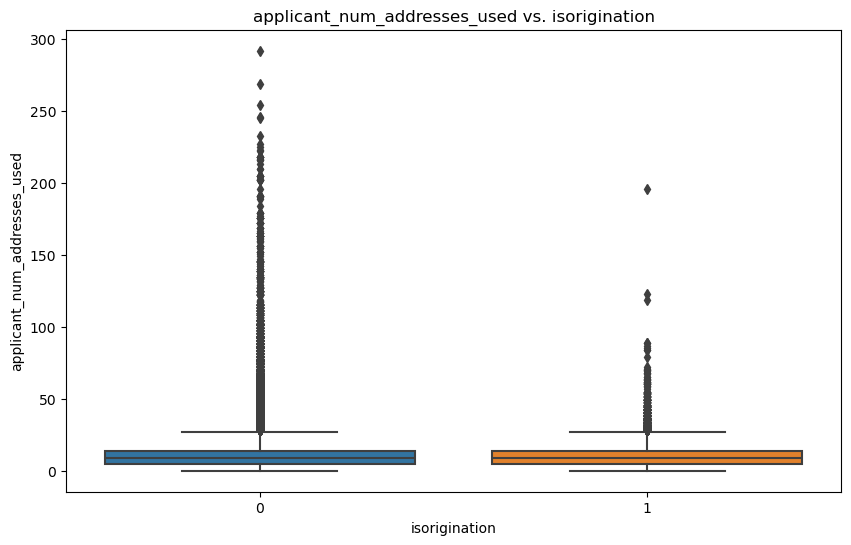

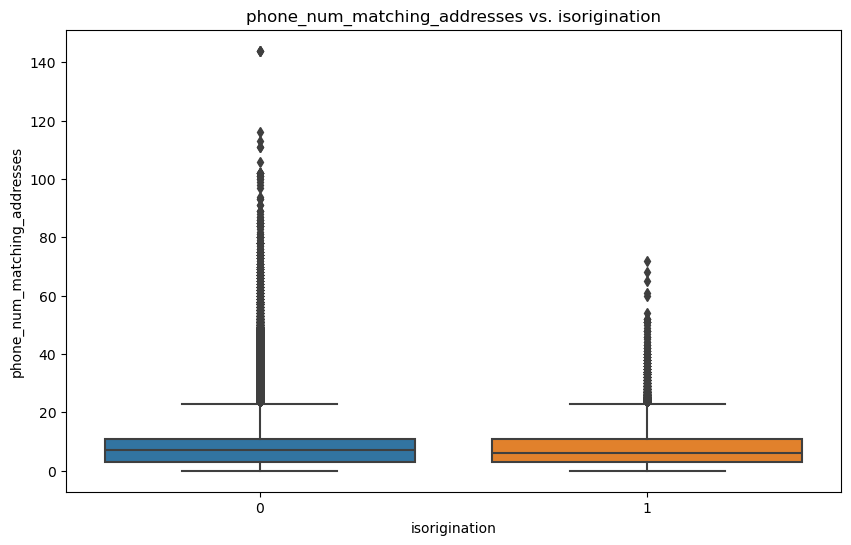

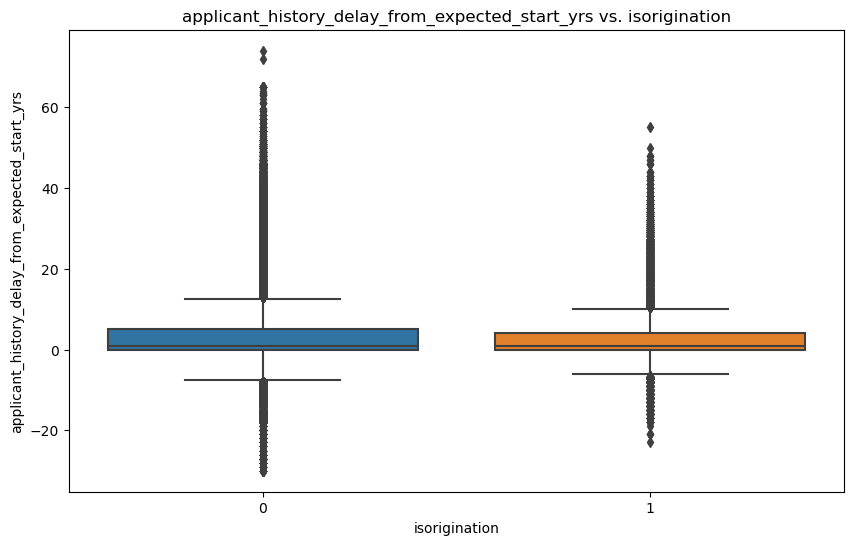

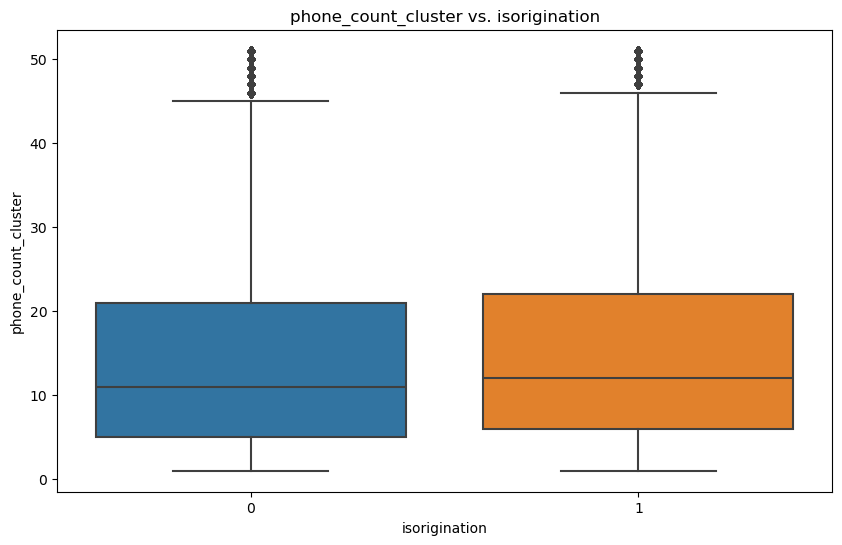

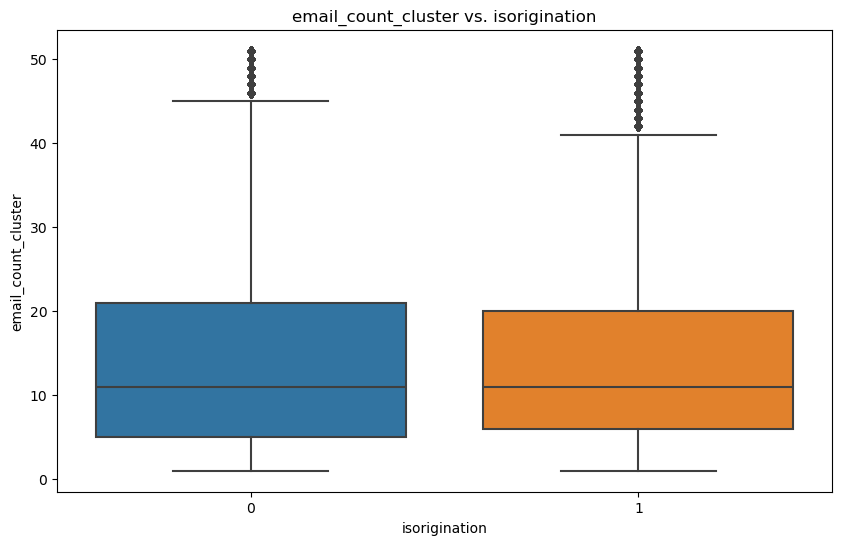

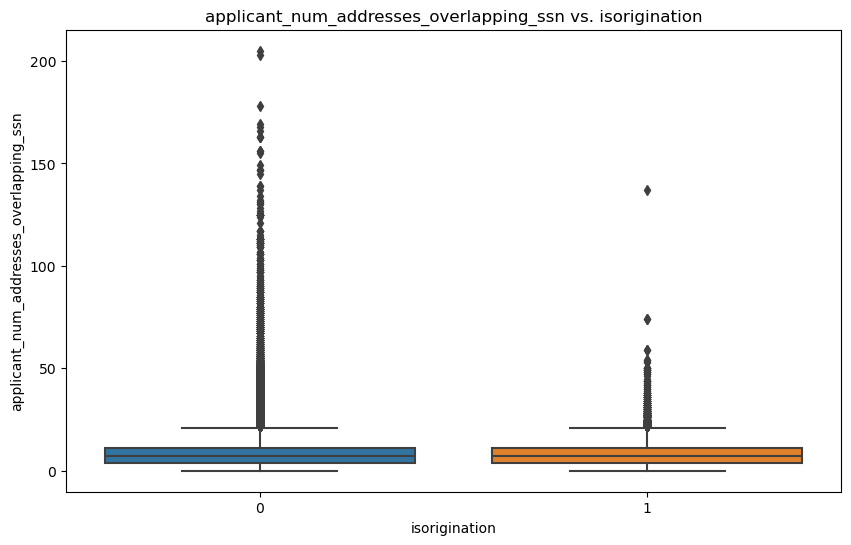

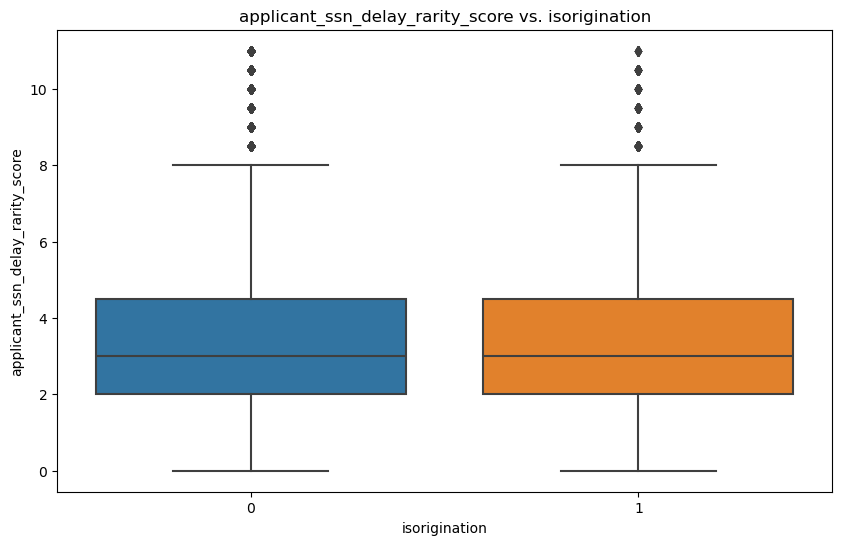

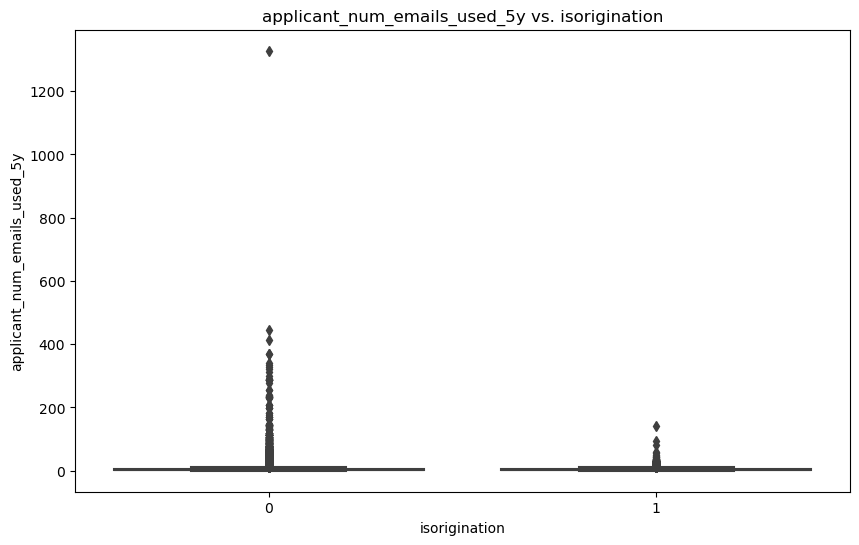

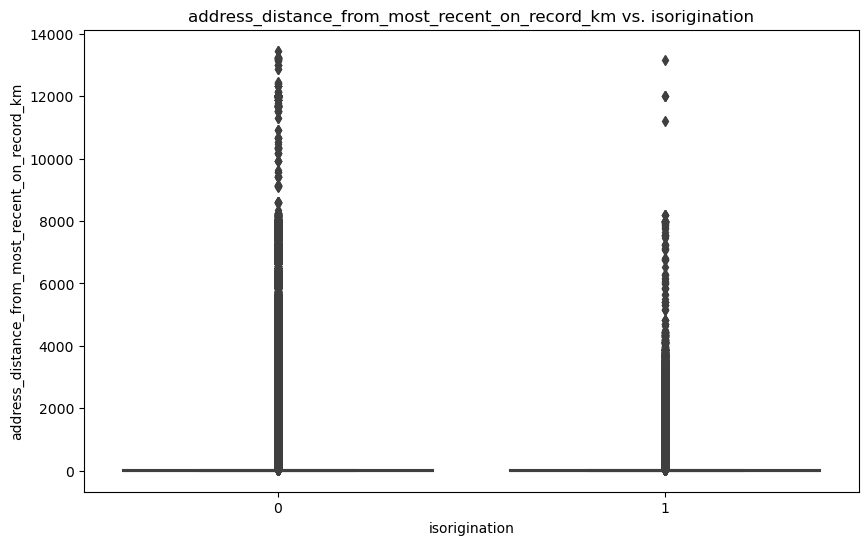

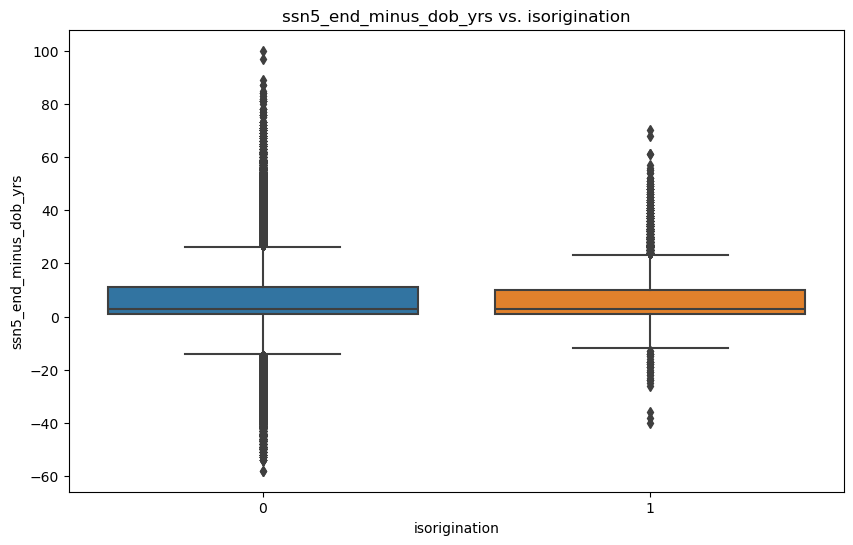

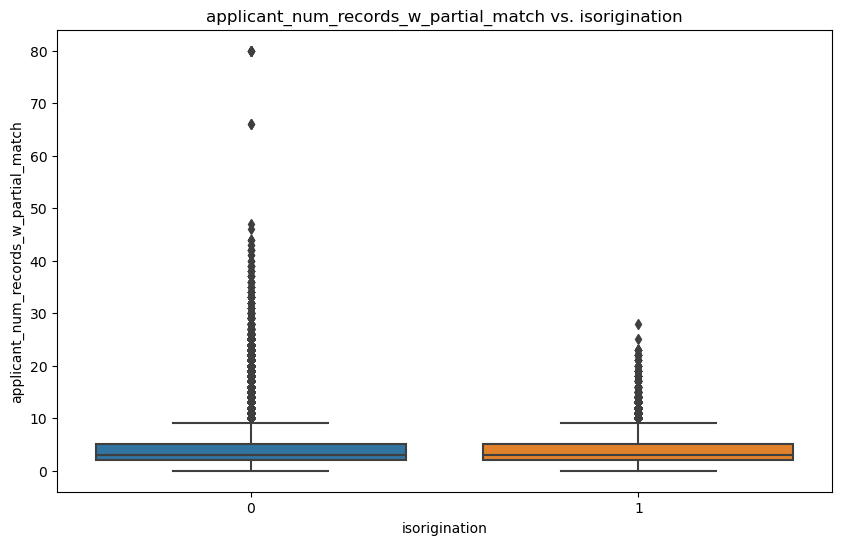

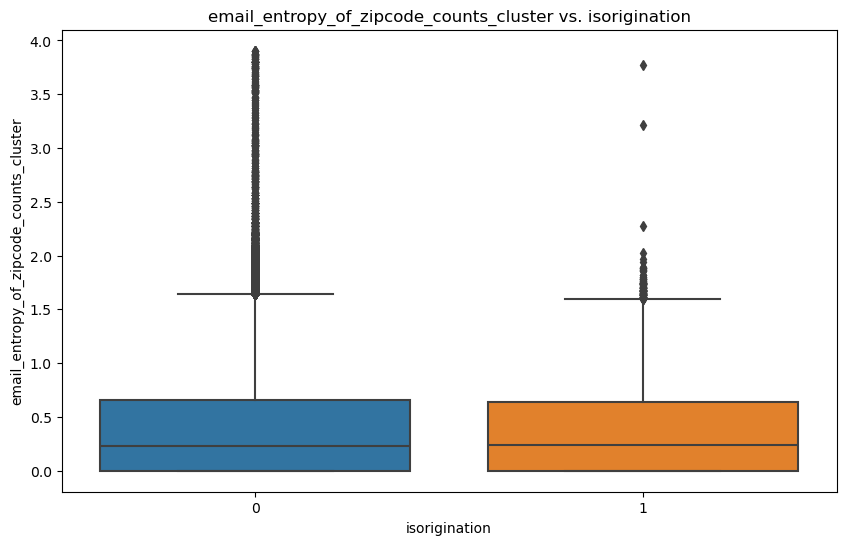

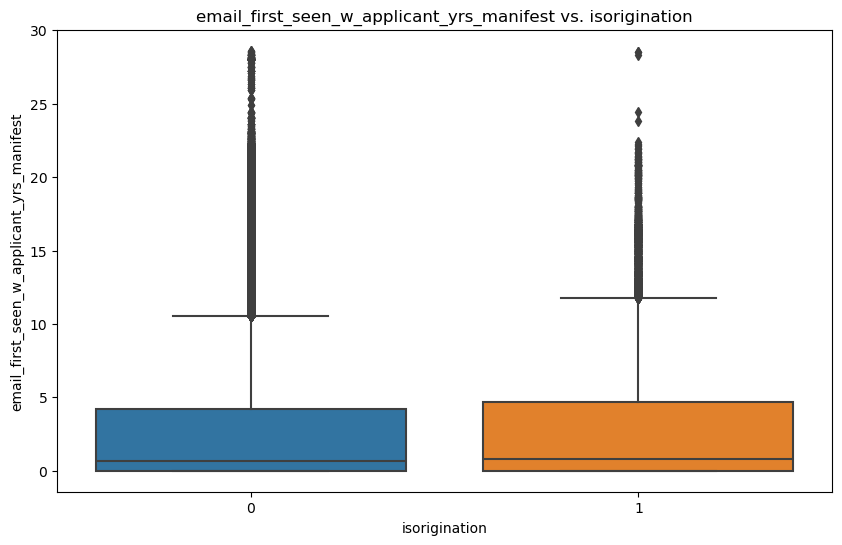

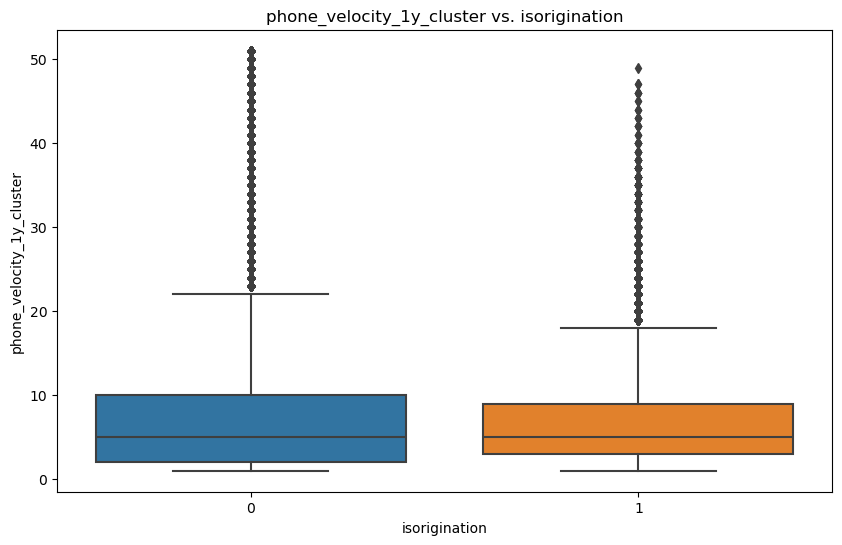

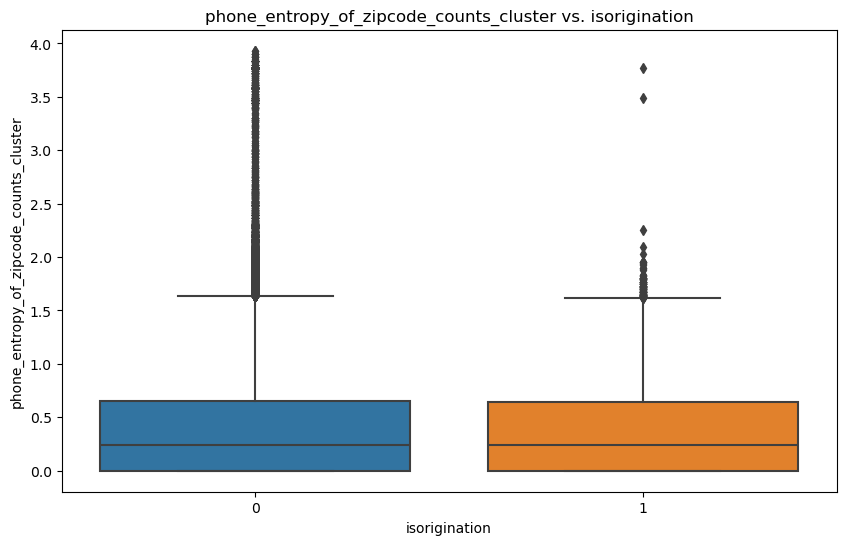

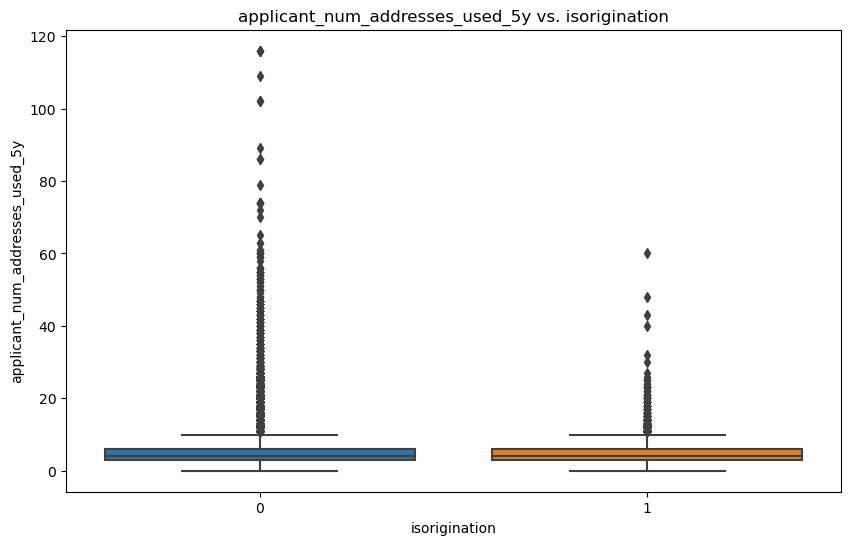

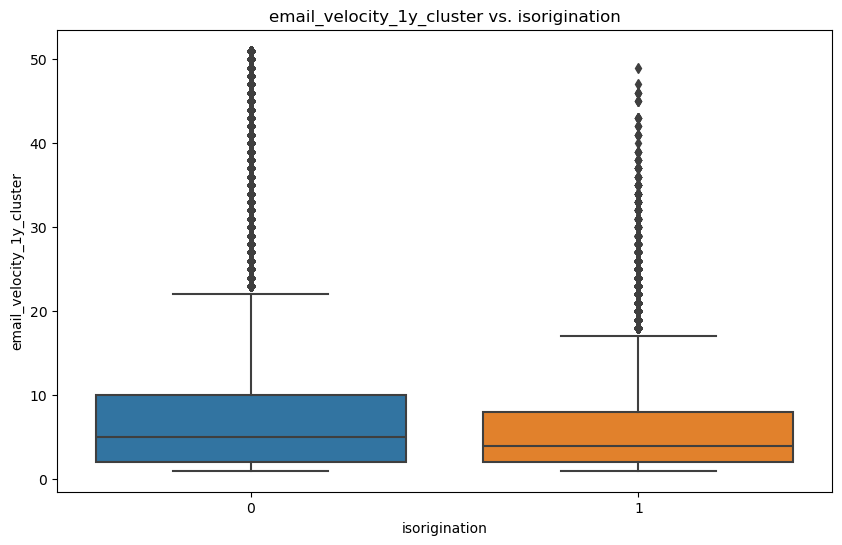

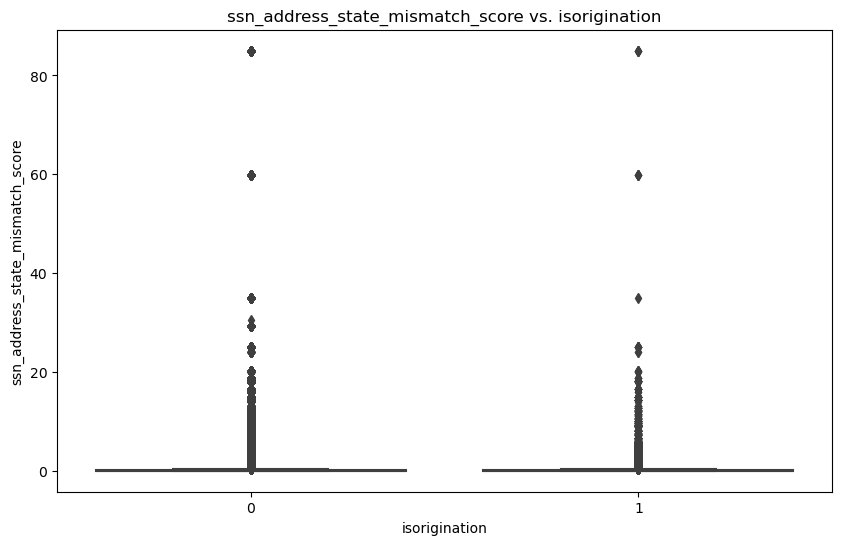

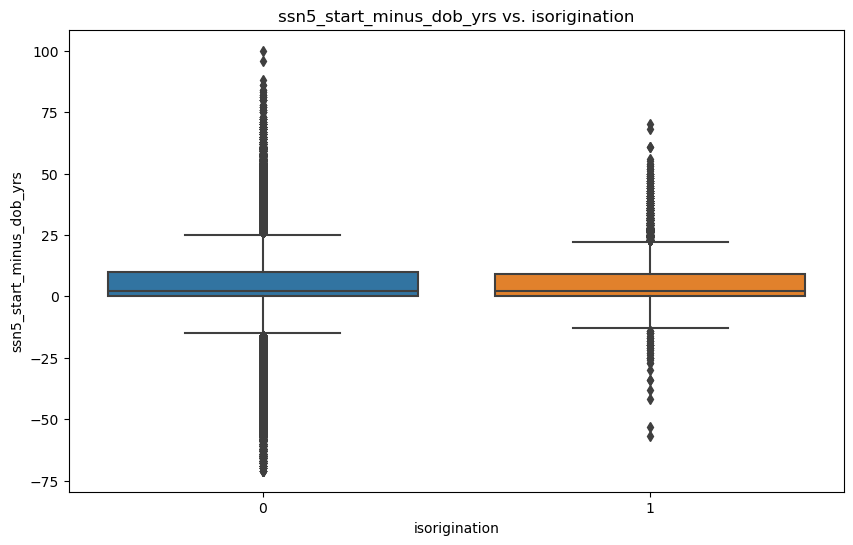

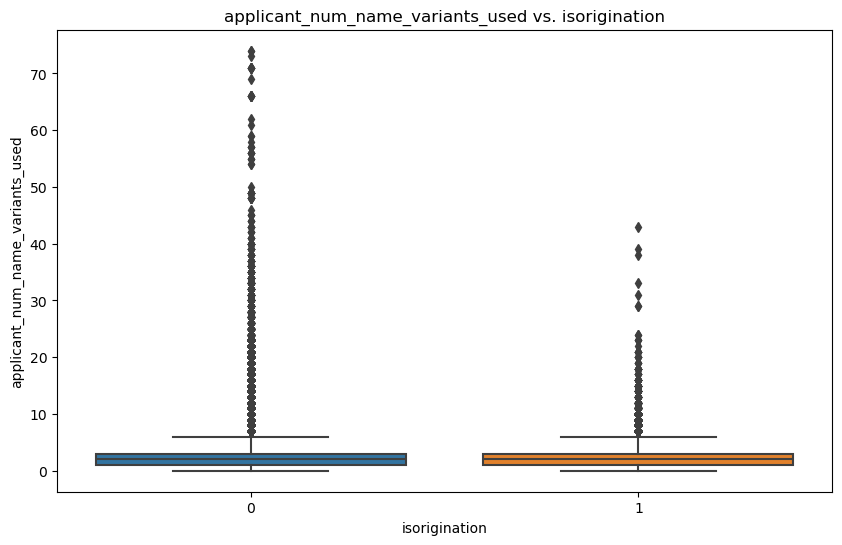

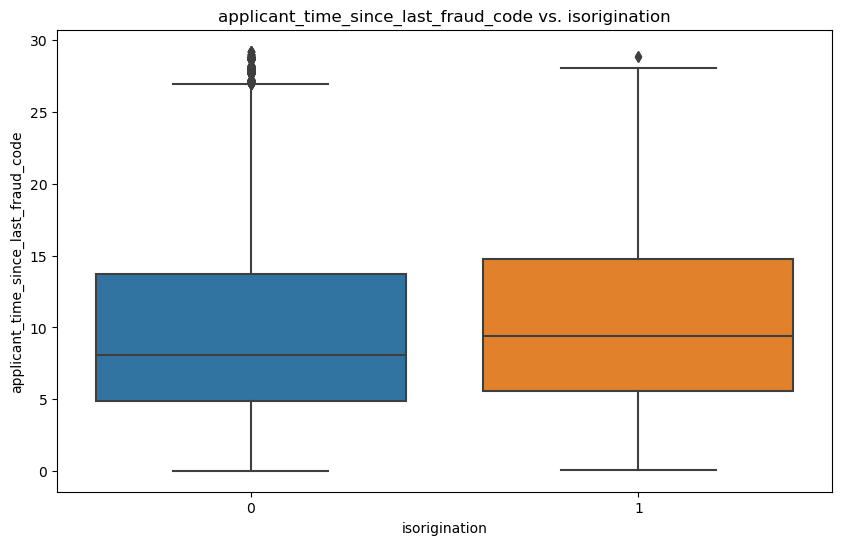

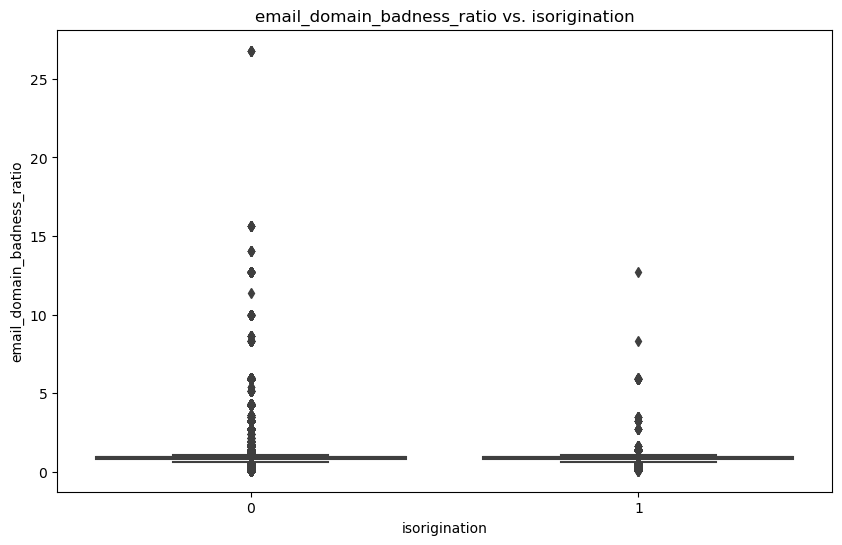

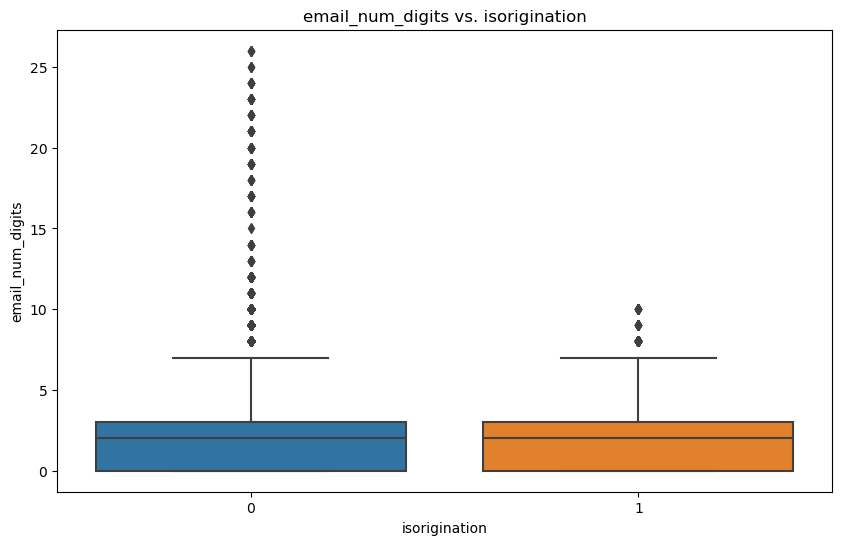

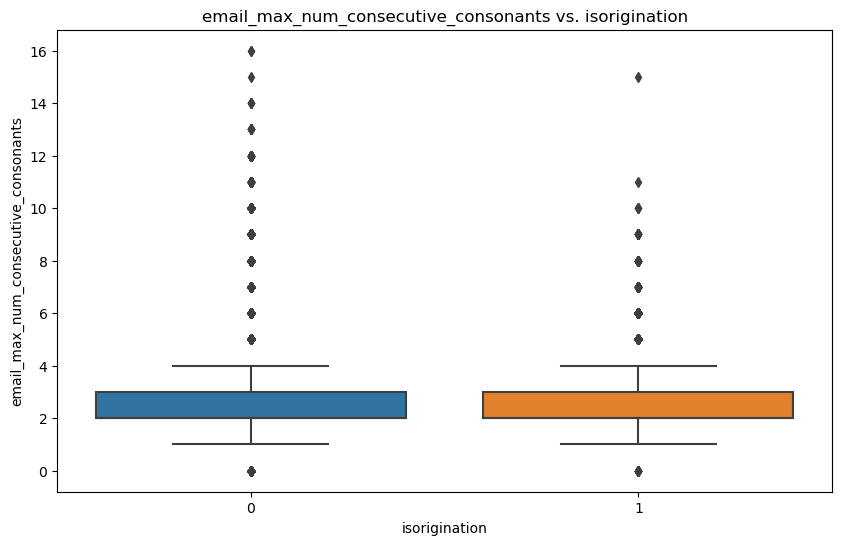

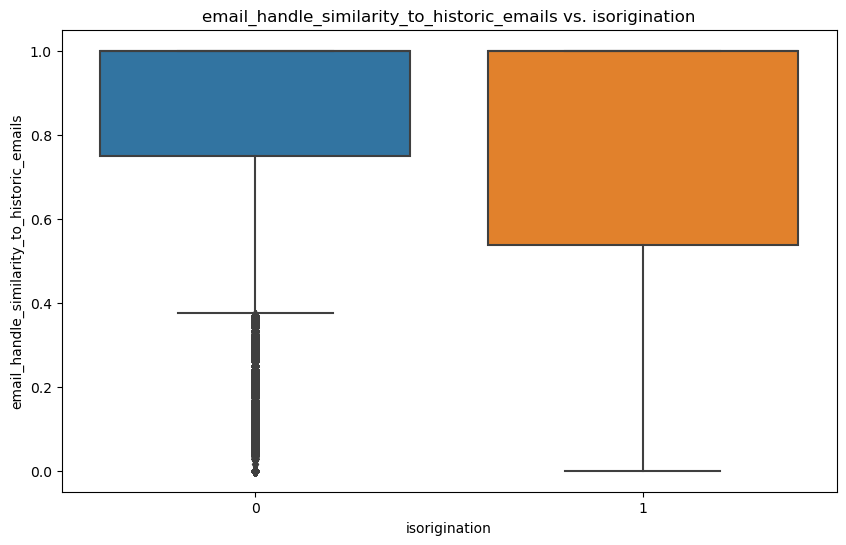

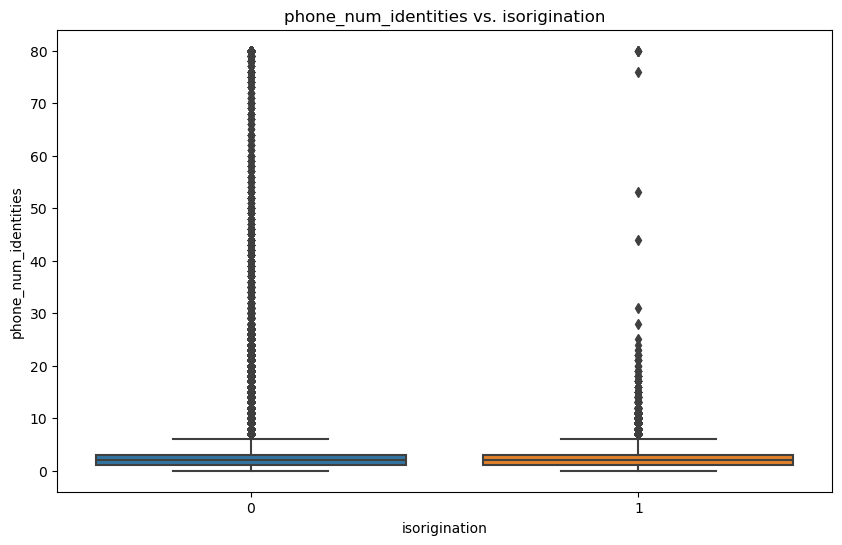

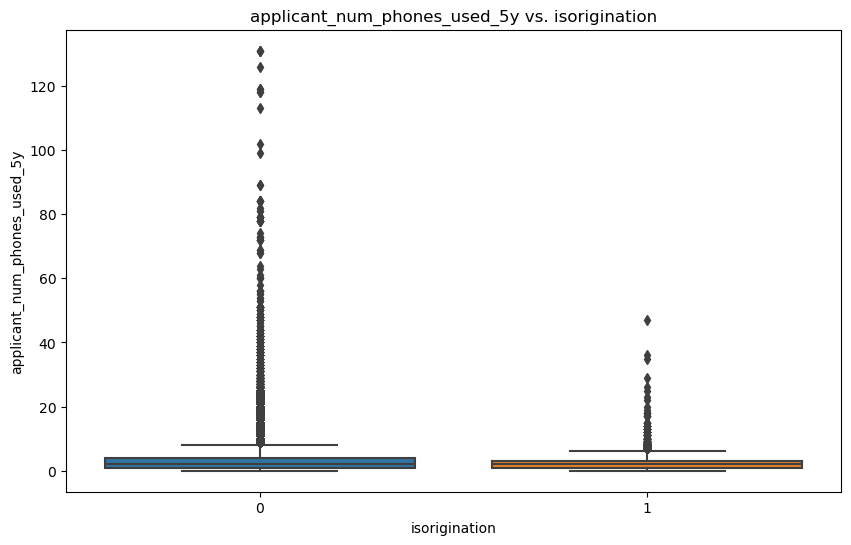

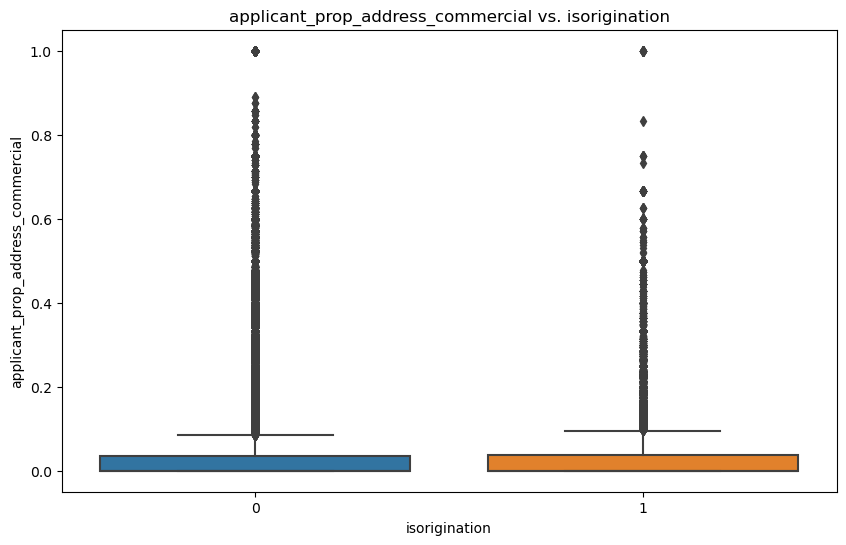

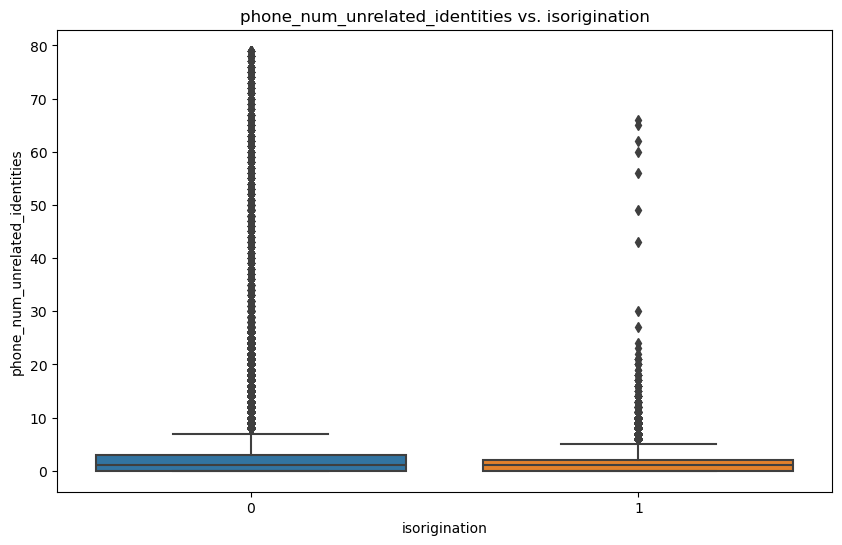

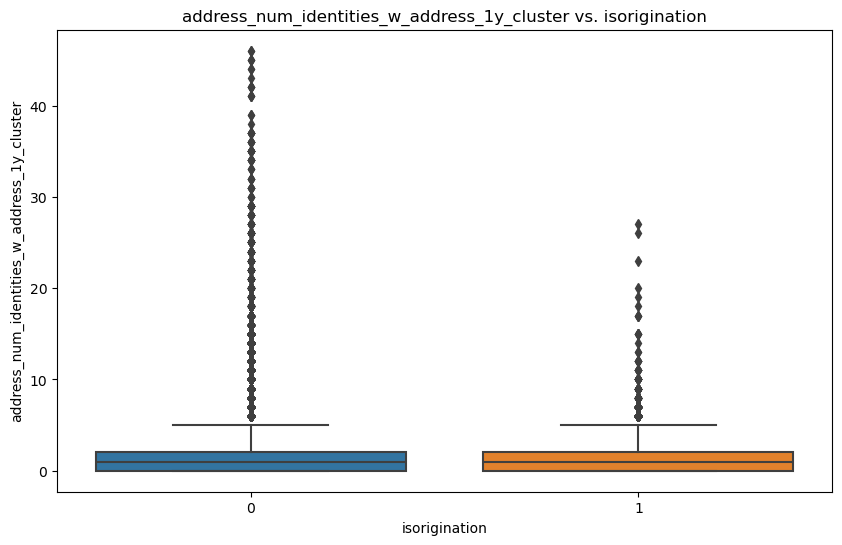

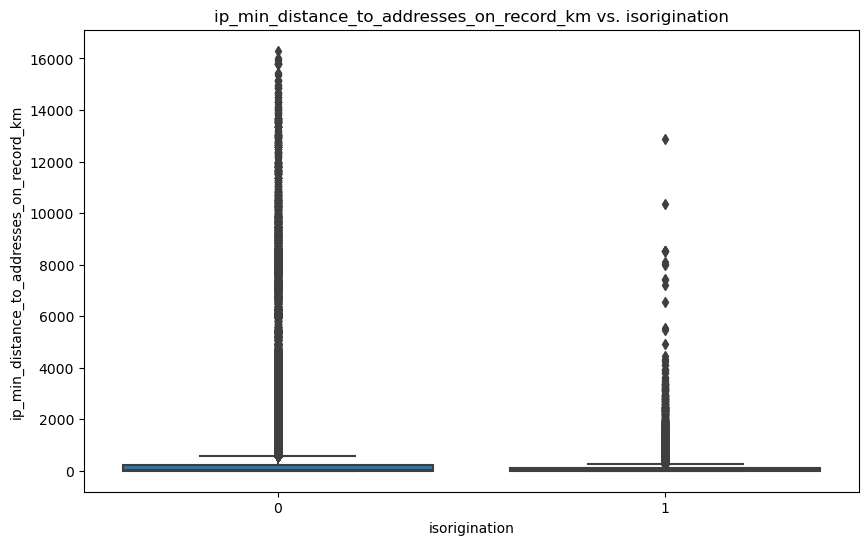

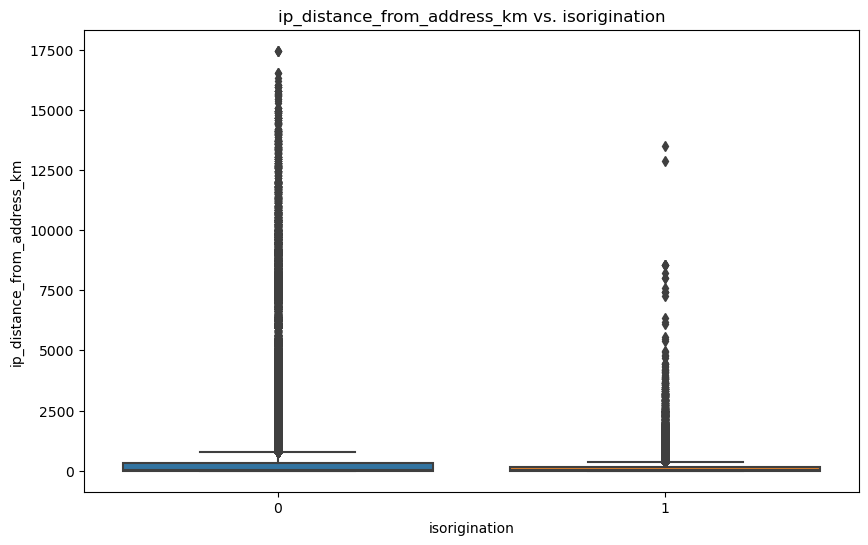

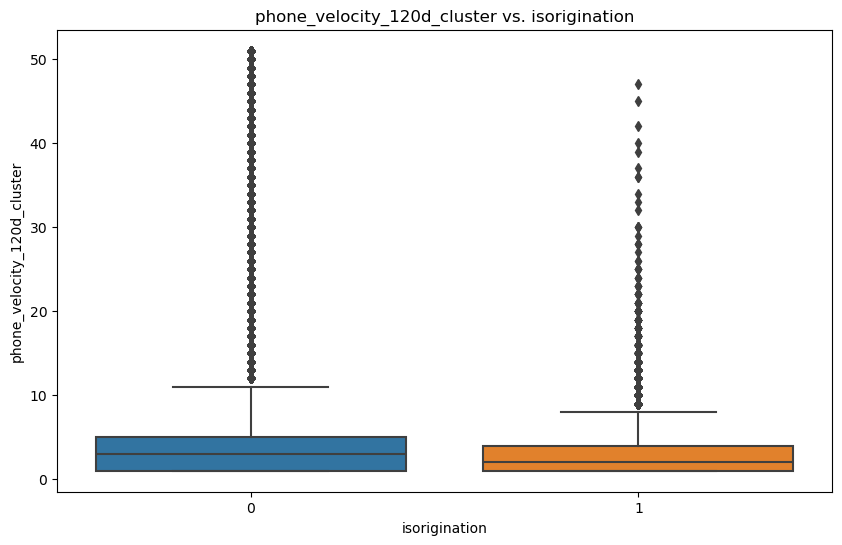

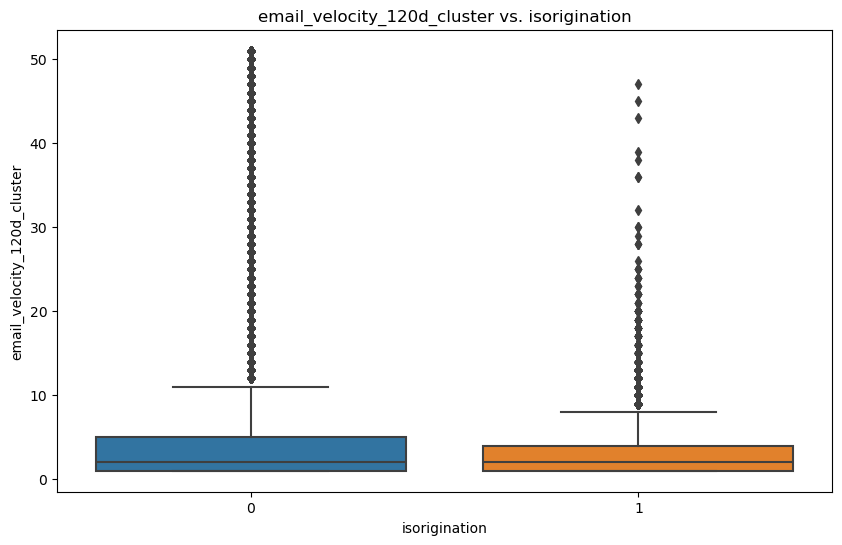

In [14]:
important_columns_iso = [
    'email_history_yrs',
    'phone_history_w_applicant_yrs_cluster',
    'email_first_seen_w_applicant_yrs_cluster',
    'phone_first_seen_yrs',
    'applicant_history_best_matching_record_yrs',
    'applicant_max_history_yrs',
    'phone_history_w_applicant_yrs',
    'address_history_yrs',
    'applicant_oldest_address_overlapping_ssn_yrs',
    'applicant_oldest_address_yrs',
    'phone_years_since_port',
    'address_num_apps_cluster',
    'applicant_ratio_of_apps_in_past_30d_cluster',
    'phone_entropy_of_address_counts_cluster',
    'applicant_velocity_cluster',
    'email_entropy_of_address_counts_cluster',
    'applicant_num_addresses_used',
    'phone_num_matching_addresses',
    'applicant_history_delay_from_expected_start_yrs',
    'phone_count_cluster',
    'email_count_cluster',
    'applicant_num_addresses_overlapping_ssn',
    'applicant_ssn_delay_rarity_score',
    'applicant_num_emails_used_5y',
    'address_distance_from_most_recent_on_record_km',
    'ssn5_end_minus_dob_yrs',
    'applicant_num_records_w_partial_match',
    'email_entropy_of_zipcode_counts_cluster',
    'email_first_seen_w_applicant_yrs_manifest',
    'phone_velocity_1y_cluster',
    'phone_entropy_of_zipcode_counts_cluster',
    'applicant_num_addresses_used_5y',
    'email_velocity_1y_cluster',
    'ssn_address_state_mismatch_score',
    'ssn5_start_minus_dob_yrs',
    'applicant_num_name_variants_used',
    'applicant_time_since_last_fraud_code',
    'email_domain_badness_ratio',
    'email_num_digits',
    'email_max_num_consecutive_consonants',
    'email_handle_similarity_to_historic_emails',
    'phone_num_identities',
    'applicant_num_phones_used_5y',
    'applicant_prop_address_commercial',
    'phone_num_unrelated_identities',
    'address_num_identities_w_address_1y_cluster',
    'ip_min_distance_to_addresses_on_record_km',
    'ip_distance_from_address_km',
    'phone_velocity_120d_cluster',
    'email_velocity_120d_cluster'
]

plot_relationships(final_df_iso, 'isorigination', important_columns_iso)

In [16]:
def iso_decile_buckets(df, icolumns, iso_column):
    feature_buckets = {}
    for col in icolumns:
        if col not in df.columns:
            continue
        try:
            df['decile'] = pd.qcut(df[col], 10, labels=False, duplicates='drop') + 1
            decile_df = df.groupby('decile').agg(
                min_value=(col, 'min'),
                max_value=(col, 'max'),
                isorigination_rate=(iso_column, 'mean')
            ).reset_index()
            decile_df['feature'] = col
            print(f"Decile DataFrame for {col}:\n{decile_df}")
            feature_buckets[col] = decile_df
        except Exception as e:
            print(f"Error processing {col}: e")
    return feature_buckets

In [ ]:
feature_buckets_iso = iso_decile_buckets(final_df_iso, important_columns_iso, 'isorigination')
print(feature_buckets_iso)

In [17]:
iso_features = [
    'email_history_yrs',
    'phone_history_w_applicant_yrs_cluster',
    'email_first_seen_w_applicant_yrs_cluster',
    'phone_history_w_applicant_yrs',
    'applicant_ratio_of_apps_in_past_30d_cluster',
    'applicant_time_since_last_fraud_code',
    'phone_years_since_port',
    'applicant_num_phones_used_5y',
    'ip_min_distance_to_addresses_on_record_km',
    'ip_distance_from_address_km',
    
]
len(iso_features)

10

In [ ]:
feature_buckets_iso2 = iso_decile_buckets(final_df, iso_features, 'isorigination')
print(feature_buckets_iso2)

In [ ]:
import openpyxl
from openpyxl.drawing.image import Image 
import os

def iso_write_to_excel_with_graphs(feature_buckets_iso2, iso_output_file):
    with pd.ExcelWriter(iso_output_file, engine='openpyxl') as writer:
        sheet_index = 0
        
        for feature, df in feature_buckets_iso2.items():
            sheet_name = f'Features {sheet_index // 5 + 1}'
            startrow = (sheet_index % 5) * 15
            df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)
            
            plt.figure(figsize=(8, 6))
            plt.bar(df['decile'], df['isorigination_rate'])
            plt.xlabel('Decile')
            plt.ylabel('isOrigination')
            
            image_path = f'{feature}.png'
            plt.savefig(image_path)
            plt.close()
            workbook = writer.book
            worksheet = workbook[sheet_name]
            img = openpyxl.drawing.image.Image(image_path)
            img.anchor = f'I{startrow + 1}'
            worksheet.add_image(img)
            sheet_index += 1
            
    for feature in feature_buckets_iso2.keys():
        os.remove(f'{feature}.png')

In [ ]:
iso_output_file = 'feature_buckets_iso2.xlsx'
iso_write_to_excel_with_graphs(feature_buckets_iso2, iso_output_file)

## 3.3 Grouping by org (1-4) 

In [ ]:
from openpyxl.chart import BarChart, Reference

def process_and_write_excel(df, iso_features, dpd_features, output_file):
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for org_id in range(1, 5):
            org_df = df[df['organization_id'] == org_id]
            
            feature_buckets_iso = iso_decile_buckets(org_df, iso_features, 'isorigination')
            feature_buckets_dpd = decile_buckets(org_df, dpd_features, 'isFPD', 'Ever_30DPD_in_90')
            
            sheet_name = f'Organization {org_id}'
            row_index = 0
            
            for feature, df_bucket in feature_buckets_iso.items():
                df_bucket.to_excel(writer, sheet_name=sheet_name, index=False, startrow=row_index)
                workbook = writer.book
                worksheet = workbook[sheet_name]
                chart = BarChart()
                chart.title = f'{feature} IsOrig Rate'
                chart.y_axis.title = 'IsOrig'
                chart.x_axis.title = 'Decile'
                data = Reference(worksheet, min_col=4, min_row=row_index+1, max_row=row_index+11)
                cats = Reference(worksheet, min_col=1, min_row=row_index+2, max_row=row_index+11)
                chart.add_data(data, titles_from_data=True)
                chart.set_categories(cats)
                chart_anchor = f'J{row_index + 1}'
                worksheet.add_chart(chart, chart_anchor)
                row_index += len(df_bucket) + 3
            
            for feature, df_bucket in feature_buckets_dpd.items():
                df_bucket.to_excel(writer, sheet_name=sheet_name, index=False, startrow=row_index)
                workbook = writer.book
                worksheet = workbook[sheet_name]
                chart = BarChart()
                chart.title = f'{feature} Ever 30DPD'
                chart.y_axis.title = 'ever_30DPD'
                chart.x_axis.title = 'Decile'
                data = Reference(worksheet, min_col=5, min_row=row_index+1, max_row=row_index+11)
                cats = Reference(worksheet, min_col=1, min_row=row_index+2, max_row=row_index+11)
                chart.add_data(data, titles_from_data=True)
                chart.set_categories(cats)
                chart_anchor = f'J{row_index + 1}'
                worksheet.add_chart(chart, chart_anchor)
                row_index += len(df_bucket) + 3

In [ ]:
ouput_file = 'feature_buckets_organization.xlsx'
process_and_write_excel(final_df, iso_features, dpd_features, output_file)

## 3.4 TUrs moneykey score 

In [19]:
iters=200
conn= mysql.connector.connect(option_files='.my.cnf', option_groups = 'mysqlconnection', use_pure=True,
                              auth_plugin='mysql_native_password')
for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT lead_sequence_id, mk_MK2_CF_risk_March2023_score as MK2rs 
    FROM datawork.mk_application_more 
    WHERE lead_sequence_id in """ + str(tuple(final_df.lead_sequence_id[(i*np.floor(len(final_df)/iters)).astype(int):((i+1)*np.floor(len(final_df)/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        MK2rs_df = temp.copy()
    else:
        MK2rs_df = pd.concat([MK2rs_df, temp], ignore_index=True)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_50412/1321725876.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temp =  pd.read_sql("""


2.928776979446411
0
(26545, 2)
2.1285407543182373
1
(26545, 2)
2.4436841011047363
2
(26545, 2)
2.181833028793335
3
(26547, 2)
1.8295831680297852
4
(26546, 2)
1.827934980392456
5
(26539, 2)
1.835231065750122
6
(26541, 2)
1.586855173110962
7
(26546, 2)
1.2177529335021973
8
(26539, 2)
1.4359989166259766
9
(26545, 2)
1.3213129043579102
10
(26544, 2)
1.0596647262573242
11
(26541, 2)
1.8789677619934082
12
(26546, 2)
1.757072925567627
13
(26538, 2)
1.8848340511322021
14
(26546, 2)
2.093686103820801
15
(26546, 2)
1.930413007736206
16
(26543, 2)
1.7342829704284668
17
(26545, 2)
1.8459949493408203
18
(26543, 2)
1.6451661586761475
19
(26544, 2)
1.6906638145446777
20
(26540, 2)
1.5534868240356445
21
(26544, 2)
1.5474340915679932
22
(26546, 2)
1.359055995941162
23
(26541, 2)
1.2892258167266846
24
(26542, 2)
1.5105490684509277
25
(26544, 2)
1.527721881866455
26
(26544, 2)
1.5376958847045898
27
(26547, 2)
1.426551103591919
28
(26544, 2)
1.6131579875946045
29
(26542, 2)
1.5334999561309814
30
(26547, 2

In [20]:
final_df_1 = pd.merge(final_df, MK2rs_df, on='lead_sequence_id')

In [21]:
final_df_1.to_pickle('Sentilink_mk2rs_df.pkl')

In [ ]:
final_df_1 = pd.read_pickle('Sentilink_mk2rs_df.pkl')

In [22]:
org_filtered_df = final_df_1[final_df_1['organization_id'].isin([2,3,4])]

In [ ]:
def analyze_feature_splits(df, features, score_column, default_column):
    results = {}
    for feature in features:
        if feature not in df.columns:
            continue
        threshold = df[feature].quantile(0.5)
        below_threshold = df[df[feature] <= threshold]
        above_threshold = df[df[feature] > threshold]
        below_default_rate = below_threshold[default_column].mean()
        above_default_rate = above_threshold[default_column].mean()
        results[feature] = {
            'threshold': threshold,
            'below_threshold_default_rate': below_default_rate,
            'above_threshold_default_rate': above_default_rate
        }
    return results

results = analyze_feature_splits(org_filtered_df, dpd_features, 'MK2rs', 'Ever_30DPD_in_90')

In [ ]:
results

In [ ]:
def plot_feature_analysis(results):
    for feature, feature_data in results.items():
        plt.figure(figsize=(10, 6))
        bars = plt.bar(['Below Threshold', 'Above Threshold'], 
                       [feature_data['below_threshold_default_rate'], feature_data['above_threshold_default_rate']],
                       color=['blue', 'green'])
        plt.xlabel('Group')
        plt.ylabel('ever 30dpd')
        plt.title(f'Default Rate Analysis for {feature}')
        plt.ylim(0, 1)
    
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        plt.show()
    
plot_feature_analysis(results)

In [24]:
def analyze_feature_splits_score(df, features, score_column, default_column):
    results = {}
    score_median = df[score_column].median()
    below_median = df[df[score_column] <= score_median]
    above_median = df[df[score_column] > score_median]
    
    for feature in features:
        if feature not in df.columns:
            continue
        below_median_default_rate = below_median[default_column].mean()
        above_median_default_rate = above_median[default_column].mean()      
        below_feature_median = below_median[feature].median()
        below_feature_below_median = below_median[below_median[feature] <= below_feature_median]
        below_feature_above_median = below_median[below_median[feature] > below_feature_median]       
        below_feature_below_default_rate = below_feature_below_median[default_column].mean()
        below_feature_above_default_rate = below_feature_above_median[default_column].mean()     
        above_feature_median = above_median[feature].median()
        above_feature_below_median = above_median[above_median[feature] <= above_feature_median]
        above_feature_above_median = above_median[above_median[feature] > above_feature_median]
        above_feature_below_default_rate = above_feature_below_median[default_column].mean()
        above_feature_above_default_rate = above_feature_above_median[default_column].mean()
        
        results[feature] = {
            'score_median': score_median,
            'below_median_default_rate': below_median_default_rate,
            'above_median_default_rate': above_median_default_rate,
            'below_feature_median': below_feature_median,
            'below_feature_below_default_rate': below_feature_below_default_rate,
            'below_feature_above_default_rate': below_feature_above_default_rate,
            'above_feature_median': above_feature_median,
            'above_feature_below_default_rate': above_feature_below_default_rate,
            'above_feature_above_default_rate': above_feature_above_default_rate
        }
    return results

results = analyze_feature_splits_score(org_filtered_df, dpd_features, 'MK2rs', 'Ever_30DPD_in_90')

In [28]:
results

{'email_history_yrs': {'score_median': 215.0,
  'below_median_default_rate': 0.319672131147541,
  'above_median_default_rate': 0.12201723485979263,
  'below_feature_median': 7.397672826799999,
  'below_feature_below_default_rate': 0.15384615384615385,
  'below_feature_above_default_rate': 0.3645833333333333,
  'above_feature_median': 9.7659137577,
  'above_feature_below_default_rate': 0.12961480295347388,
  'above_feature_above_default_rate': 0.11586529803709707},
 'email_first_seen_w_applicant_yrs_cluster': {'score_median': 215.0,
  'below_median_default_rate': 0.319672131147541,
  'above_median_default_rate': 0.12201723485979263,
  'below_feature_median': 2.726899384,
  'below_feature_below_default_rate': 0.2682926829268293,
  'below_feature_above_default_rate': 0.345679012345679,
  'above_feature_median': 3.0663928816,
  'above_feature_below_default_rate': 0.12346688470973018,
  'above_feature_above_default_rate': 0.12099402498642042},
 'applicant_oldest_address_overlapping_ssn_yrs'

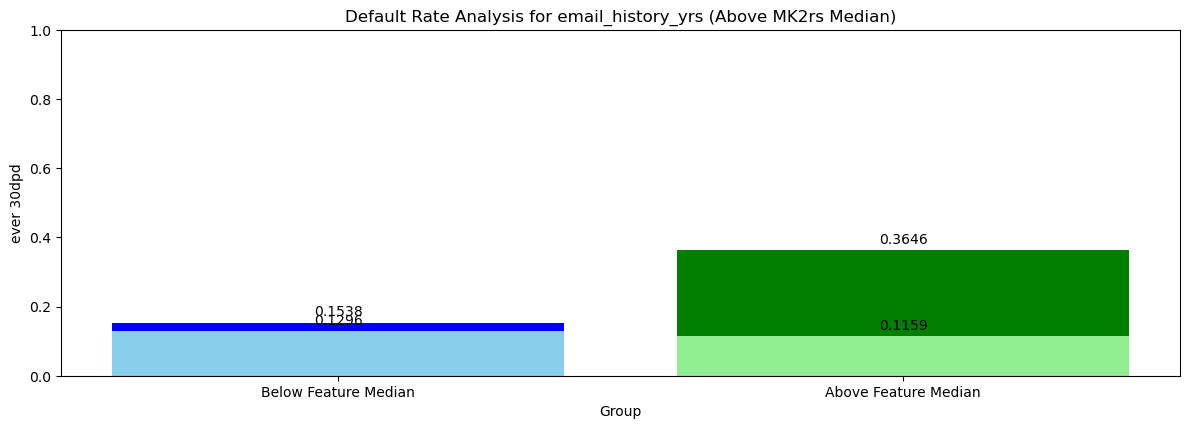

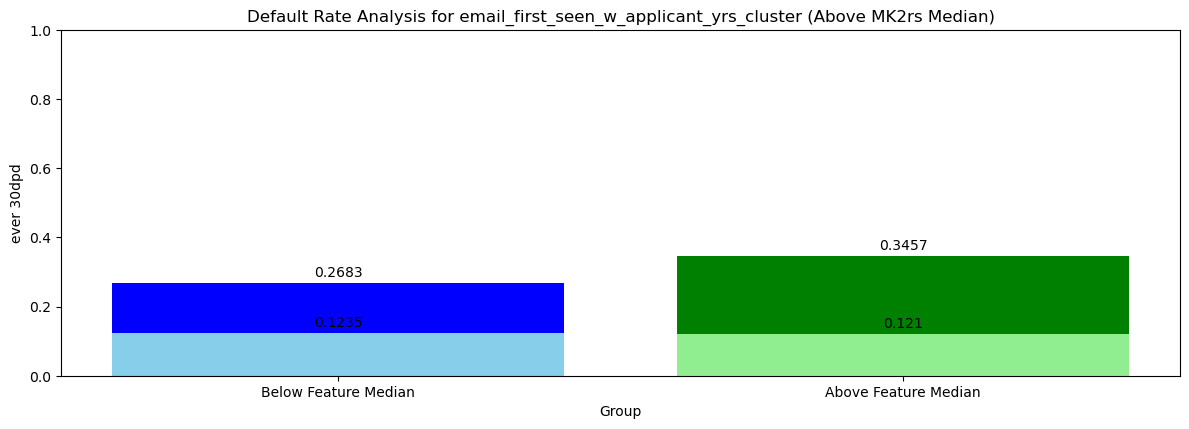

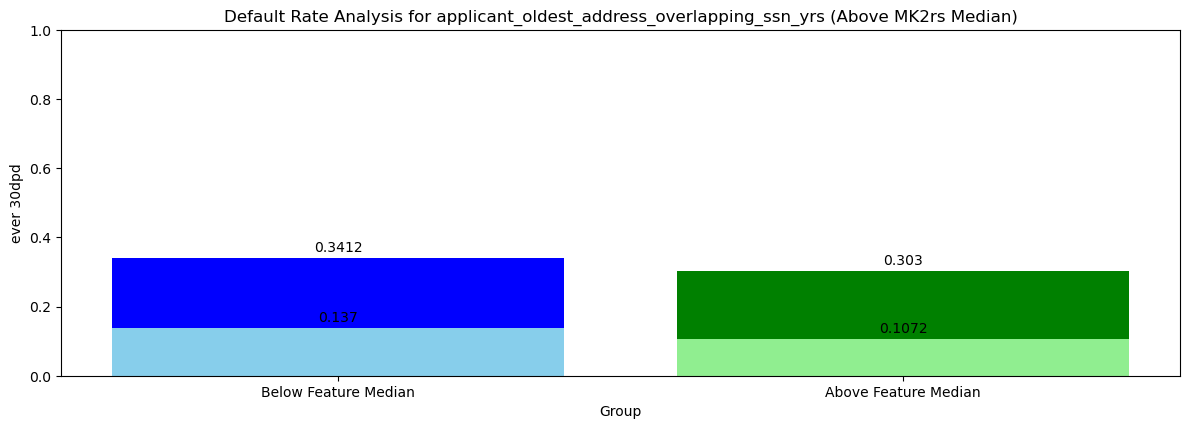

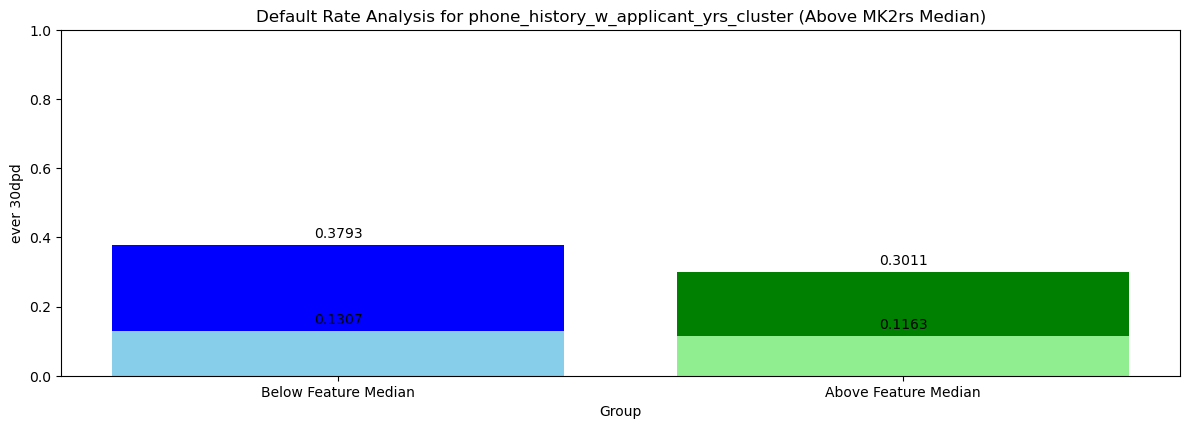

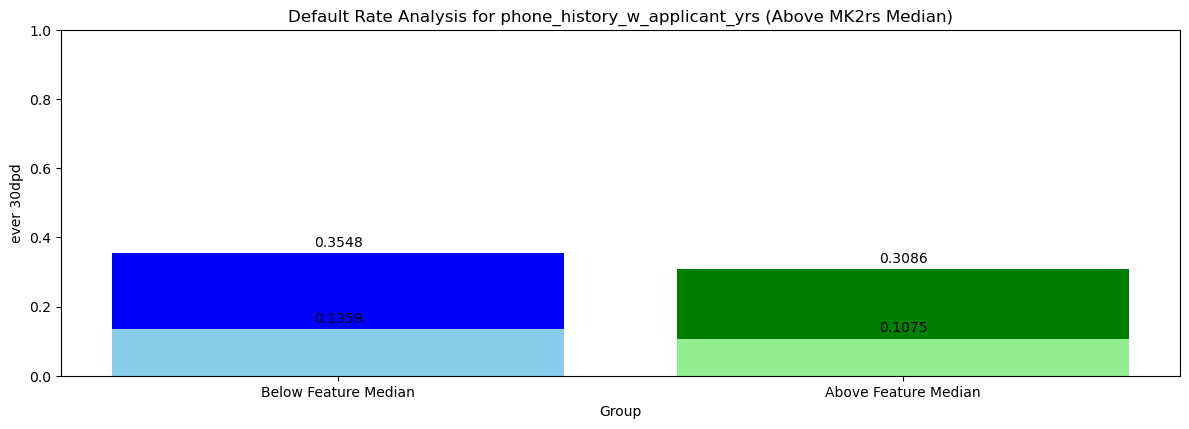

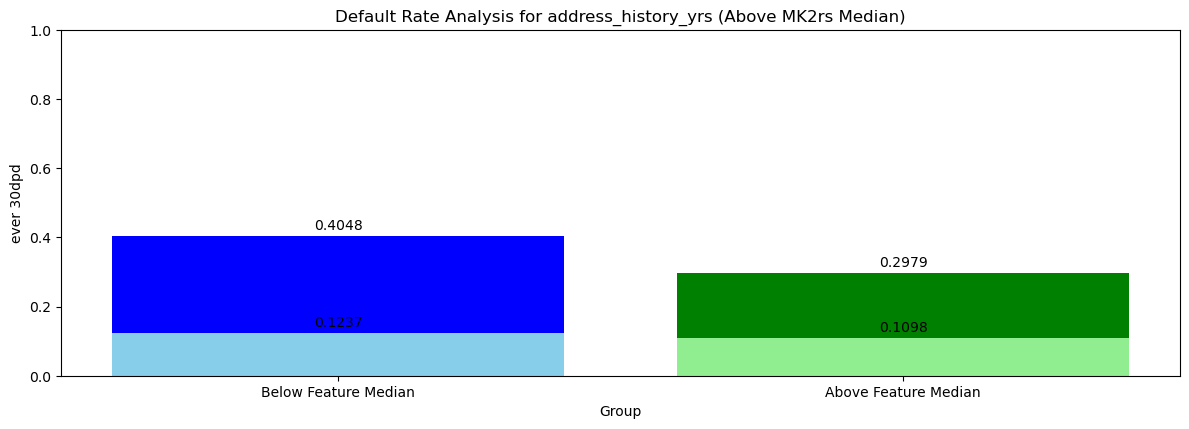

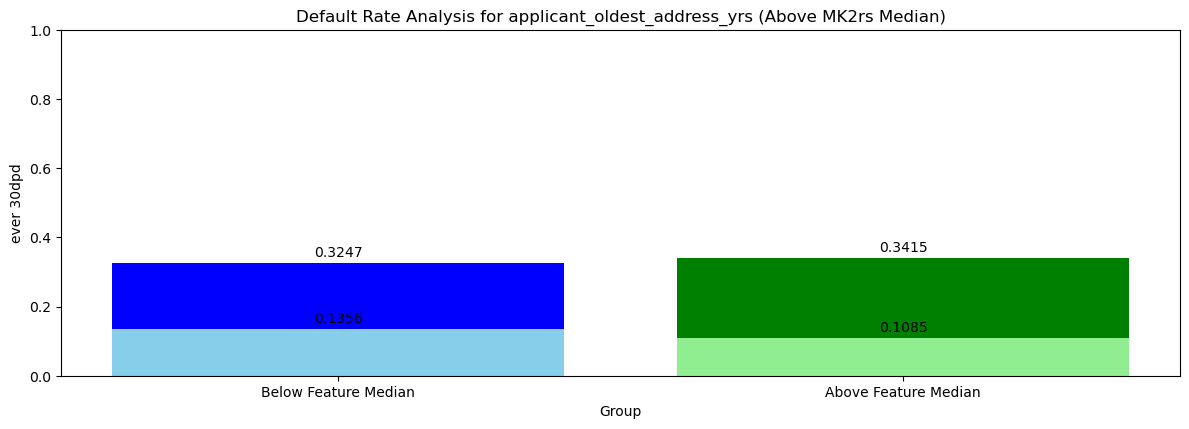

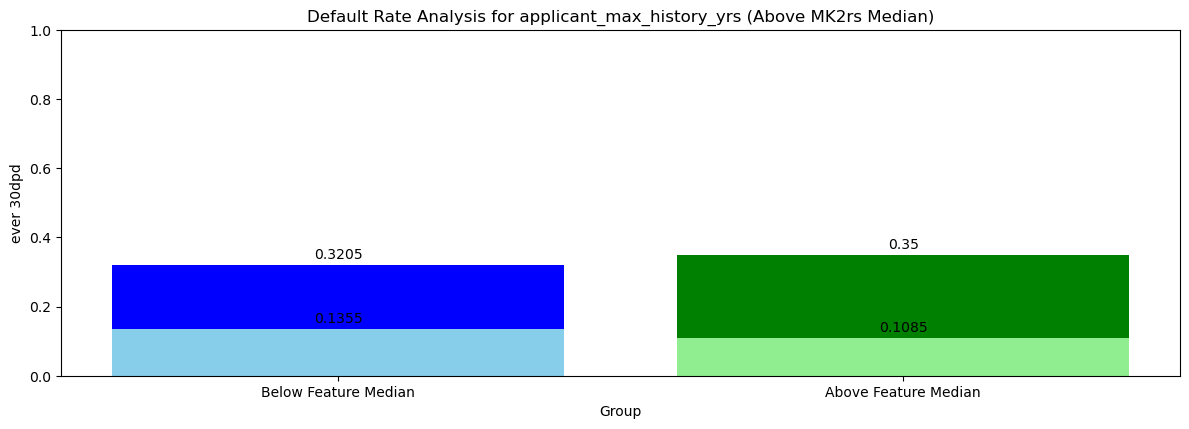

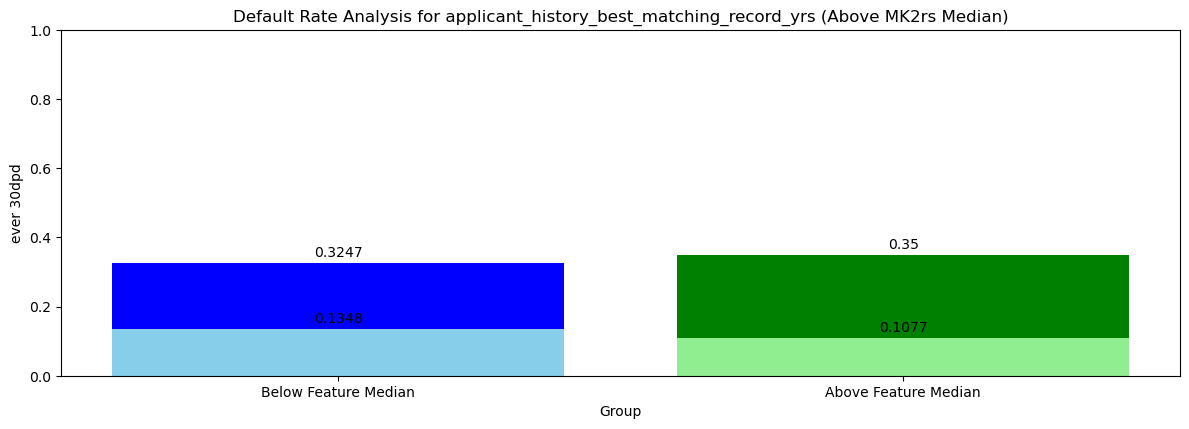

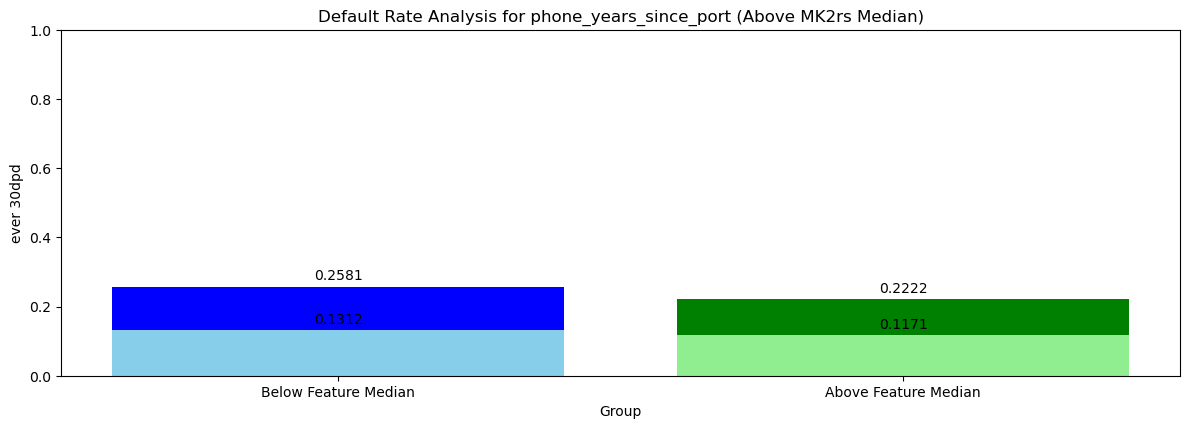

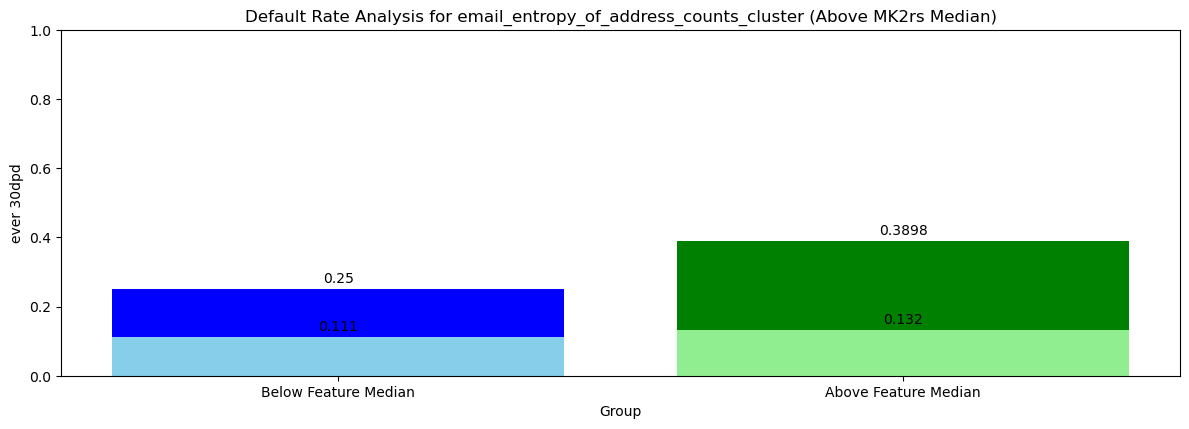

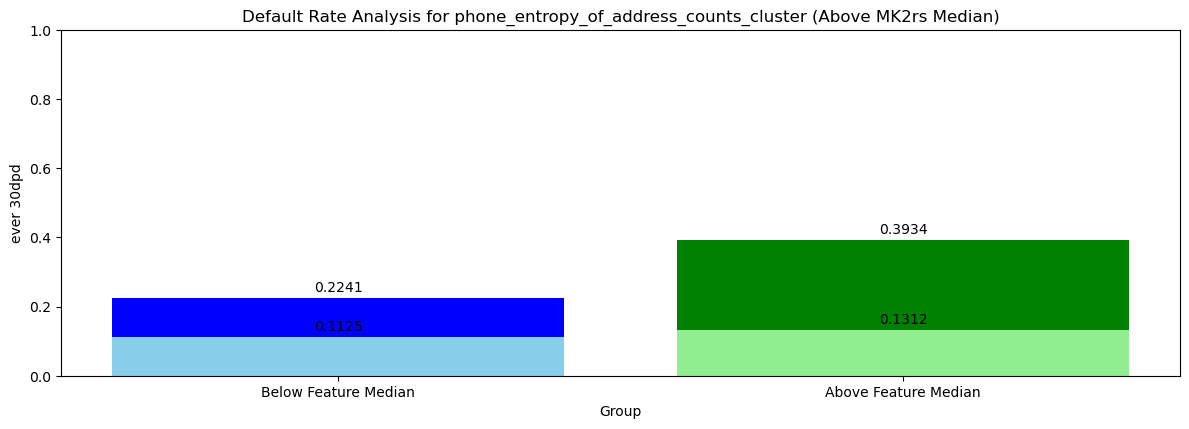

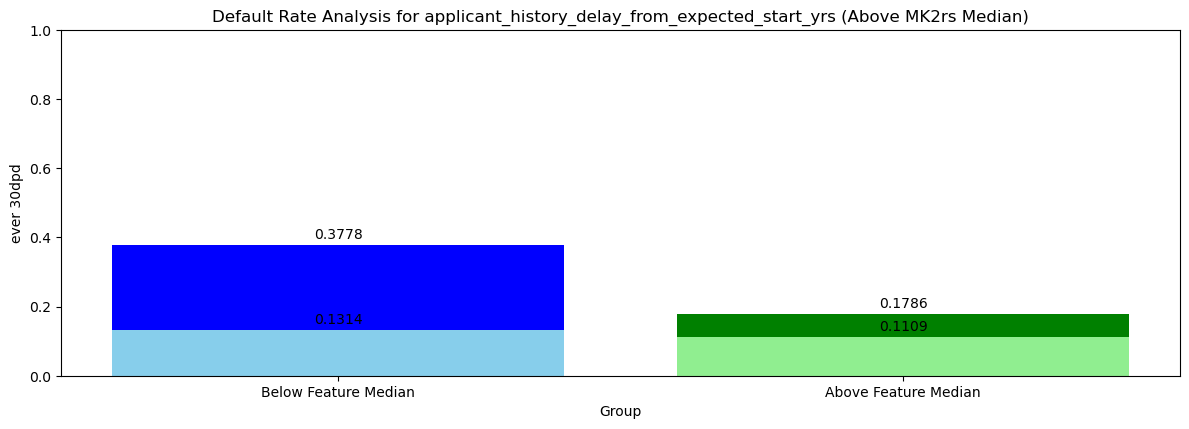

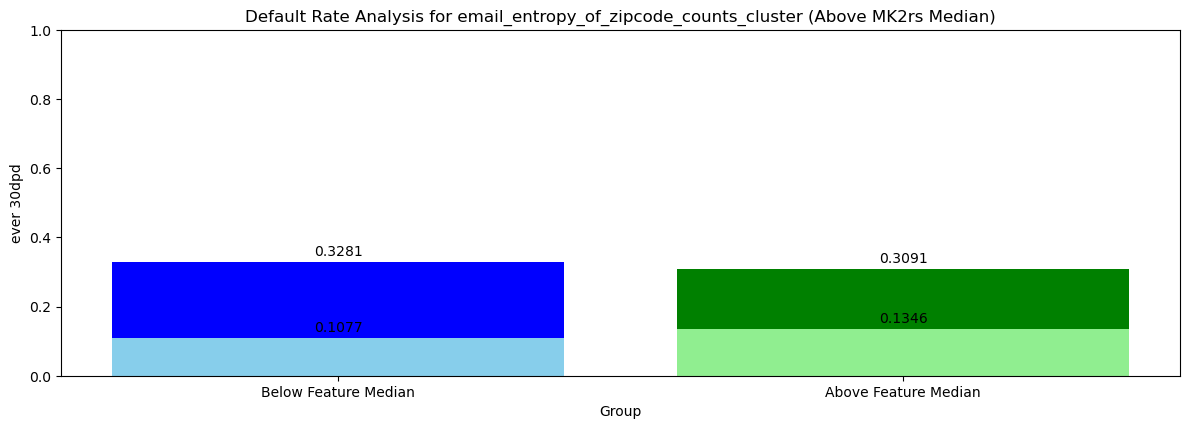

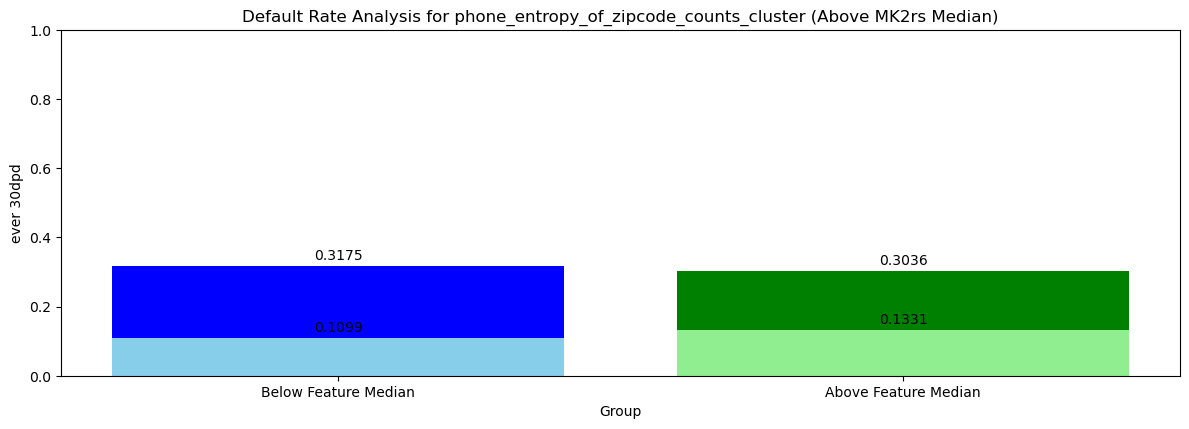

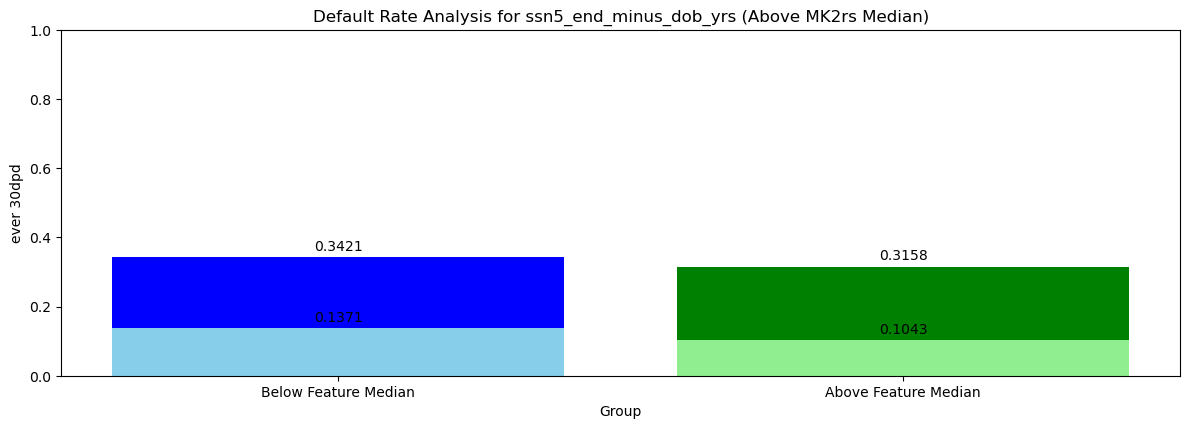

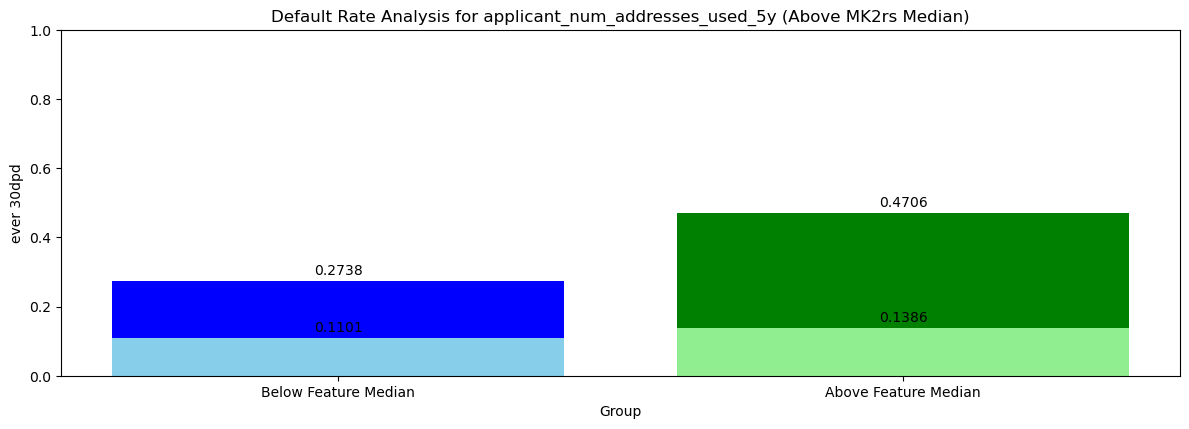

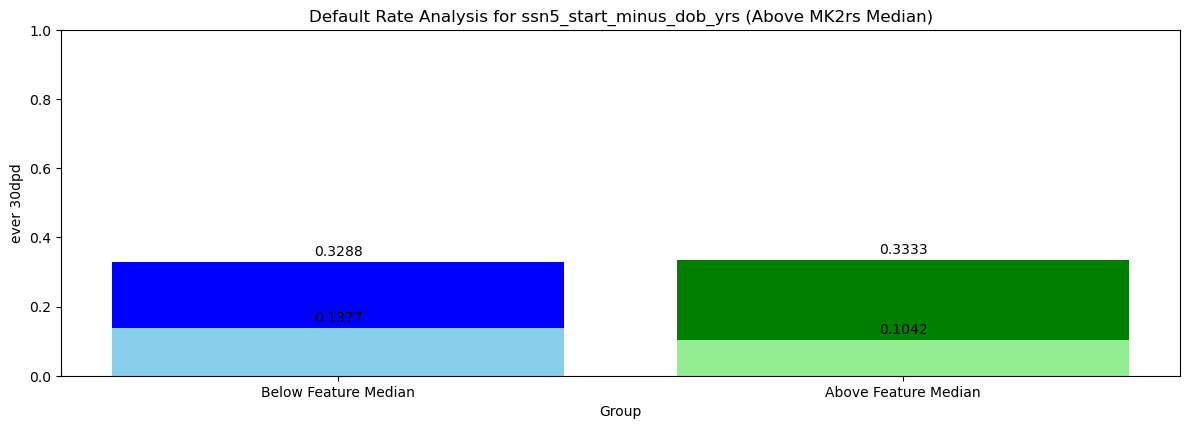

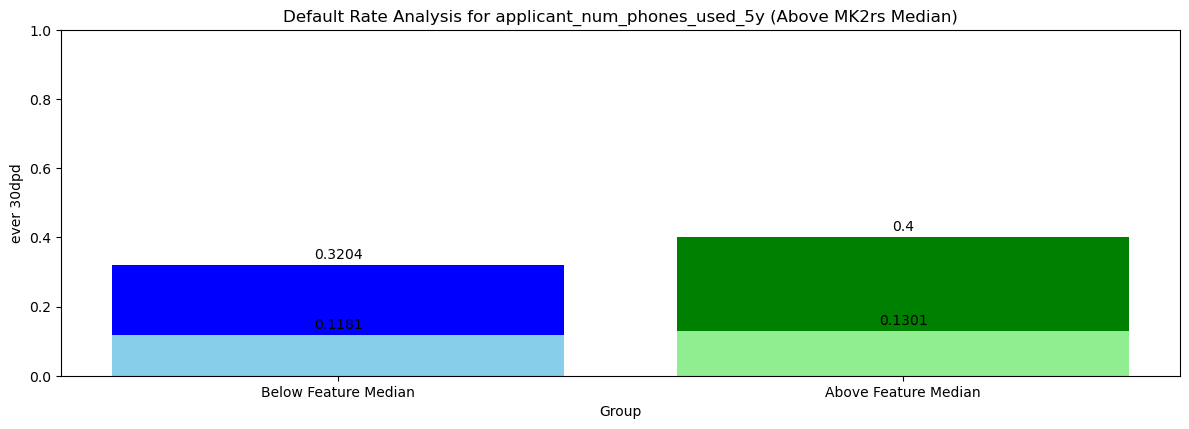

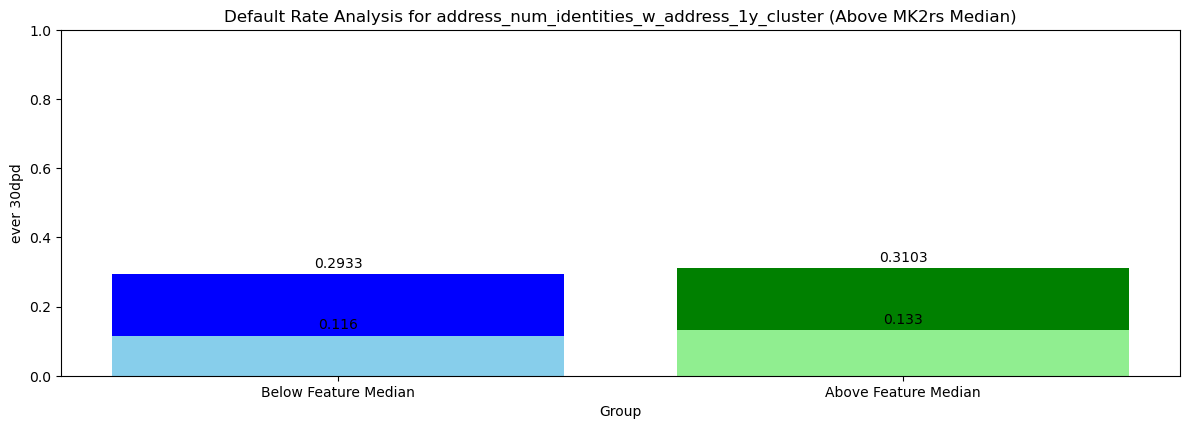

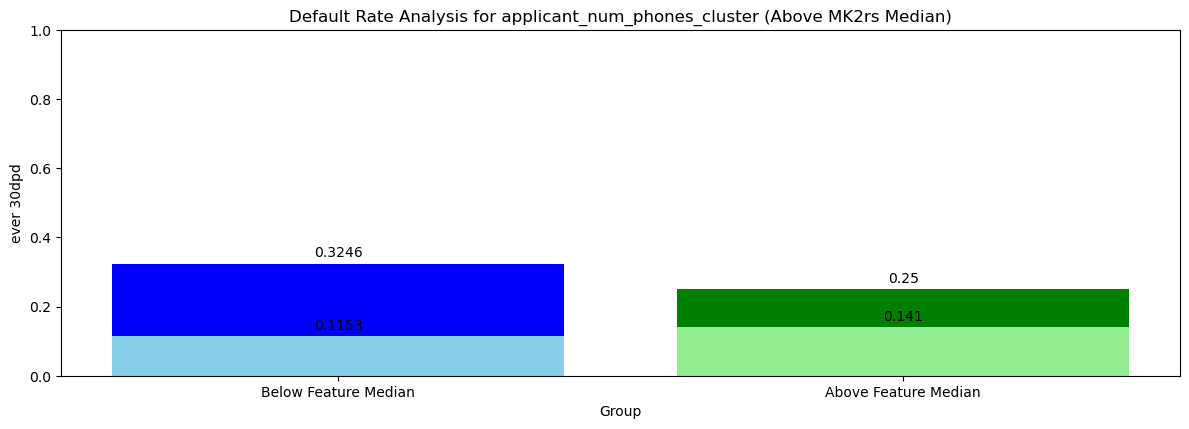

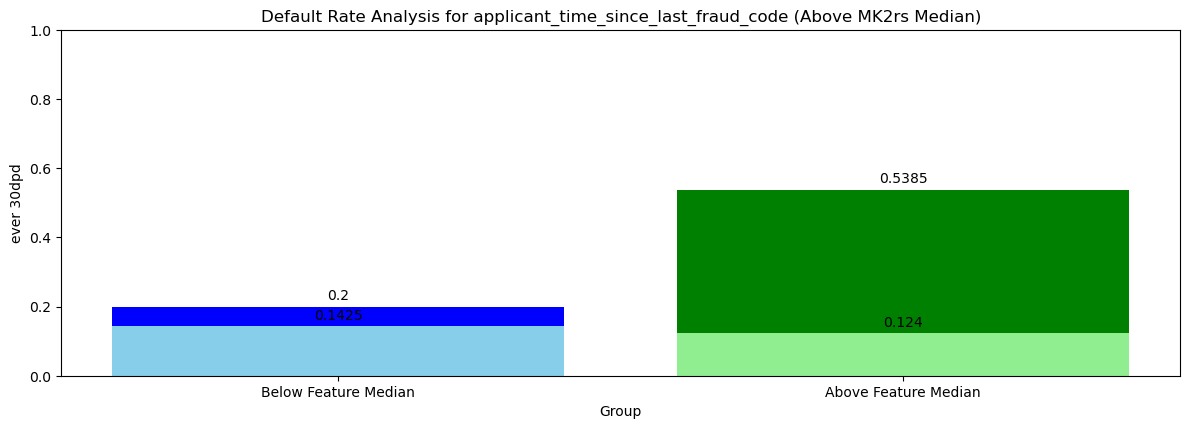

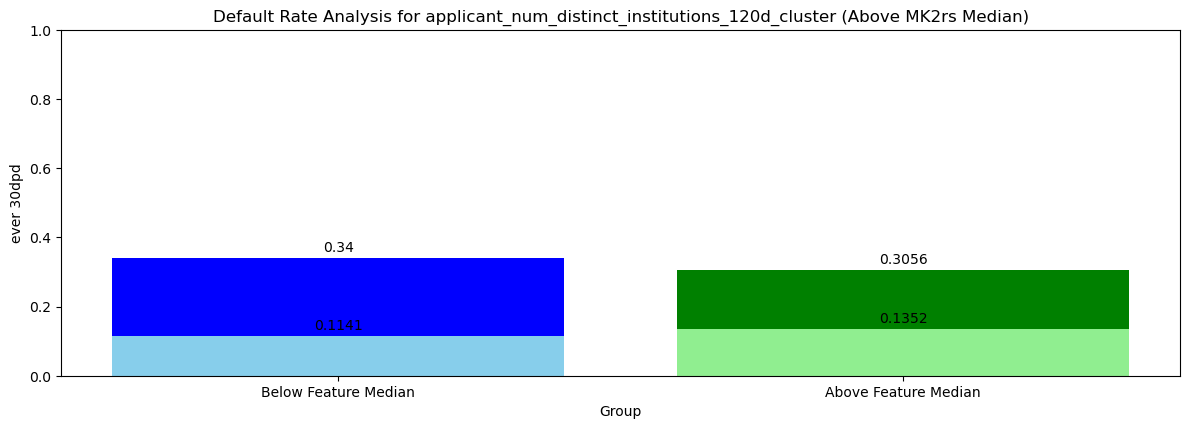

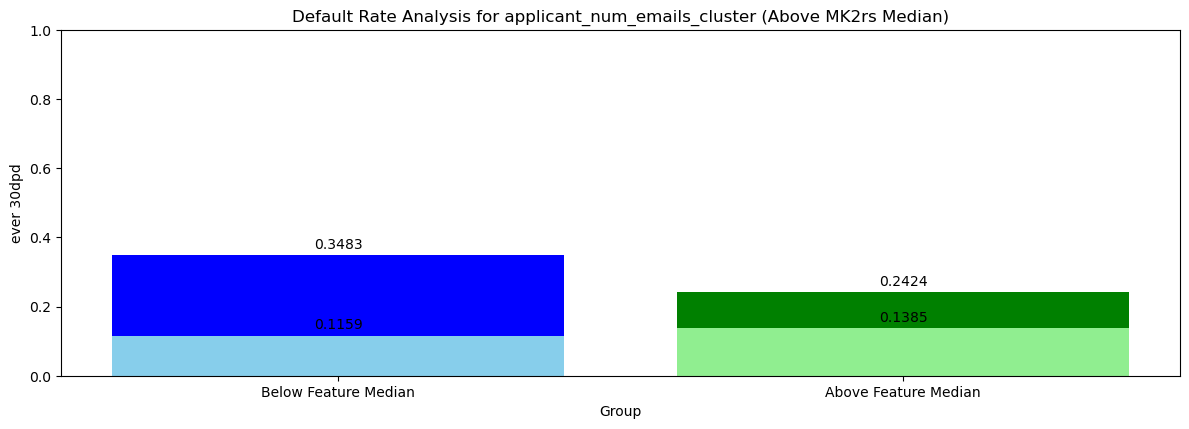

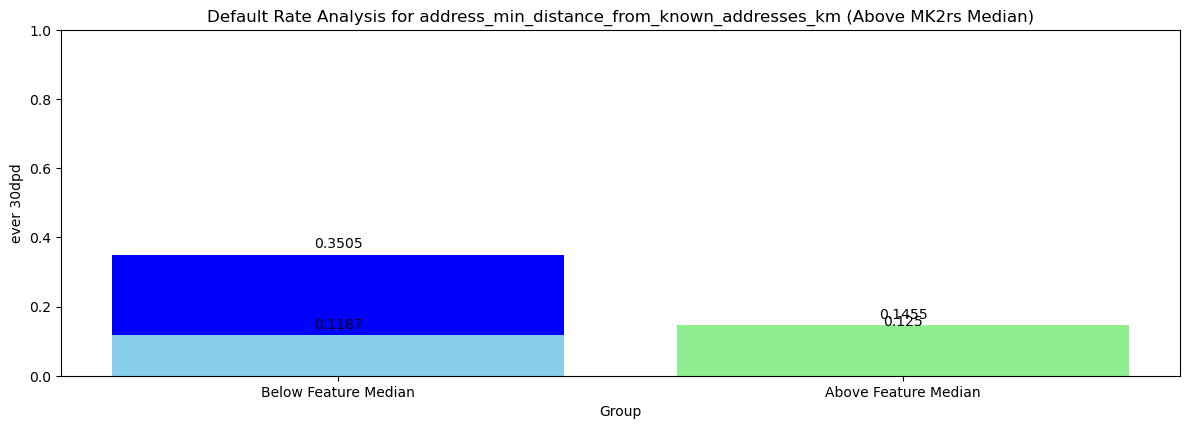

In [27]:
def plot_feature_analysis_score(results):
    for feature, data in results.items():
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        bars = plt.bar(['Below Feature Median', 'Above Feature Median'], 
                       [data['below_feature_below_default_rate'], data['below_feature_above_default_rate']],
                       color=['blue', 'green'])
        plt.xlabel('Group')
        plt.ylabel('ever 30dpd')
        plt.title(f'Default Rate Analysis for {feature} (Below MK2rs Median)')
        plt.ylim(0, 1)
    
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        
        plt.subplot(2, 1, 1)
        bars = plt.bar(['Below Feature Median', 'Above Feature Median'], 
                       [data['above_feature_below_default_rate'], data['above_feature_above_default_rate']],
                       color=['skyblue', 'lightgreen'])
        plt.xlabel('Group')
        plt.ylabel('ever 30dpd')
        plt.title(f'Default Rate Analysis for {feature} (Above MK2rs Median)')
        plt.ylim(0, 1)
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
plot_feature_analysis_score(results)

Org 2 3 4 mk2cfmarch2023 for defaults. Split the score at 50% population then see if it flattens out (ie the score
is handling this feature) or if this trend continues then the feature should be looked at

for all four orgs find conversion score or leadpass score for isorigs

### To excel

In [39]:
def plot_and_save_image(feature, data, output_path):
    plt.figure(figsize=(12, 8))
        
    plt.subplot(2, 1, 1)
    bars = plt.bar(['Below Feature Median', 'Above Feature Median'], 
                   [data['below_feature_below_default_rate'], data['below_feature_above_default_rate']],                       
                   color=['blue', 'green'])
    plt.xlabel('Group')
    plt.ylabel('ever 30dpd')
    plt.ylim(0, 1)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        
    plt.subplot(2, 1, 2)
    bars = plt.bar(['Below Feature Median', 'Above Feature Median'], 
                   [data['above_feature_below_default_rate'], data['above_feature_above_default_rate']],
                    color=['skyblue', 'lightgreen'])
    plt.xlabel('Group')
    plt.ylabel('ever 30dpd')
    plt.ylim(0, 1)
        
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

In [56]:
from openpyxl.chart import BarChart, Reference

def write_to_excel_with_plots_and_interpretation(results, output_file):
    image_paths = []
    interpretation_groups = []
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for feature, data in results.items():
            df = pd.DataFrame({
                'Metric': ['Below Feature Median Default Rate', 'Above Feature Median Default Rate'],
                'Below MK2rs Median': [data['below_feature_below_default_rate'], data['below_feature_above_default_rate']],
                'Above MK2rs Median': [data['above_feature_below_default_rate'], data['above_feature_above_default_rate']]
            })
            sheet_name = feature
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            workbook = writer.book
            worksheet = writer.sheets[sheet_name]
            
            worksheet.column_dimensions['A'].width = 28.00
            worksheet.column_dimensions['B'].width = 20.00
            worksheet.column_dimensions['C'].width = 20.00
            
            image_path = f'{feature}.png'
            plot_and_save_image(feature, data, image_path)
            image_paths.append(image_path)
            
            img = openpyxl.drawing.image.Image(image_path)
            img.anchor = f'A5'
            worksheet.add_image(img)
            
            #chart1 = BarChart()
            #chart1.y_axis.title = f'{feature} Default Rate'
            #chart1.x_axis.title = 'Group'
            
            #data_ref1 = Reference(worksheet, min_col=2, min_row=1, max_row=3)
            #cats_ref1 = Reference(worksheet, min_col=1, min_row=2, max_row=3)
            #chart1.add_data(data_ref1, titles_from_data=True)
            #chart1.set_categories(cats_ref1)
            
            #chart_anchor = 'E2'
            #worksheet.add_chart(chart1)
            
            #chart2 = BarChart()
            #chart2.y_axis.title = f'{feature} Default Rate'
            #chart2.x_axis.title = 'Group'
            
            #data_ref2 = Reference(worksheet, min_col=3, min_row=1, max_row=3)
            #cats_ref2 = Reference(worksheet, min_col=1, min_row=2, max_row=3)
            #chart2.add_data(data_ref2, titles_from_data=True)
            #chart2.set_categories(cats_ref2)
            
            #chart2_anchor = 'E18'
            #worksheet.add_chart(chart2)
            
            interpretation = ""
            if abs(data['below_feature_below_default_rate'] - data['below_feature_above_default_rate']) < 0.05 and abs(data['above_feature_below_default_rate'] - data['above_feature_above_default_rate']) < 0.05:
                interpretation = "The MK2rs is effectively capturing the risk associated with this feature."
            elif data['below_feature_below_default_rate'] > data['below_feature_above_default_rate']:
                interpretation = "The default rate is higher, indicating that lower values of this feature are associated with higher risk."
            else:
                interpretation = "The default rate is higher, indicating that higher values of this feature are associated with higher risk."
            
            worksheet['A46'] = "Interpretation:"
            worksheet['B46'] = interpretation
            
            interpretation_groups.append((feature, interpretation))
            
    title_page = pd.DataFrame(interpretation_groups, columns=['Feature', 'Interpretation Group'])
    title_page.to_excel(writer, sheet_name='Title Page', index=False)
    
    title_worksheet = writer.sheets['Title Page']
    title_worksheet.column_dimensions['A'].width = 28.00
    title_worksheet.column_dimensions['B'].width = 28.00

    for image_path in image_paths:
        if os.path.exists(image_path):
            os.remove(image_path)


In [57]:
output_file = 'Sentilink_analysis_report.xlsx'
write_to_excel_with_plots_and_interpretation(results, output_file)

# Appendix?

In [ ]:
import seaborn as sns
plt.figure(figsize=(60,30),dpi=300) 
sns.barplot(y=((final_df.isnull().sum()/len(final_df))*100).sort_values(), x=((final_df.isnull().sum()/len(final_df))*100).sort_values().
            index, palette='viridis') 
plt.xticks(rotation=90); 

In [ ]:
int_cols = final_df.select_dtypes(include=['int64']).columns
float_cols = final_df.select_dtypes(include=['float64']).columns
object_cols = final_df.select_dtypes(include=['object']).columns

In [ ]:
print(list(int_cols))

In [ ]:
print(list(float_cols))

In [ ]:
print(list(object_cols))

In [ ]:
print(final_df['isFPD'].unique())

## K-Nearest Neighbours Imputation
#### Imputes values based on the simularity between observations

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer_KNN = KNNImputer(n_neighbors=4)

In [ ]:
KNN_imputed_df = pd.DataFrame(imputer_KNN.fit_transform(finals_df), columns=finals_df.columns)
print(KNN_imputed_df.head())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = KNN_imputed_df.drop(columns=['Ever_30DPD_in_90'])
y = KNN_imputed_df['Ever_30DPD_in_90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_KNN = RandomForestClassifier(random_state=42)
model_KNN.fit(X_train, y_train)
feature_importances_KNN = model_KNN.feature_importances_

In [ ]:
importance_KNN_df = pd.DataFrame({
    'Feature': X_columns,
    'Importance': feature_importances_KNN
}).sort_values(by='Importance', ascending=False)
print(importance_KNN_df)

## Multivariate Imputation by Chained Equations
#### Generates multiple imputations for each missing value

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_MICE = IterativeImputer(max_iter=10, random_state=0)
MICE_imported_df = pd.DataFrame(imputer_MICE.fit_transform(final_df), columns=final_df.columns)
print(MICE_imputed_df.head())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = MICE_imputed_df.drop(columns=['Ever_30DPD_in_90'])
y = MICE_imputed_df['Ever_30DPD_in_90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_MICE = RandomForestClassifier(random_state=42)
model_MICE.fit(X_train, y_train)
feature_importances_MICE = model_MICE.feature_importances_

In [ ]:
importance_MICE_df = pd.DataFrame({
    'Feature': X_columns,
    'Importance': feature_importances_MICE
}).sort_values(by='Importance', ascending=False)
print(importance_MICE_df)

### Get every parameter in an int/float form (Just ACCEPT, REJECT, TRUE, FALSE) then should work 